# Enforced Fairness for Machine Learning in Insurance, Criminal Justice, and Other Sensitive Environments
##### Author: Tristan Brigham
##### Course: CPSC 471

The tradeoff between explainability and efficiency in current machine learning models is extreme. I seek to provide a framework and example implementations of how fairness and explainability can be directly integrated into ML both during training as well as in a post-hoc manner for the explanations of outputs.

In this notebook, I explore two different datasets in order to assess whether the proposed strategy for observable and explainable machine learning is viable for sensitive environments. My strategy opens the traditional "black box" model to investigation and auditing without the compromises necessitated by current non-linear machine learning. 

In [1]:
# install the packages that we need
# !pip install plotly
# !pip install -U scikit-learn
# !pip install shap
# !pip install -U kaleido

In [2]:
%matplotlib inline

In [3]:
## imports for the program
import os
import io
import csv
import zlib
import copy
import math
import time
import pickle
import base64
import joblib
import hashlib
import platform
import warnings

import numpy as np
import pandas as pd
import xgboost as xgb
from tqdm import tqdm
from xgboost import plot_importance
from scipy.optimize import fmin_powell
from scipy import stats

# plot information in 3 dimensions
# from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import kaleido
from PIL import Image

from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, DBSCAN, MeanShift, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, confusion_matrix, accuracy_score, mean_absolute_error
from sklearn.inspection import PartialDependenceDisplay
from sklearn.linear_model import LinearRegression

# the pytorch module
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

# torch neural network items
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# changing the precision of the floating point operations
from torch.cuda.amp import GradScaler, autocast

# for visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# lime model evaluation
from lime import lime_tabular

# for encrypting the model and hashing it
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.kdf.scrypt import Scrypt
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives import serialization
from cryptography.hazmat.primitives.asymmetric import rsa
from cryptography.hazmat.primitives.asymmetric import padding
from cryptography.fernet import Fernet, MultiFernet




# code for xgboost found at https://www.kaggle.com/code/zeroblue/xgboost-with-optimized-offsets

# defining the device for cuda
if platform.system() == 'Darwin' and torch.backends.mps.is_available():
	
	# check if mps is available on mac
	device = torch.device('mps')  

elif torch.cuda.is_available():
	
	# check if cuda is available
    device = torch.device('cuda')  

else:
	
	# fallback to cpu if cuda is not available
	device = torch.device('cpu')  

# output the selected device
print(f"Using device: {device}")


Using device: mps


In [4]:
# environment and global variables that we want to use for the program



# we have two options for the dataset that we are using
USED_DATASET = "criminal justice"
USED_DATASET = "health insurance"


# global directory path
HOME_DIR = os.path.expanduser('~')

# the sub directory from the home direcotry
SUB_DIR = "Desktop/Classes/CPSC 471/Final Project/"

# the path to the dataset directory
DATASET_PATH = "../final_471_datasets"

# the path to the generated images directory that we are using
GENERATED_IMAGES_DIR = "models"

# save path
SAVE_MODEL_PATH = os.path.join(HOME_DIR, SUB_DIR, "models_save")
print(f"SAVE PATH: {SAVE_MODEL_PATH}")

# saved models' names
AUG_SAVE_FILE_NAME = "aug_model_save.pth"
FULL_INPUT_AUG_SAVE_FILE_NAME = "full_input_aug_model_save.pth"
BASELINE_SAVE_FILE_NAME = "baseline_model_save.pth"
SINGLE_SAVE_FILE_NAME = "single_model_save.pth"
INFO_DICT_NAME = "info_dict.pkl"
RUNTHROUGH_DIR_NAME = "runthroughs"

# defining the batch size
BATCH_SIZE = 40

# whether we should train the model or load the model in this passthrough
TRAIN_MODEL = True

# whether we should sum the weight in the augmented model (alternative is multiply the weight)
SUM_WEIGHT = True
# the amount that we should scale the comcept loss by
SUM_EPSILON = 0.001 	

# what percent of neurons we should upweight
UPWEIGHT_PERCENT = 0.3

# whether we should use batches for training or not
USE_BATCHES = True

# whether we should try to create a single 
TESTING_SINGLE_lAYER = True

# the names for the 

# PLOT_PALETTE = "viridis"
# PLOT_PALETTE = "rainbow"
# PLOT_PALETTE = "mako"
PLOT_PALETTE = "magma"
PLOT_PALETTE = "icefire"


PLOT_COLOR_1 = "darkorange"
PLOT_COLOR_2 = "dodgerblue"
PLOT_COLOR_3 = "green"
PLOT_COLOR_4 = "firebrick"
TRANSPARENCY = 0.3

# how many output classes
NUM_CLASSES = 8
NUM_TOP_FEATURES_TO_SHOW = 10	

# parameter for how deep into the network we should stop boosting gradients
depth_revert_grad_boost = 0.75
CLUSTER_NUM = 6
MAX_INDICIES_LEN_PLOTTING = 500

# how strong should the explanation regularization be
adj_weight = 3.0
adj_weight = 1.0

# this determines whether we are saving all of the information that is generated in the runthrough
SHOULD_SAVE_OUTPUT = True
RUN_BASE_NAME = "run"

# the number of principal components that we should consider
NUM_PCA_PC = 10

# define the clustering method that we will use
clustering_method_name = 'k_means_centers'


SAVE PATH: /Users/tristanbrigham/Desktop/Classes/CPSC 471/Final Project/models_save


In [5]:
# program state variables
pca_mahalanobis_covariance_matrix = None
total_mahalanobis_covariance_matrix = None


In [6]:
# function for generating and saving the file to a unique file name
def generate_unique_file_dir(base_path, file_base, allow_base=False):
      
	# initialize the full path
	full_path = os.path.join(base_path, file_base)
	
	# if the file does not exist, return this path
	if not os.path.exists(full_path) and allow_base:
		return full_path
	
	# if the file exists, modify it by adding a number suffix
	# file_base, file_extension = os.path.splitext(filename)
	counter = 1  # Start numbering from 1
	
	# loop to find a non-existing file
	while True:

		# format the new file name
		new_filename = f"{file_base}_{counter}"
		full_path = os.path.join(base_path, new_filename)

		# check if the path exists or not
		if not os.path.exists(full_path):
			return full_path
		
		counter += 1  


# if we are saving the output, then we should save all of the information to a new folder
if SHOULD_SAVE_OUTPUT:

	# the path to the directory that we are going to populate
	curr_run_dir = generate_unique_file_dir(os.path.join(HOME_DIR, SUB_DIR, RUNTHROUGH_DIR_NAME), RUN_BASE_NAME)

	# create a directory at the path that we specified
	os.makedirs(curr_run_dir, exist_ok=True)

	# print a status update about the file
	print(f"Saving all files from run to {curr_run_dir}")


# init a new info dictionary data structure
file_path = os.path.join(curr_run_dir, INFO_DICT_NAME)

try:
    # Attempt to load the dictionary from the file
    with open(file_path, 'rb') as file:
        info_dict = pickle.load(file)
except (FileNotFoundError, EOFError, pickle.PickleError) as e:
    # If the file doesn't exist or an error occurs during loading, initialize an empty dictionary
    print(f"Failed to load the file: {e}")
    info_dict = {}
	

Saving all files from run to /Users/tristanbrigham/Desktop/Classes/CPSC 471/Final Project/runthroughs/run_4
Failed to load the file: [Errno 2] No such file or directory: '/Users/tristanbrigham/Desktop/Classes/CPSC 471/Final Project/runthroughs/run_4/info_dict.pkl'


In [7]:
# ensure the directory exists
os.makedirs(SAVE_MODEL_PATH, exist_ok=True)

# suppress the user warnings that are not helpful to us at all
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# make sure that the results are reproducable
torch.manual_seed(0) 

In [8]:
# the base model that we are going to be testing against is an XGBoost Model

# wrapper for performing our evaluations
def eval_wrapper(yhat, y):
    y = np.array(y)
    y = y.astype(int)
    yhat = np.array(yhat)
    yhat = np.clip(np.round(yhat), np.min(y), np.max(y)).astype(int)
    return cohen_kappa_score(yhat, y, weights='quadratic')

# the parameters for the xgboost model
def get_params():
    params = {}
    params["objective"] = "reg:squarederror"  # Updated to 'reg:squarederror' to avoid deprecation warning
    params["eta"] = 0.05
    params["min_child_weight"] = 360
    params["subsample"] = 0.85
    params["colsample_bytree"] = 0.3
    params["silent"] = 1
    params["max_depth"] = 7
    plst = list(params.items())
    return plst

# this is how we are scoring the model
def score_offset(data, bin_offset, sv, scorer=eval_wrapper):
    # data has the format of pred=0, offset_pred=1, labels=2 in the first dim
    data[1, data[0].astype(int)==sv] = data[0, data[0].astype(int)==sv] + bin_offset
    score = scorer(data[1], data[2])
    return score

# function to apply the offset for scoring
def apply_offsets(data, offsets):
    for j in range(NUM_CLASSES):
        data[1, data[0].astype(int)==j] = data[0, data[0].astype(int)==j] + offsets[j]
    return data


In [9]:
# load the data

if USED_DATASET == "health insurance":

	print("Load the data using pandas")
	train = pd.read_csv(f"{DATASET_PATH}/health_insurance_train.csv")
	test = pd.read_csv(f"{DATASET_PATH}/health_insurance_test.csv")

	# global variables
	columns_to_drop = ['Id', 'Response'] #, 'Medical_History_10','Medical_History_24']
	xgb_num_rounds = 720
	missing_indicator = -1000

	# training and testing temp dataframes
	temp_train = train
	temp_test = test

	# getting all of the data
	all_data = pd.concat([temp_train, temp_test], ignore_index=True)

	# create new variable for product first and second character
	all_data['Product_Info_2'] = all_data.Product_Info_2.astype(str)
	all_data['Product_Info_2_char'] = all_data["Product_Info_2"].str[0]
	all_data['Product_Info_2_num'] = all_data["Product_Info_2"].str[1]

	# factorize the categorical variables
	all_data['Product_Info_2'] = pd.factorize(all_data['Product_Info_2'])[0]
	all_data['Product_Info_2_char'] = pd.factorize(all_data['Product_Info_2_char'])[0]
	all_data['Product_Info_2_num'] = pd.factorize(all_data['Product_Info_2_num'])[0]

	# get the combined BMI age variable
	all_data['BMI_Age'] = all_data['BMI'] * all_data['Ins_Age']

	# checking for how many medical keywords were found in each patient diagnosis
	med_keyword_columns = all_data.columns[all_data.columns.str.startswith('Medical_Keyword_')]
	all_data['Med_Keywords_Count'] = all_data[med_keyword_columns].sum(axis=1)

	# remove the missing values
	print('Eliminate missing values')    
	all_data.fillna(missing_indicator, inplace=True)

	# fix the dtype on the label column
	all_data['Response'] = all_data['Response'].astype(int)

	# split train and test
	train = all_data[all_data['Response']>0].copy()
	test = all_data[all_data['Response']<1].copy()

	# for later
	train_data = all_data[all_data['Response'] > 0].copy()
	test_data = all_data[all_data['Response'] < 1].copy()


else:

	print("Load the data using pandas")
	train = pd.read_csv(f"{DATASET_PATH}/train.csv")
	test = pd.read_csv(f"{DATASET_PATH}/test.csv")

	# global variables
	columns_to_drop = ['Id', 'Response'] #, 'Medical_History_10','Medical_History_24']
	xgb_num_rounds = 720
	missing_indicator = -1000

	# training and testing temp dataframes
	temp_train = train
	temp_test = test

	# getting all of the data
	all_data = pd.concat([temp_train, temp_test], ignore_index=True)

	# create new variable for product first and second character
	all_data['Product_Info_2'] = all_data.Product_Info_2.astype(str)
	all_data['Product_Info_2_char'] = all_data["Product_Info_2"].str[0]
	all_data['Product_Info_2_num'] = all_data["Product_Info_2"].str[1]

	# factorize the categorical variables
	all_data['Product_Info_2'] = pd.factorize(all_data['Product_Info_2'])[0]
	all_data['Product_Info_2_char'] = pd.factorize(all_data['Product_Info_2_char'])[0]
	all_data['Product_Info_2_num'] = pd.factorize(all_data['Product_Info_2_num'])[0]

	# get the combined BMI age variable
	all_data['BMI_Age'] = all_data['BMI'] * all_data['Ins_Age']

	# checking for how many medical keywords were found in each patient diagnosis
	med_keyword_columns = all_data.columns[all_data.columns.str.startswith('Medical_Keyword_')]
	all_data['Med_Keywords_Count'] = all_data[med_keyword_columns].sum(axis=1)

	# remove the missing values
	print('Eliminate missing values')    
	all_data.fillna(missing_indicator, inplace=True)

	# fix the dtype on the label column
	all_data['Response'] = all_data['Response'].astype(int)

	# split train and test
	train = all_data[all_data['Response']>0].copy()
	test = all_data[all_data['Response']<1].copy()

	# for later
	train_data = all_data[all_data['Response'] > 0].copy()
	test_data = all_data[all_data['Response'] < 1].copy()

# convert data to xgb data structure
xgtrain = xgb.DMatrix(train.drop(columns_to_drop, axis=1), train['Response'].values, missing=missing_indicator)
xgtest = xgb.DMatrix(test.drop(columns_to_drop, axis=1), label=test['Response'].values, missing=missing_indicator)    

# get the parameters for xgboost
plst = get_params()
print(plst)      

Load the data using pandas


Eliminate missing values
[('objective', 'reg:squarederror'), ('eta', 0.05), ('min_child_weight', 360), ('subsample', 0.85), ('colsample_bytree', 0.3), ('silent', 1), ('max_depth', 7)]


In [10]:
# train the model on the data as a baseline for the information
model = xgb.train(plst, xgtrain, xgb_num_rounds) 

# get preds
train_preds = model.predict(xgtrain)

train_score = eval_wrapper(train_preds, train['Response'])
print('Train score is:', train_score) 
test_preds = model.predict(xgtest)

# now save the model to a new file if we need to
model.save_model(os.path.join(curr_run_dir, 'xgb_model.bin'))

Train score is: 0.6509777181220997


In [11]:
# train offsets 
offsets = np.array([0.1, -1, -2, -1, -0.8, 0.02, 0.8, 1])
offset_preds = np.vstack((train_preds, train_preds, train['Response'].values))
offset_preds = apply_offsets(offset_preds, offsets)
opt_order = [6,4,5,3]

# go through the optimization order and apply the offsets
for j in opt_order:
    train_offset = lambda x: -score_offset(offset_preds, x, j) * 100
    offsets[j] = fmin_powell(train_offset, offsets[j], disp=False)

# return the offset score value to the user of the ml model
print('Offset Train score is:', eval_wrapper(offset_preds[1], train['Response']))

Offset Train score is: 0.7033385099458398


In [12]:
# apply offsets to test
data = np.vstack((test_preds, test_preds, test['Response'].values))
data = apply_offsets(data, offsets)

# clip the final predictions
final_test_preds = np.round(np.clip(data[1], 1, 8)).astype(int)

# get the predictions from the machine learning model
preds_out = pd.DataFrame({"Id": test['Id'].values, "Response": final_test_preds})
preds_out = preds_out.set_index('Id')
# preds_out.to_csv('xgb_offset_submission.csv')

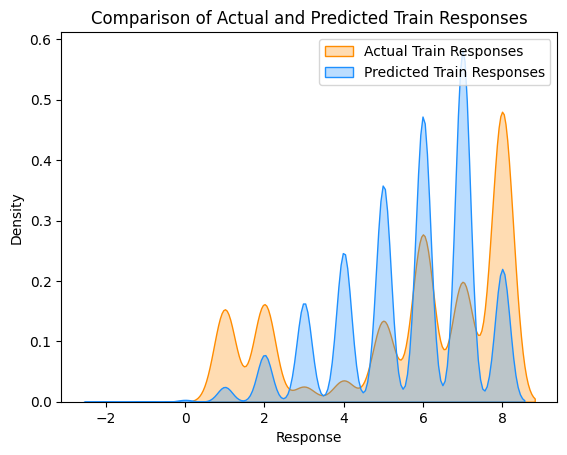

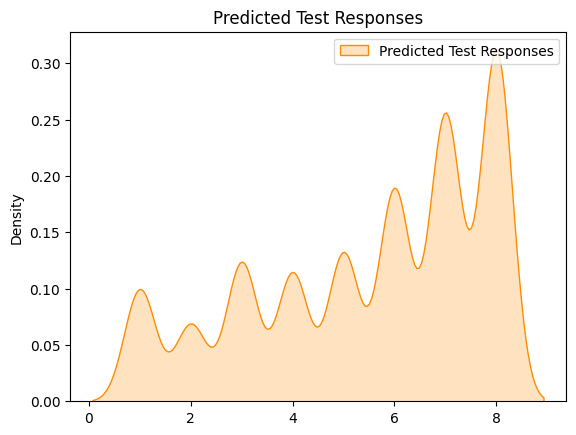

In [13]:
# visualize the output of the XGBoost Model that we used
# sns.kdeplot(train['Response'], label='Actual Train Responses', fill=True, palette=PLOT_PALETTE)
# sns.kdeplot(np.rint(train_preds).astype(int), label='Predicted Train Responses', fill=True, palette=PLOT_PALETTE)
# sns.kdeplot(np.rint(train_preds).astype(int), label='Predicted Train Responses', fill=True, palette=PLOT_PALETTE)
sns.kdeplot(train['Response'], label='Actual Train Responses', fill=True, color=PLOT_COLOR_1, alpha=TRANSPARENCY)
# sns.kdeplot(train['Response'], label='Actual Train Responses', fill=True)
# sns.kdeplot(np.rint(train_preds).astype(int), label='Predicted Train Responses', fill=True)
sns.kdeplot(np.rint(train_preds).astype(int), label='Predicted Train Responses', fill=True, color=PLOT_COLOR_2, alpha=TRANSPARENCY)
plt.title('Comparison of Actual and Predicted Train Responses')
plt.legend()

# save the figure and then show it
# plt.savefig(os.path.join(HOME_DIR, SUB_DIR, GENERATED_IMAGES_DIR, "xgb_actual_train.png"), dpi=300)

if SHOULD_SAVE_OUTPUT:
	plt.savefig(os.path.join(curr_run_dir, "xgb_actual_train.png"), dpi=300)


plt.show()

# for test predictions, assuming you have actual test responses
# sns.kdeplot(test['Response'], label='Actual Test Responses', fill=True, palette=PLOT_PALETTE)
# sns.kdeplot(final_test_preds, label='Predicted Test Responses', fill=True, palette="plasma")
sns.kdeplot(final_test_preds, label='Predicted Test Responses', fill=True, color=PLOT_COLOR_1)
plt.title('Predicted Test Responses')
plt.legend()

# save the figure and then show it
# plt.savefig(os.path.join(HOME_DIR, SUB_DIR, GENERATED_IMAGES_DIR, "xgb_pred_test.png"), dpi=300)

if SHOULD_SAVE_OUTPUT:
	plt.savefig(os.path.join(curr_run_dir, "xgb_pred_test.png"), dpi=300)


plt.show()

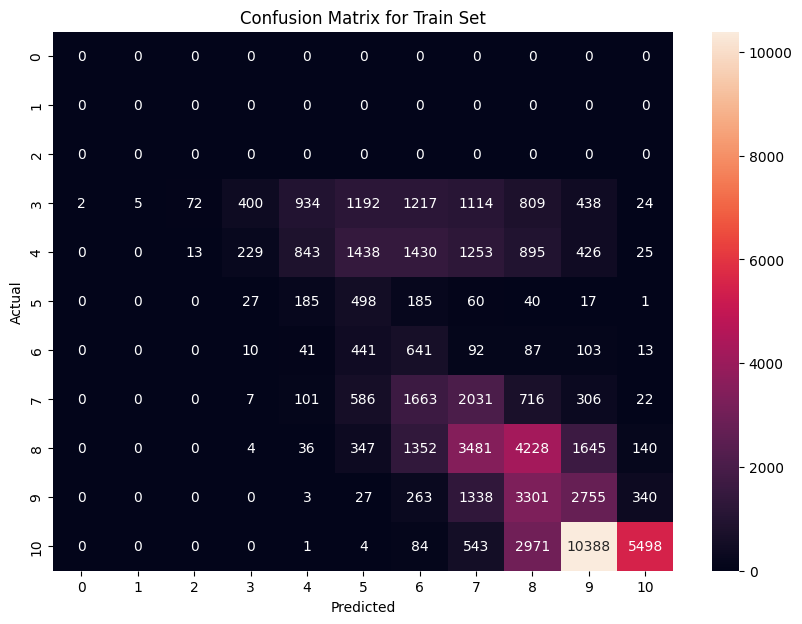

In [14]:
# get the confusion matrix
cm = confusion_matrix(train['Response'], np.rint(train_preds).astype(int))

# show the plot
plt.figure(figsize=(10, 7))
# sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix for Train Set')
plt.ylabel('Actual')
plt.xlabel('Predicted')
# plt.savefig(os.path.join(HOME_DIR, SUB_DIR, GENERATED_IMAGES_DIR, "xgb_conf_matrix.png"), dpi=300)

# save the confusion matrix output to a png file
if SHOULD_SAVE_OUTPUT:
	plt.savefig(os.path.join(curr_run_dir, "xgb_conf_matrix.png"), dpi=300)

plt.show()

<Figure size 1000x800 with 0 Axes>

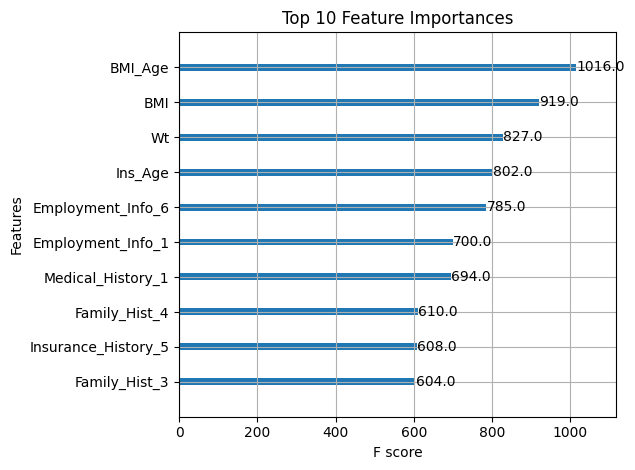

In [15]:
# plot the final importances
plt.figure(figsize=(10, 8))

# show the top NUM_TOP_FEATURES_TO_SHOW
plot_importance(model, max_num_features=NUM_TOP_FEATURES_TO_SHOW) 
plt.title('Top 10 Feature Importances')
plt.tight_layout()
# plt.savefig(dpi=300, fname=os.path.join(HOME_DIR, SUB_DIR, GENERATED_IMAGES_DIR, "xgb_top_features.png"))

# save the top model features to a bar graph
if SHOULD_SAVE_OUTPUT:
	plt.savefig(dpi=300, fname=os.path.join(curr_run_dir, "xgb_top_features.png"))

plt.show()

In [16]:
# getting the metrics for the test data
accuracy = accuracy_score(train['Response'], np.rint(train_preds).astype(int))
print("Train Accuracy: {:.2f}%".format(accuracy * 100))
print("Kappa Cohen: {:.2f}".format(train_score * 100))
print()

# getting the metrics for the training data
# accuracy = accuracy_score(final_test_preds, np.rint(test_preds).astype(int))
# print("Test Accuracy: {:.2f}%".format(accuracy * 100))
# print("Kappa Cohen: {:.2f}".format(eval_wrapper(final_test_preds, test_preds) * 100))

Train Accuracy: 28.45%
Kappa Cohen: 65.10



### XGBoost nn_model Results

As we can see above, the result of the XGBoost model is not stellar. The model seems to have a difficult time nailing down the relative frequencies of the data. On average, the model achieves the following metrics. 

| Metric            |   Value    |
|:------------------|:----------:|
| Train Accuracy    |   28.45%   |
| Kappa Cohen (Train) |   65.10    |


# Baseline Neural Network

We are now going to create a baseline neural network that we can compare the results of the xgboost and the resulting node importance manipulation against.


In [17]:
# these are helper functions that help us to monitor the output of the neural network layers and 
# attach hooks to the neural network that helps us get the forward pass values
network_layer_outputs = []
current_pass_through = []

# define the hook to get the forward pass through the neural network
def get_layer_output_hook(module, input, output):

    global current_pass_through

    # append the output of this passthrough to the total array
    current_pass_through.append(output.cpu().detach())  

# register the hooks with the network
def register_hooks(model):

    print(f"Registering hooks...")

    # check each of the layers for somewhere where we can register a hook
    for layer in model.children():

        # check for an instance of a layer
        if isinstance(layer, nn.Module):

            # register a forward hook
            layer.register_forward_hook(get_layer_output_hook)

            # give the staus
            # print(f"Registered a forward hook at: {layer}")

# start a new pass of the model that we are running
def start_new_pass_through():
    global current_pass_through
    current_pass_through = []

# clear the current pass through
def save_and_clear_current_pass_through():
    global network_layer_outputs, current_pass_through
    network_layer_outputs.append(current_pass_through)

    start_new_pass_through()

# this function entirely wipes the storage of the intermediate values
def clear_total_run():
    global network_layer_outputs
    network_layer_outputs = []

# function to return and clear the entire training series
def retrieve_and_return_entire_network_outputs():
    global network_layer_outputs
    t_ret = network_layer_outputs
    network_layer_outputs = []
    return t_ret

In [18]:
# now create a neural network without any of the explainability features that we want to integrate




# split the data into training and validation
X_train, X_val, y_train, y_val = train_test_split(
    train_data.drop(columns=columns_to_drop, axis=1),
    train_data['Response'],
    test_size=0.2,
    random_state=42
)

In [19]:
# scale the data appropriately
scaler = StandardScaler()

# fit and transform the data
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [20]:
# load the insurance dataset in 
class InsuranceDataset(Dataset):

    # initialize the features and the labels
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    # define the length function
    def __len__(self):
        return len(self.features)

    # get the item defined by an index
    def __getitem__(self, idx):
        return torch.tensor(self.features[idx], dtype=torch.float), torch.tensor(self.labels[idx], dtype=torch.long) - 1  # Assuming labels are 1-indexed


# define an object for the insurance test and train datasets
train_dataset = InsuranceDataset(X_train_scaled, y_train.values)
val_dataset = InsuranceDataset(X_val_scaled, y_val.values)

# include the validation dataset
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)




Retrieving data from loader:  19%|█▉        | 223/1188 [00:00<00:00, 2222.46it/s]

Retrieving data from loader: 100%|██████████| 495/495 [00:00<00:00, 2538.43it/s]


Saving PCA


In [134]:




# compute the principal components of the data that we are trying to train the machine learning model on 
# all_data: this is all of the data that we are going to run the principal component analysis on
# n_components: the number of components that the PCA should generate for us
# should_scale: this defines whether we should scale the data that we are considering or not using the standard scaler
def compute_PCA(all_data, n_components=NUM_PCA_PC, scale_data=False):

    # check the data type to make sure that it is good
    if not isinstance(all_data, torch.Tensor):
        all_data = torch.tensor(all_data, dtype=torch.float)

    # compute the principal components
    if scale_data:
        std_scaler = StandardScaler()
        all_data = std_scaler.fit_transform(all_data)

    # run the pca
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(all_data)

    # return the principal components
    return pca, torch.from_numpy(principal_components).float()




# function for getting all of the features of the data together for computation
def get_all_features(train_loader):

    # get the matrix that we are going to be using to compute the mahalanobis distance
    # start by getting all of the data from the loader
    features_list = []
    labels_list = []

    for features, labels in tqdm(train_loader, desc="Retrieving data from loader"):
        features_list.append(features)
        labels_list.append(labels)

    # concatenate all of the inputs that we are going to be using together
    all_features = torch.cat(features_list, dim=0)

    # get a tensor out of it
    all_features = all_features.clone().detach()
    
    # concatenate all of the inputs that we are going to be using together
    all_labels = torch.cat(labels_list, dim=0)
    all_labels = all_labels.clone().detach()

    return (all_features, all_labels)


# function to visualize the PCA so that we can better understand the data that we are training on
def visualize_pca(pca_features, labels, centroids):

    # transfer the labels to numpy
    labels = np.array(labels)
    
    # class colors
    matplotlib_colors = [
        'b',  
        'g',  
        'r',  
        'c',  
        'm',  
        'y',  
        'orange',
        'purple',
        'brown',
        'pink',
        'gray',
        'olive',
        'cyan',
        'lime',
        'maroon',
        'navy',
        'teal',
        'coral'
    ]

    # get the number of labels that we are going to plot
    # print(f"Number of labels: {len(set(labels))}")

    # get the number of components that we are ploting
    num_components = pca_features.shape[1]
    num_plots = num_components // 3

    # create subplots
    for plot_index in range(num_plots):
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        # getting the compoennts that we ar egoing to be plotting
        component_start = plot_index * 3
        component_end = component_start + 3

        # create the figure
        fig = go.Figure()

        # plot the PCA figures
        for label in tqdm(set(labels), desc=f"Plotting labeled data points in subplot {plot_index}"):

            # get all of the points from a certain label
            indices = np.where(labels == label)[0]

            # sample a maximum number of the points
            if len(indices) > MAX_INDICIES_LEN_PLOTTING:
                indices = np.random.choice(indices, MAX_INDICIES_LEN_PLOTTING, replace=False)

            # print(f"Plotting {len(indices)} points for label {label} in subplot {plot_index}...")

            # fix the label features to fix it if we had too. many
            label_features = pca_features[indices, component_start:component_end]

            # plot the dots
            try:
                # plt.scatter(label_features[:, 0], 
                #             label_features[:, 1], 
                #             color=matplotlib_colors[label], 
                #             label=f'Class {label}', 
                #             s=10)

                fig.add_trace(go.Scatter3d(
                    x=label_features[:, 0], 
                    y=label_features[:, 1], 
                    z=label_features[:, 2],
                    mode='markers',
                    marker=dict(size=3),
                    name=f'Class {label}'
                ))
            except Exception as e:
                print(f"Failed: {e}")
        
        # plot the centroids to show where they are
        for i, centroid in enumerate(centroids):
            if centroid.shape[0] > component_end:
                fig.add_trace(go.Scatter3d(
                    x=[centroid[component_start]],
                    y=[centroid[component_start+1]],
                    z=[centroid[component_start+2]],
                    mode='markers',
                    marker=dict(symbol='x', size=5, color='black'),
                    name=f'Centroid {i + 1}'
                ))
                # print(f'Centroid {i + 1} at {centroid[component_start]} {centroid[component_start+1]} {centroid[component_start+2]}')

        # put the information on the plots
        # ax.set_title(f'3D PCA Plot of Components {component_start+1} to {component_end}')
        # ax.set_xlabel('Component {}'.format(component_start + 1))
        # ax.set_ylabel('Component {}'.format(component_start + 2))
        # ax.set_zlabel('Component {}'.format(component_start + 3))
        # ax.legend()

        fig.update_layout(
            title=f'3D PCA Plot of Components {component_start+1} to {component_end}',
            scene=dict(
                xaxis_title=f'Component {component_start + 1}',
                yaxis_title=f'Component {component_start + 2}',
                zaxis_title=f'Component {component_start + 3}'
            ),
            legend_title="Legend",
            autosize=False,
            width=700,
            height=700,
        )

        # plot the title as neede
        # plt.title('PCA of Training Data')
        # plt.xlabel('Principal Component 1')
        # plt.ylabel('Principal Component 2')
        # plt.legend()
        # plt.grid(True)
        fig.show("png")

        # now save the plot to a png
        # fig.write_image(os.path.join(HOME_DIR, SUB_DIR, GENERATED_IMAGES_DIR, f"pca_subplot_{plot_index}.png"))

        # display the image
        # display(Image(filename=os.path.join(HOME_DIR, SUB_DIR, GENERATED_IMAGES_DIR, f"pca_subplot_{plot_index}.png")))


In [ ]:



# prepare the test data (normalize and load into DataLoader)
X_test_scaled = scaler.transform(test_data.drop(columns=['Response', 'Id'] + columns_to_drop, axis=1))
test_dataset = InsuranceDataset(X_test_scaled, np.zeros((X_test_scaled.shape[0],)))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


# getting all of the data
(all_train_features, all_train_labels) = get_all_features(train_loader)
(all_val_features, all_val_labels) = get_all_features(val_loader)
(all_test_features, all_test_labels) = get_all_features(test_loader)


# pca_model, pca_train_features = compute_PCA(all_train_features)
# pca_val_features = torch.from_numpy(pca_model.transform(all_val_features)).float()

# saving the model if we have trained it
if TRAIN_MODEL:
   
    # run PCA on the data
    pca_model, pca_train_features = compute_PCA(all_train_features)
    pca_val_features = torch.from_numpy(pca_model.transform(all_val_features)).float()
    pca_test_features = torch.from_numpy(pca_model.transform(all_test_features)).float()

else:
   
    # load the PCA model in 
    pca_model = joblib.load(os.path.join(curr_run_dir, 'pca_model.joblib'))

# check if we should save the model to a runthrough
if SHOULD_SAVE_OUTPUT:
    print(f"Saving PCA")
    joblib.dump(pca_model, os.path.join(curr_run_dir, 'pca_model.joblib'))




In [21]:

# checking the shapes
# print(f"all_train_features shape: {all_train_features.shape}")
# print(f"pca_components shape: {pca_train_features.shape}")
# print(f"inverse transform shape: {pca_model.inverse_transform(pca_train_features).shape}")
# print(f"all_train_labels shape: {all_train_labels.shape}")







# turn the training data into a dataset
pca_train_dataset = TensorDataset(pca_train_features, all_train_labels)
pca_val_dataset = TensorDataset(pca_val_features, all_val_labels)
pca_test_dataset = TensorDataset(pca_test_features, all_test_labels)

# define the loaders
pca_train_loader = DataLoader(pca_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
pca_val_loader = DataLoader(pca_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
pca_test_loader = DataLoader(pca_test_dataset, batch_size=BATCH_SIZE, shuffle=False)


# turn the training data into a dataset
full_train_dataset = TensorDataset(all_train_features, all_train_labels)
full_val_dataset = TensorDataset(all_val_features, all_val_labels)
full_test_dataset = TensorDataset(all_test_features, all_test_labels)

# define the loaders
full_train_loader = DataLoader(full_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
full_val_loader = DataLoader(full_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
full_test_loader = DataLoader(full_test_dataset, batch_size=BATCH_SIZE, shuffle=False)



# define a dataset class that returns the actual data with the pca
class PCA_Full_Dataset(Dataset):
    def __init__(self, d1, d2):
        assert len(d1) == len(d2), "Datasets must be the same length"
        self.d1 = d1
        self.d2 = d2

	# return thelength of the dataset
    def __len__(self):
        return len(self.d1)

	# pull an item from thecombined dataset
 	# that is at index idx
    def __getitem__(self, idx):
        x1, y1 = self.d1[idx]
        x2, y2 = self.d2[idx]
        return (x1, x2), y1

# create the combined dataset
pca_full_train_dataset = PCA_Full_Dataset(pca_train_dataset, full_train_dataset)
pca_full_train_loader = DataLoader(pca_full_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

pca_full_val_dataset = PCA_Full_Dataset(pca_val_dataset, full_val_dataset)
pca_full_val_loader = DataLoader(pca_full_val_dataset, batch_size=BATCH_SIZE, shuffle=True)

pca_full_test_dataset = PCA_Full_Dataset(pca_test_dataset, full_test_dataset)
pca_full_test_loader = DataLoader(pca_full_test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# now get the k centroids that would represent the center of the clusters that
# I would get if I ran a k-means clustering algorithm
print(f"Computing theoretical clustering centroids...")

Computing theoretical clustering centroids...


In [22]:
# neural network for the insurance dataset
# as a baseline for the model
class InsuranceNN(nn.Module):

    # initialize the insurance neural network item
    def __init__(self):
        super(InsuranceNN, self).__init__()
        self.foward_1 = nn.Linear(pca_train_features.shape[1], 64)
        self.foward_2 = nn.Linear(64, 32)
        self.foward_3 = nn.Linear(32, NUM_CLASSES)  

    # go forward through the neural network
    def forward(self, x):
        x = F.relu(self.foward_1(x))
        x = F.relu(self.foward_2(x))
        x = self.foward_3(x)
        return x

    # this function returns the probabilities for different classes from the neural network model
    def predict_proba(self, x, device='cpu'):
        
        # set the network to evaluation mode
        self.eval()  
        
        with torch.no_grad():
        
            # pass through the model
            x = x.to(device)
            outputs = self(x)

            # get the probabilities
            out_probs = F.softmax(outputs, dim=1)

            return out_probs

    # defining a fit function to appease the marginal probability regression function
    def fit(self, train_loader, epochs, optimizer, criterion, device='cpu'):
        
        # move everything to devices
        self.to(device)
        self.train()

        # iterate through some amount of epochs to train the model
        for epoch in range(epochs):

            for inputs, labels in train_loader:
            
                # move everything to the right devices
                inputs = inputs.to(device) 
                labels = labels.to(device)

                # reset the optimizer that we are using
                optimizer.zero_grad()
                outputs = self(inputs)

                # calc the loss
                loss = criterion(outputs, labels)
                
                # backprop the loss
                loss.backward()
                optimizer.step()
            
            # print epoch information
            print(f'epoch: {epoch+1}/{epochs} | loss: {loss.item():.4f}')

# initialize the model
baseline_model = InsuranceNN()

# register the hooks that are going to keep track of the outputs of the model activations
register_hooks(baseline_model)

Registering hooks...


Epoch 1, Loss: 1.5705424842208322, Val Loss: 1.5457923737439243
Epoch 2, Loss: 1.5207467167465776, Val Loss: 1.5299574253133652
Epoch 3, Loss: 1.5098826926364641, Val Loss: 1.526677435496038
Epoch 4, Loss: 1.5042428432490287, Val Loss: 1.5179754800668068
Epoch 5, Loss: 1.4990697955643688, Val Loss: 1.516618515104557
Epoch 6, Loss: 1.4949024650785658, Val Loss: 1.5146641418187305
Epoch 7, Loss: 1.4912992353591854, Val Loss: 1.513255192775919
Epoch 8, Loss: 1.4889038474070102, Val Loss: 1.5094255168831308
Epoch 9, Loss: 1.485753929173505, Val Loss: 1.5043915076689287
Epoch 10, Loss: 1.484268987319285, Val Loss: 1.5090274646226003
Epoch 11, Loss: 1.48147993226244, Val Loss: 1.5031990627648453
Epoch 12, Loss: 1.4798257048884627, Val Loss: 1.5101420554247769
Epoch 13, Loss: 1.4779971290116358, Val Loss: 1.5076250243267226
Epoch 14, Loss: 1.4765745894575761, Val Loss: 1.502285280211606
Epoch 15, Loss: 1.4750372688176254, Val Loss: 1.5035147309704662
Epoch 16, Loss: 1.4724853289649142, Val Lo

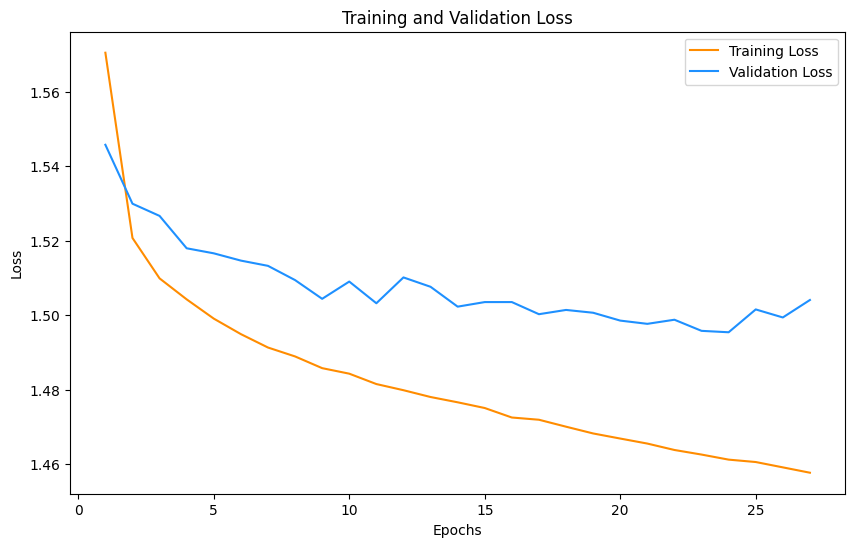

In [23]:

##
# this function is used to train the neural network that we are going to be using for classification of the items that 
# we are considering for insurance and for prisoners
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10, patience=2):
    best_val_loss = float('inf')
    patience_counter = 0

    # lists to store loss values for plotting
    train_losses = []
    val_losses = []
    epochs_list = []


    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        epoch_val_loss = val_loss / len(val_loader)
        # print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Val Loss: {epoch_val_loss}')

        train_losses.append(epoch_loss)
        val_losses.append(epoch_val_loss)
        epochs_list.append(epoch + 1)

        # check if the validation loss improved
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience_counter = 0
        
        else:
            patience_counter += 1

        # check for early stopping
        if patience_counter > patience:
            print("Stopping early due to increasing validation loss.")
            break

        # print the statistics from this epoch
        print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}, Val Loss: {val_loss / len(val_loader)}')

    # plotting the training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_list, train_losses, label='Training Loss', color=PLOT_COLOR_1)
    plt.plot(epochs_list, val_losses, label='Validation Loss', color=PLOT_COLOR_2)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    if SHOULD_SAVE_OUTPUT:
        plt.savefig(os.path.join(curr_run_dir, "nn_loss.png"))

    plt.show()


# define the criteria and optimizer that we are going to be using to train the neural network
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_model.parameters(), lr=0.001, weight_decay=1e-5)

# training the model
train_model(baseline_model, pca_train_loader, pca_val_loader, criterion, optimizer, epochs=30)

# saving the model to a state dictionary
if SHOULD_SAVE_OUTPUT:
    torch.save(baseline_model, os.path.join(curr_run_dir, BASELINE_SAVE_FILE_NAME))

In [24]:
# get the predictions of the validation data
def predict(model, data_loader):

    # set the model to evaluate
    model.eval()
    predictions = []

    model = model.to(device)

    # no gradients on this torch item
    with torch.no_grad():

        # all items in the data loader
        for inputs, _ in data_loader:

            inputs = inputs.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend((predicted.cpu() + 1).numpy())

    # return the predictions on the validation dataset
    return predictions



# fix it so that we get the pca version
# actually run the predictions of the model
test_preds = predict(baseline_model, pca_test_loader)

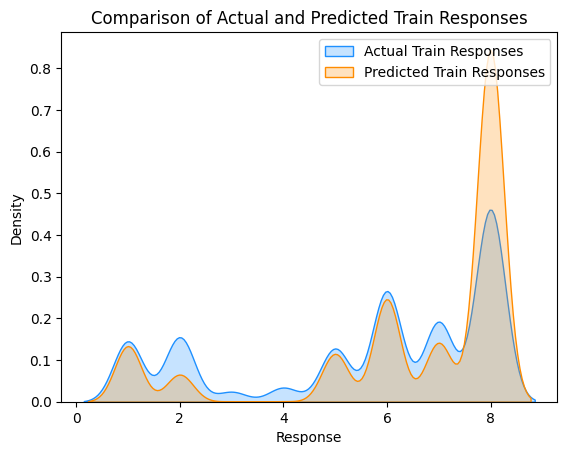

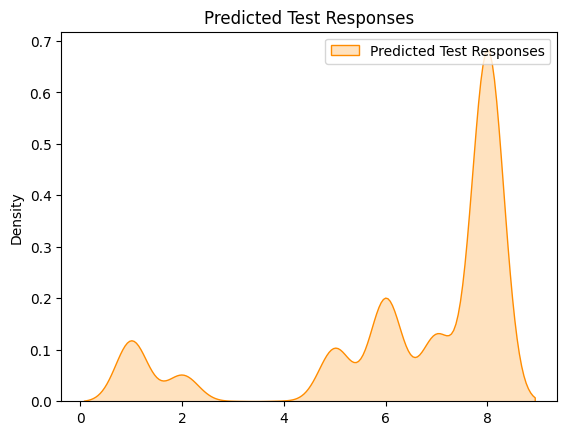

In [25]:
# get the distribution of the predicted values
y_train_pred = predict(baseline_model, pca_train_loader) 

sns.kdeplot(y_train, label='Actual Train Responses', fill=True, color=PLOT_COLOR_2)
sns.kdeplot(y_train_pred, label='Predicted Train Responses', fill=True, color=PLOT_COLOR_1)
plt.title('Comparison of Actual and Predicted Train Responses')
plt.legend()

if SHOULD_SAVE_OUTPUT:
	plt.savefig(dpi=300, fname=os.path.join(curr_run_dir, "base_nn_predicted_train.png"))

plt.show()

# For test predictions, assuming you have actual test responses
# sns.kdeplot(test['Response'], label='Actual Test Responses', fill=True, palette=PLOT_PALETTE)
sns.kdeplot(test_preds, label='Predicted Test Responses', fill=True, color=PLOT_COLOR_1)
plt.title('Predicted Test Responses')
plt.legend()

if SHOULD_SAVE_OUTPUT:
	plt.savefig(dpi=300, fname=os.path.join(curr_run_dir, "base_nn_predicted_test.png"))

plt.show()

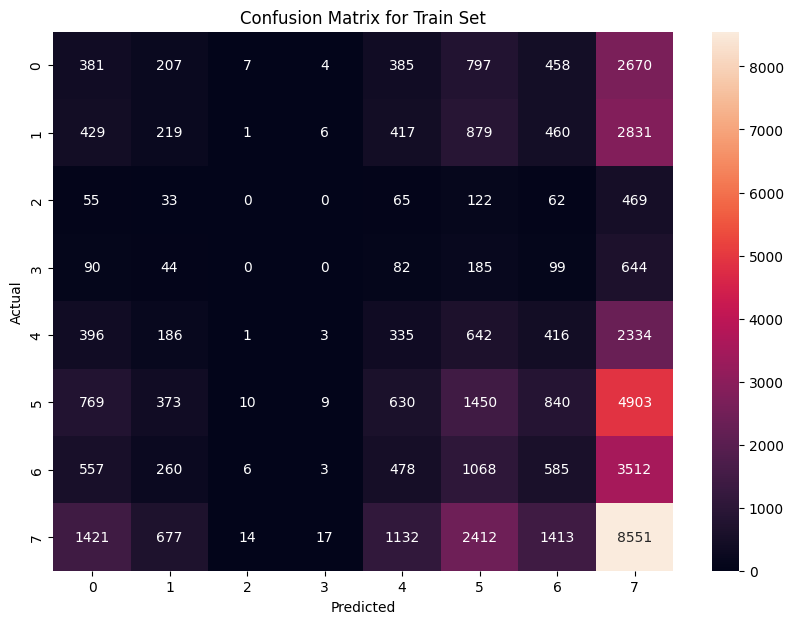

In [26]:
# confusion matrix
cm = confusion_matrix(y_train, y_train_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix for Train Set')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# save the confusion matrix output to a png file
if SHOULD_SAVE_OUTPUT:
	plt.savefig(os.path.join(curr_run_dir, "nn_conf_matrix.png"))

plt.show()

In [27]:
# getting the metrics for the test data
# accuracy = accuracy_score(y_train, np.rint(y_train_pred).astype(int))
# print("Train Accuracy: {:.2f}%".format(accuracy * 100))
# print("Kappa Cohen: {:.4f}".format(eval_wrapper(y_train, y_train_pred) * 100))
# print()

base_pred = [np.argmax(t_arr) for t_arr in baseline_model(pca_val_features.to(device)).cpu().detach().numpy()]
accuracy = accuracy_score(all_val_labels, base_pred)
print("Validation Accuracy: {:.2f}%".format(accuracy * 100))
print("Kappa Cohen: {:.4f}".format(eval_wrapper(all_val_labels, base_pred) * 100))

# getting the metrics for the training data
# accuracy = accuracy_score(final_test_preds, np.rint(test_preds).astype(int))
# print("Test Accuracy: {:.2f}%".format(accuracy * 100))
# print("Kappa Cohen: {:.2f}".format(eval_wrapper(final_test_preds, test_preds) * 100))

Validation Accuracy: 43.71%
Kappa Cohen: 41.0432


In [28]:
# # define a prediction function of probabilities for the model
# def predict_proba(data):
    
#     # set the model to eval mode
#     baseline_model.eval()  

#     # turn off the gradient
#     with torch.no_grad():
        
#         # apply the softmax to get the class output probabilities
#         m_output = baseline_model(torch.tensor(data, dtype=torch.float))
#         probabilities = torch.softmax(m_output, dim=0)
#         return probabilities.numpy()

# # initialize the explainer
# explainer = lime_tabular.LimeTabularExplainer(
#     training_data=np.array(X_train),
#     feature_names=X_train.columns.tolist(),
#     class_names=['1', '2', '3', '4', '5', '6', '7', '8'],  
#     mode='classification'  
# )

# # explain a prediction from the validation set
# data_batch, labels_batch = next(iter(pca_train_loader))
# data_row = data_batch[0]

# for data_batch, labels_batch in pca_train_loader:
#     print("Batch data shape:", data_batch.shape)
#     print("Batch label shape:", labels_batch.shape)
#     break

# # convert the array to numpy if it is not already
# if hasattr(data_row, "numpy"):
#     data_row = data_row.numpy()

# # reshape it
# # data_row = data_row.reshape(1, -1)

# # get the shape
# print(f"data row shape: {data_row.shape}")

# # check with the proba
# # print(predict_proba(data_row))

# explanation = explainer.explain_instance(
#     data_row=data_row, 
#     predict_fn=predict_proba 
# )

# # visualize the explanation
# explanation.show_in_notebook(show_table=True, show_all=False)

# # Extracting explanation details
# exp_list = explanation.as_list()
# print(f"Explanation for instance {pred_idx_to_explain}:\n")
# for feature, effect in exp_list:
#     print(f"{feature}: {effect:.4f}")

# # Optionally, summarize the effect in terms of top features
# print("\nSummary:")
# print("Positive features (pushing towards class 1):")
# for feature, effect in filter(lambda x: x[1] > 0, exp_list):
#     print(f"  {feature}: {effect:.4f}")

# print("Negative features (pushing towards class 0):")
# for feature, effect in filter(lambda x: x[1] < 0, exp_list):
#     print(f"  {feature}: {effect:.4f}")


In [127]:
# These are the functions for computing the relative importance of nodes in a neural network to the output
# of the model across all of the tested input data


# this function computes the relevance of a single node+feature combination in the neural network
# layer_num: this is the layer number of the node that we are targeting
# feature_num: the number of the node that we want to minimize the importance of
# def compute_single_feature_importance(input_model, data_loader, layer_num, feature_num):
def compute_importance_GRAD(input_model, data_loader):

	# go through and get the one-hot importance of each input
	loss_func = nn.CrossEntropyLoss()

	# setting model to train
	input_model.train()

	input_model = input_model.to(device)
		
	# array to keep track of all of the gradients in the model
	total_gradient_list = None

	# the number of batches that we consider
	number_considered = 0

	# compute the gradients
	for input_data, input_label in data_loader:

		input_data = input_data.to(device)
		input_label = input_label.to(device)
		
		# keep track of the gradients of this instance
		instance_grads = []

		# set the gradients of the model to zero
		input_model.zero_grad()

		# get the output from the model
		model_guess = input_model(input_data)

		# compute the loss
		r_loss = loss_func(model_guess, input_label)

		# backpropagate the error
		r_loss.backward()

		# keep track of the gradients
		for name, param in input_model.named_parameters():

			# check if this is something that we should consider
			if 'weight' in name and param.grad is not None:

				# store the abs gradients
				# print(f"Grad shpae: {param.grad.abs().shape}")
				instance_grads.append(param.grad.abs() * param.data.abs())
				
				# if param.data.abs().shape == (32, 10):
				# 	print(param.grad.abs())
				# 	print(param.data.abs())
				# 	print(instance_grads[-1])
				# 	# print('hi')
				# 	return


		# check if this is an empty list
		if total_gradient_list is None:

			# add all of the gradients together
			total_gradient_list = []

			for l_idx, instance_entry in enumerate(instance_grads):

				# create zero versions of all of the gradient entries
				total_gradient_list.append(torch.zeros_like(instance_entry.mean(dim=0)))

		# update the total gradient list
		for l_idx, instance_entry in enumerate(instance_grads):

			# add the mean of the gradient
			# total_gradient_list[l_idx] += torch.clamp(instance_entry, min=0).mean(dim=0)
			# print(instance_entry.shape)
			# print(torch.abs(instance_entry).mean(dim=0).shape)
			# print(instance_entry)
			# print(torch.abs(instance_entry).mean(dim=0))
			# print(l_idx)
			total_gradient_list[l_idx] += torch.abs(instance_entry).mean(dim=0)

		# increment the number of examples that we have considered
		number_considered += 1

		# if number_considered > 10:
		# 	print(total_gradient_list)
		# 	break

	# average out the relevances
	total_gradient_list = [relevance / (number_considered) for relevance in total_gradient_list]

	# dot with the weights

	# normalize all of the layers
	total_gradient_list = [t_layer / t_layer.sum() for t_layer in total_gradient_list]

	# return the initial layer relevance
	# total_gradient_list.reverse()
	return [r.cpu().numpy() for r in total_gradient_list]	




# define a function to get the importance of some input feature or node that we want to target
# it effectively uses a method for layer relevance propagation
# and takes the average relevance over all of the input data that we can give it
# input_model: this is the model that we are going to compute the importance in 
def compute_importance_LRP(input_model, data_loader):

	# go through and get the one-hot importance of each input
	# loss_func = nn.CrossEntropyLoss()

	input_model.eval()

	# go through and add the hooks that take care of logging the activations
	# and the outputs of the layers that we are considering
	layer_activations = []

	all_layer_avg_relevances = None
	number_considered = 0

	# this adds a hook to each layer of the model to get the activation
	def forward_hook(module, input, output):

		# add to the linear and relus only
		if isinstance(module, nn.ReLU) or isinstance(module, nn.Linear):
			layer_activations.append(output)


	# add the hooks to the model
	model_layer_hooks = []

	# iterate the layers
	for layer in input_model.modules():

		if isinstance(layer, nn.ReLU) or isinstance(layer, nn.Linear):
			
			# register the hook
			t_hook = layer.register_forward_hook(forward_hook)
			model_layer_hooks.append(t_hook)


	# setting model to train
	input_model.train()
		
	# array to keep track of all of the gradients in the model
	total_gradient_list = []

	# compute the gradients
	for input_data, input_label in data_loader:

		# set the gradients of the model to zero
		input_model.zero_grad()

		# # get the output from the model
		# model_guess = input_model(input_data)

		# # compute the loss
		# r_loss = loss_func(model_guess, input_label)

		# # backpropagate the error
		# r_loss.backward()

		# # keep track of the gradients
		# for param in input_model.parameters():
				
		# 		# check if this is something that we should consider
		# 		if param.grad is not None:
					
		# 			# store the abs gradients
		# 			total_gradient_list.append(param.grad.abs())

		# get no gradient
		with torch.no_grad():
			
			# get the output from the model
			model_guess = input_model(input_data)
		
		# now get the relevance with respect to this input and update the mean values
		layer_relevance = model_guess
		instance_total_layer_activations = [layer_relevance.clone().mean(dim=0)]

		
		# # initialize all of the relevances if this has not been called yet
		# if all_layer_avg_relevances is None:
		# 	all_layer_avg_relevances = [torch.zeros_like(act) for act in layer_activations]

		# getting the number of activations
		# print(f"Number of layer activations: {len(layer_activations)}")
		

		# iterate through all of the possible activations in the model
		for i in range(len(layer_activations)-1, -1, -1):

			# print(f"Checking layer {i}")

			# get the current and previous activations to get the relevance
			current_activation = layer_activations[i]
			previous_activation = layer_activations[i-1] if i > 0 else input_data

			# get the current layer of the model
			current_layer = list(input_model.children())[i]

			# look for the linear weights to propagate the relevance
			if isinstance(current_layer, nn.Linear):
				
				# get the weights of the model
				weights = current_layer.weight.data

				# this applies the z-rule to the layer to compute the resulting relevances
				# print(f"processing: {previous_activation.shape} {torch.clamp(weights, min=0).T.shape}")
				z_rule_z_val = torch.matmul(previous_activation, torch.clamp(weights, min=0).T) + 1e-10
				z_rule_s_val = layer_relevance / z_rule_z_val
				z_rule_c_val = torch.matmul(z_rule_s_val, torch.clamp(weights, min=0))
				
				# propagate relevance to the previous layer
				layer_relevance = previous_activation * z_rule_c_val 
				
				# print(f"previous_activation length: {len(previous_activation)}")
				# print(f"z_rule_c_val: {z_rule_c_val.shape}")
				# print(f"layer_relevance shape: {layer_relevance.mean(dim=0).shape}")

			# add the relevance to the array
			instance_total_layer_activations.append(layer_relevance.mean(dim=0))

		
		
		# if we have not added anything then just make these values the relevance values
		if not all_layer_avg_relevances:
			# all_layer_avg_relevances = instance_total_layer_activations
			all_layer_avg_relevances = [torch.zeros_like(a) for a in instance_total_layer_activations]
		
		# otherwise then compute the new averages
		for l_idx, layer_rel in enumerate(instance_total_layer_activations):
			
			# print(f"{instance_total_layer_activations[l_idx].shape}")
			all_layer_avg_relevances[l_idx] += layer_rel.mean(dim=0)

		# increment the number of examples that we have considered
		number_considered += 1

		# clear the layer activations
		layer_activations.clear()

	# average out the relevances
	dat, _ = next(iter(data_loader))
	batch_size = dat.shape[0]
	all_layer_avg_relevances = [relevance / (number_considered) for relevance in all_layer_avg_relevances]


	# remove all of the hooks from the model
	for t_hook in model_layer_hooks:
		t_hook.remove()

	# return the initial layer relevance
	all_layer_avg_relevances.reverse()
	return [r.cpu().numpy() for r in all_layer_avg_relevances]	



In [30]:
# define a function that can find the inverse matrix that we use for the mahalanobis distance over
# the entire dataset that we are currently considering
def mahalanobis_distance_matrix(all_data):

    # print status
    print("Computing Mahalanobis Matrix...")

    # check the data type to make sure that it is good
    if not isinstance(all_data, torch.Tensor):
        all_data = torch.tensor(all_data, dtype=torch.float)
    
    # # get the mean of all of the data that we are considering
    # mean = torch.mean(all_data, dim=0)
    
    # calculate the covariance matrix and its inverse
    cov_matrix = torch.cov(all_data.t())
    inv_cov_matrix = torch.inverse(cov_matrix)
    
    # return the inverse covariance matrix 
    return inv_cov_matrix

# function that computes the mahalanobis distance between two data points
# make sure that you pass a mahalanobis_cov_matrix matrix
# the mahalanobis_cov_matrix matrix should be the inverse covariance matrix
def compute_mahalanobis(data_1, data_2, mahalanobis_cov_matrix, verbose=0):

    data_1 = data_1.to('cpu')
    data_2 = data_2.to('cpu')

    # print the shapes
    if verbose:
        print(f"Shape of data_1: {data_1.shape}")
        print(f"Shape of data_2: {data_2.shape}")

    # compute the delta that we are going to put into the equation
    t_delta = data_2 - data_1 

    # get whether we should be verbose with this function or not
    if verbose:
        print(f"Shape of t_delta: {t_delta.shape}")
        print(f"mahalanobis_cov_matrix: {mahalanobis_cov_matrix.shape}")
        print()
    
    # compute Mahalanobis distance from the selected point to all other points
    part_1 = torch.matmul(t_delta, mahalanobis_cov_matrix)

    # get the second part of the equation
    part_2 = torch.matmul(part_1, t_delta.t())

    # if this is a float then return that
    if part_2.dim() > 0:
        diagonal = torch.diag(part_2)
    else:
        # if it is a matrix then return the matrix
        diagonal = part_2

    # get the sqrt
    m_distances = torch.sqrt(diagonal)
        
    # check if it is an instance of a tensor or not
    if not isinstance(m_distances, torch.Tensor):
        m_distances = torch.tensor(m_distances)

    if verbose:
        print(f"diagonal: {diagonal}")
        print(f"m_distances: {m_distances}")

    return m_distances


# define a function that gets the centroids of k clusters that I would get 
# if I ran a k-means clustering algorithm
def k_means_centers(input_features, cluster_num = 5):

    # convert all_features tensor to numpy for k-means
    features_np = input_features.cpu().detach().numpy()

    # run k-means clustering
    print(f"Computing KMeans...")
    kmeans = KMeans(n_clusters=cluster_num, random_state=0).fit(features_np)

    # extract centroids
    centroids = kmeans.cluster_centers_

    # convert centroids back to PyTorch tensor
    centroids_tensor = torch.tensor(centroids, dtype=torch.float32)

    # return the centroids that we get from the model that we have run
    return centroids_tensor


# getting the hierarchical clustering of the data which in some cases can prove to provide more information and 
# fidelity than k means clustering alone
def hierarchical_clustering(input_features, n_clusters=5):
    
    print(f"Computing Hierarchical Clustering...")

    # define the model and fit it
    clustering_model = AgglomerativeClustering(n_clusters=n_clusters)
    clustering_model.fit(input_features)

    # get the labels for the clusters (the centroids)
    labels = torch.tensor(clustering_model.labels_, dtype=torch.float32)

    return labels


# getting the dbscan centroids for the clustering of the data
def dbscan_clustering(input_features, eps=0.5, min_samples=5):
    
    print(f"Computing DBScan Clustering...")

    # define a model that we can use
    clustering_model = DBSCAN(eps=eps, min_samples=min_samples)
    clustering_model.fit(input_features)

    # return the labels (centroids)
    labels = torch.tensor(clustering_model.labels_, dtype=torch.float32)
    return labels


# another clustering method for finding blobs in a smooth density of samples
def mean_shift_clustering(input_features, bandwidth=None):
    
    print(f"Computing Mean Shift Clustering...")

    # def model for shifting the mean
    clustering_model = MeanShift(bandwidth=bandwidth)
    clustering_model.fit(input_features)

    # get the centroids of the data
    labels = torch.tensor(clustering_model.labels_, dtype=torch.float32)
    return labels

In [31]:
# now plot the regression histogram for the base model
# start correlation analysis with just a plain node correlation
# empty list for features
features_list = []

# keep track of the max distance
max_mahalanobis = 0


# getting all of the training data for correlation analysis
for features, _ in pca_train_loader:

    # move the features to the device
    # features = features.to(device)

    # add it to the features list
    features_list.append(features)


# concatenate all of the inputs that we are going to be using together
all_features = torch.cat(features_list, dim=0)



# get the centroids with that method
if clustering_method_name == 'k_means_centers':
    k_means_centers_variable = k_means_centers(pca_train_features, cluster_num=CLUSTER_NUM)



# move the covariance matrix to the right device
pca_mahalanobis_covariance_matrix = mahalanobis_distance_matrix(pca_train_features)
# pca_mahalanobis_covariance_matrix = pca_mahalanobis_covariance_matrix.to('cpu')

# array of all of the m distances that we are going to use
all_mahalanobis = []

# use tqdm to wrap the outer loop for a progress bar
for t_feature in tqdm(all_features, desc="Computing Mahalanobis distances"):

    # temp arr for mahalanobis distances corresponding to the distance from each of the K points from the clustering above
    t_m_arr = []

    # append all of the mahalanobis values
    for t_m_dist in k_means_centers_variable:

        # get the mahalanobis distance
        m_dist = compute_mahalanobis(t_m_dist, t_feature, pca_mahalanobis_covariance_matrix)

        # check whether this is a new max distance or not
        max_mahalanobis = max(abs(max_mahalanobis), m_dist)

        t_m_arr.append(m_dist)

    # store the distances
    all_mahalanobis.append(t_m_arr) 

# clear all of the intermediates in the model
global network_layer_outputs
clear_total_run()


Computing KMeans...
Computing Mahalanobis Matrix...


Computing Mahalanobis distances: 100%|██████████| 47504/47504 [00:03<00:00, 11997.83it/s]


Creating regression between variables...: 100%|██████████| 32/32 [00:13<00:00,  2.45it/s]


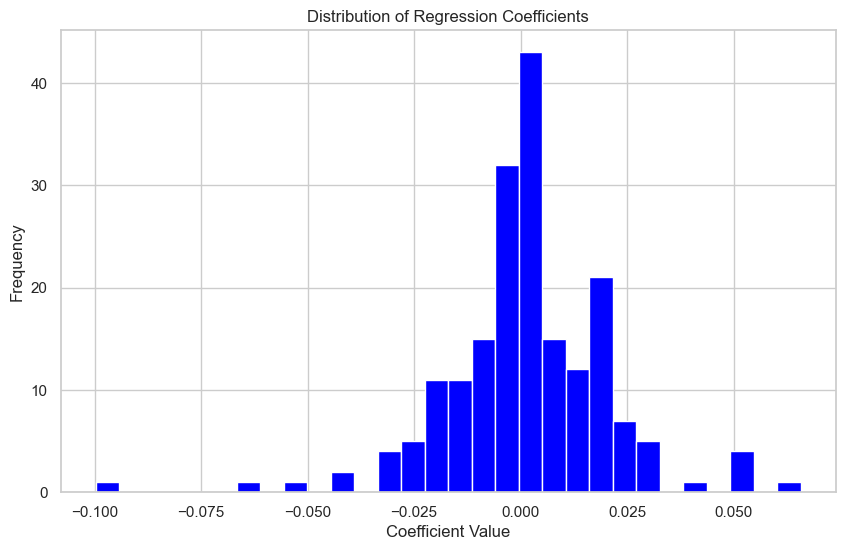

Coefficients Shape: (32, 6)


In [137]:


# keep track of the max distance
max_mahalanobis = 0

# move the model
baseline_model = baseline_model.to(device)

features_list = []

start_new_pass_through()
clear_total_run()

# getting all of the training data for correlation analysis
for features, _ in pca_train_loader:

    # move the features to the device
    # features = features.to(device)

    # add it to the features list
    features_list.append(features)

    # pipe it through the model
    outputs = baseline_model(features.to(device))
    
    # save the current passthrough to the list
    save_and_clear_current_pass_through()

# now get all of the outputs
baseline_model_intermediates = network_layer_outputs
clear_total_run()


# layer that we are considering
LAYER_IDX = 1

# the coefficients for the regressions that I am running
coefficients = []  
max_abs_coefficients = []
avg_abs_coefficients = []
max_lower_bounds = []
max_upper_bounds = []
avg_lower_bounds = []
avg_upper_bounds = []

# go through each of the intermediate variables in the model and collect them
for i in tqdm(range(len(baseline_model_intermediates[0][LAYER_IDX][0])), desc="Creating regression between variables..."):

    # now we are going to get the ith element of the array
    current_node = []

    # adding all of the model intermediate values in 
    for j in range(len(baseline_model_intermediates)):
        for t_element in baseline_model_intermediates[j][LAYER_IDX][:, i]:
            current_node.append(t_element)


    # perform a regression between this element and the centroid distances

    # initialize a Linear Regression model
    linrg_model = LinearRegression()

    # convert the arrays to np arrays
    all_mahalanobis = np.array(all_mahalanobis)
    current_node = np.array(current_node)

    # print an update
    # print(f"Performing regression {i} between all_mahalanobis and current_node...")
    # print(f"Current Dimensions:\nall_mahalanobis shape{all_mahalanobis.shape}\ncurrent_node shape{current_node.shape}")

    # fit the regression
    linrg_model.fit(all_mahalanobis, current_node)


    # getting the maximum coefficient in the model
    max_abs_coef_index = np.argmax(np.abs(linrg_model.coef_))
    max_abs_model_coefficient = np.abs(linrg_model.coef_[max_abs_coef_index])
    max_abs_coefficients.append(max_abs_model_coefficient)


    avg_abs_coefficients.append(np.mean(np.sort(np.abs(linrg_model.coef_))[::-1][:3]))

    
    
    # get the residuals and the standard error
    bound_preds = linrg_model.predict(all_mahalanobis)
    resid_vals = np.sum((current_node - bound_preds)**2)
    model_standard_error = np.sqrt(resid_vals / (len(current_node) - 2)) /  np.sqrt(np.sum((all_mahalanobis - np.mean(all_mahalanobis))**2))

    # now compute the 95% confidence bound for the model
    df = len(current_node) - 2
    t_critical = stats.t.ppf(1-0.025, df)

    # append the upper and lower bounds to the arrays that we are using to keep track
    ci_lower = max_abs_model_coefficient - t_critical * model_standard_error
    ci_upper = max_abs_model_coefficient + t_critical * model_standard_error
    avg_ci_lower = avg_abs_coefficients[-1] - t_critical * model_standard_error
    avg_ci_upper = avg_abs_coefficients[-1] + t_critical * model_standard_error


    # naive average bounds -- FIX ME
    avg_lower_bounds.append(avg_ci_lower)
    avg_upper_bounds.append(avg_ci_upper)
        
    max_lower_bounds.append(ci_lower)
    max_upper_bounds.append(ci_upper)
        
    # store the coefficient
    coefficients.append(linrg_model.coef_)





# plot the regression coefficients so that we can see what they are doing in the model
coefficients = np.array(coefficients)  

# flatten the array to get a single visualization
flat_coefficients = coefficients.flatten()

sns.set_theme(style="whitegrid")
sns.set_palette("magma")

# plot the information that we got
plt.figure(figsize=(10, 6))
plt.hist(flat_coefficients, bins=30, color='blue')
plt.title('Distribution of Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Frequency')

if SHOULD_SAVE_OUTPUT:
    os.makedirs(os.path.join(curr_run_dir, "baseline_coeff_hist_plots"), exist_ok=True)
    plt.savefig(dpi=300, fname=os.path.join(curr_run_dir, "baseline_coeff_hist_plots", "baseline_reg_coeff_dist_hist.png"))

plt.show()


# now go through and make subplots for everything that we are doing
print(f"Coefficients Shape: {coefficients.shape}")


# getting the node importances
baseline_importances = compute_importance_GRAD(baseline_model, pca_train_loader)


# get the right layer idx from the importance values
layer_baseline_importances = baseline_importances[LAYER_IDX]

# get the number of coefficients for creating subplots
n_coeffs = coefficients.shape[1]

# labels of the coefficients
coeff_labels = [f"Distance_{x}" for x in range(coefficients.shape[1])]

# getting the minimum and the maximum value of the regressions
ymin = np.min(coefficients)
ymax = np.max(coefficients)

# create arrays that have the maximum absolute value coefficien tfrom each of them
# sort the arrays on the max vals now
max_baseline_max_abs_values = np.array(max_abs_coefficients)
max_baseline_sorted_indices = np.argsort(-max_baseline_max_abs_values)


# sort the elements on the argument order
max_baseline_sorted_max_abs_values = max_baseline_max_abs_values[max_baseline_sorted_indices]
max_baseline_sorted_lower_bounds = np.array([max_lower_bounds[i] for i in max_baseline_sorted_indices])
max_baseline_sorted_upper_bounds = np.array([max_upper_bounds[i] for i in max_baseline_sorted_indices])
max_baseline_sorted_importance_values = np.array([layer_baseline_importances[i] for i in max_baseline_sorted_indices])


Plotting regression coefficients:   0%|          | 0/32 [00:00<?, ?it/s]

Plotting regression coefficients:  62%|██████▎   | 20/32 [00:05<00:03,  3.64it/s]/var/folders/d2/lsvbp7p92gnc5ql59sc72rx40000gn/T/ipykernel_99019/4001684477.py:16: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.

Plotting regression coefficients: 100%|██████████| 32/32 [00:08<00:00,  3.62it/s]


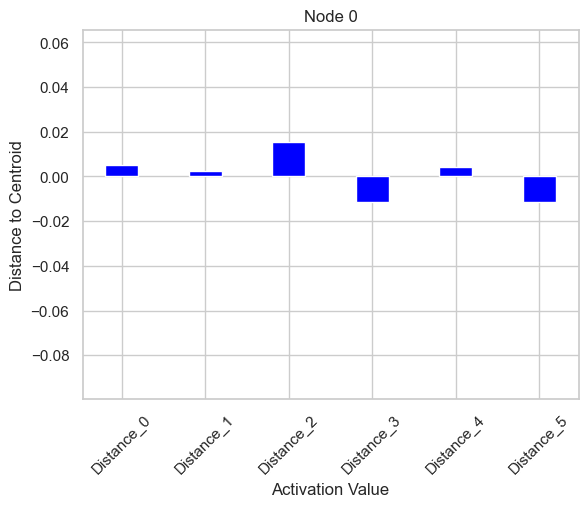

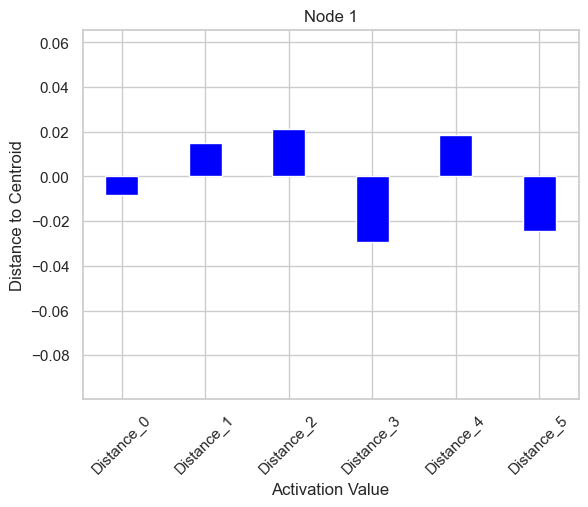

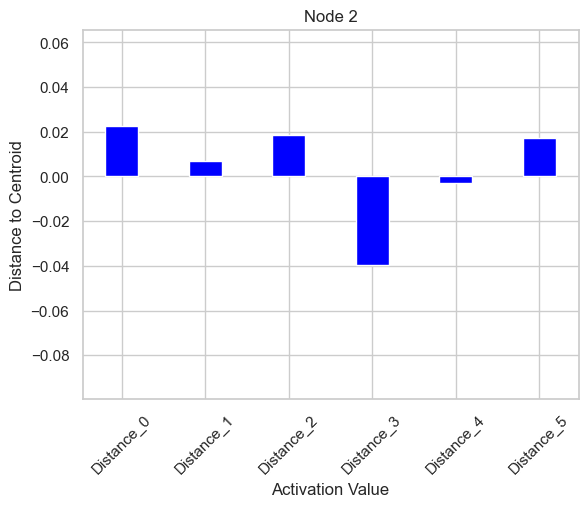

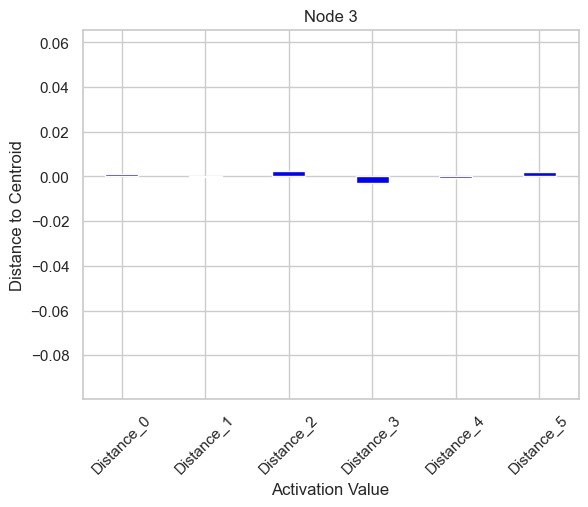

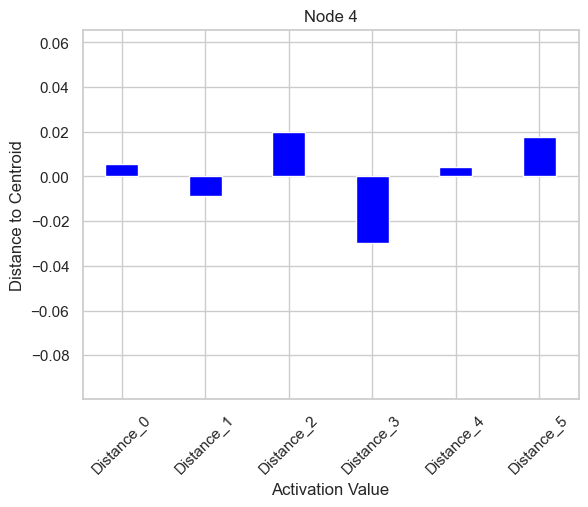

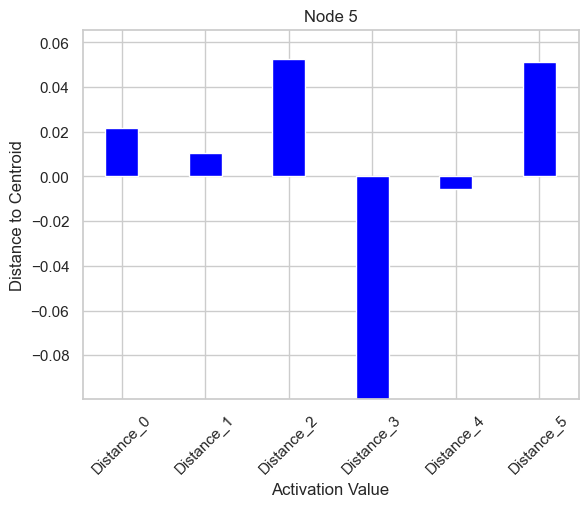

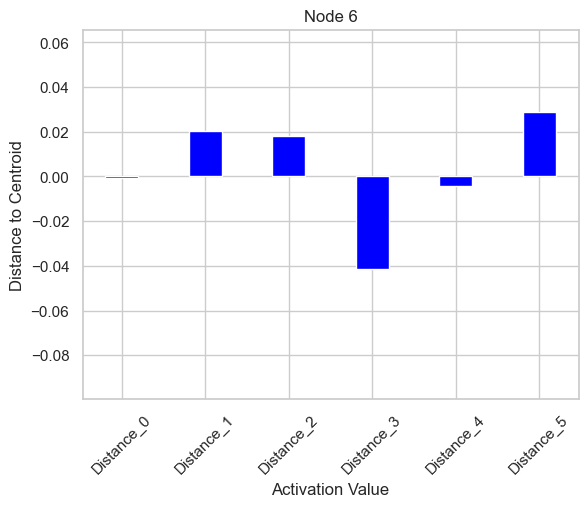

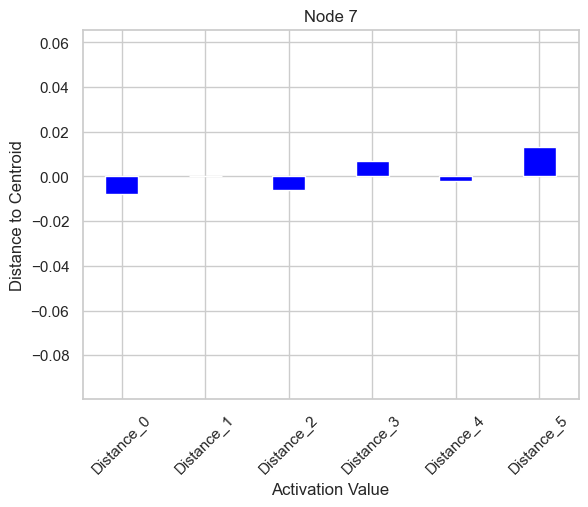

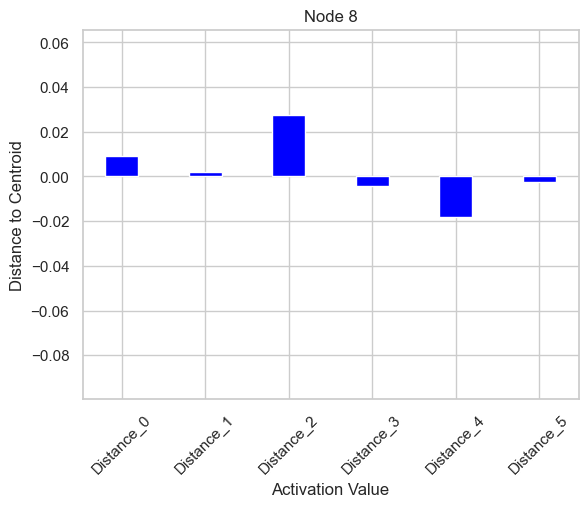

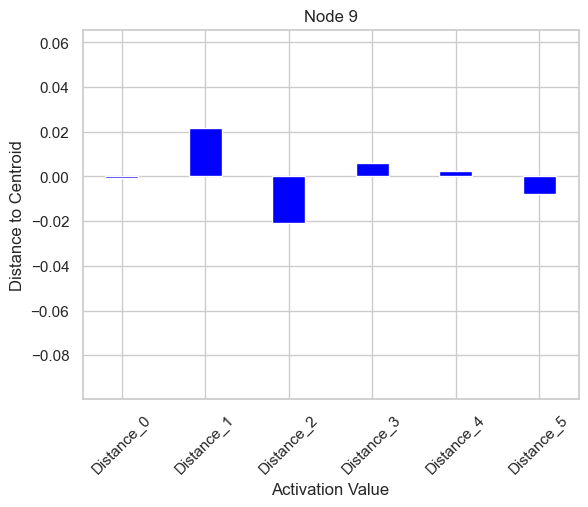

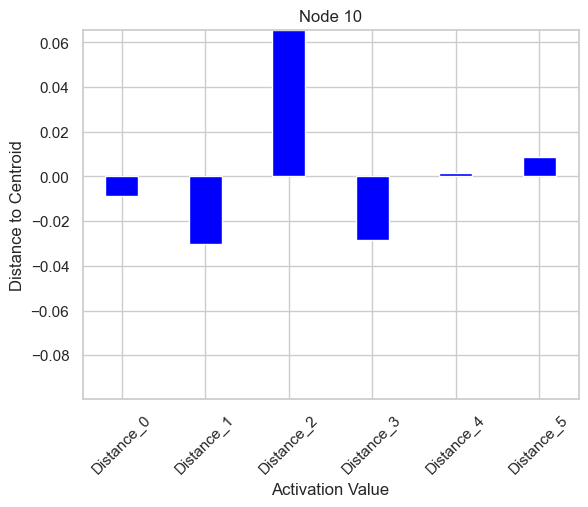

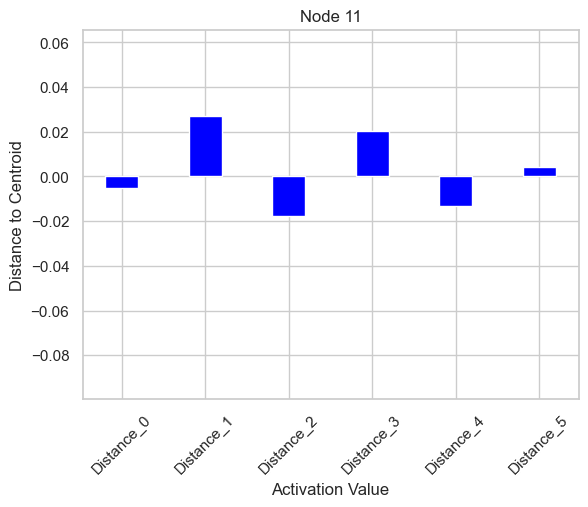

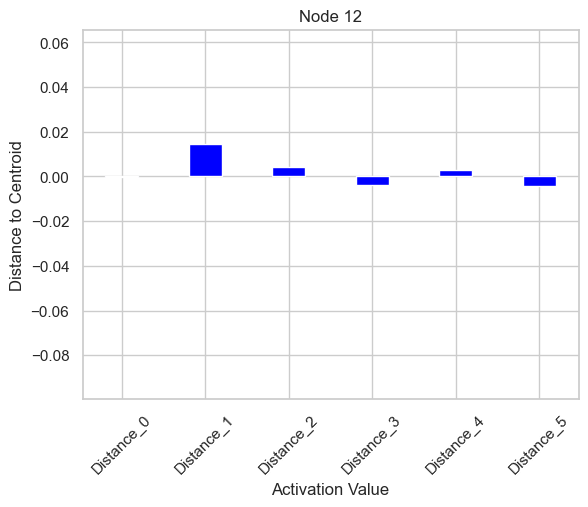

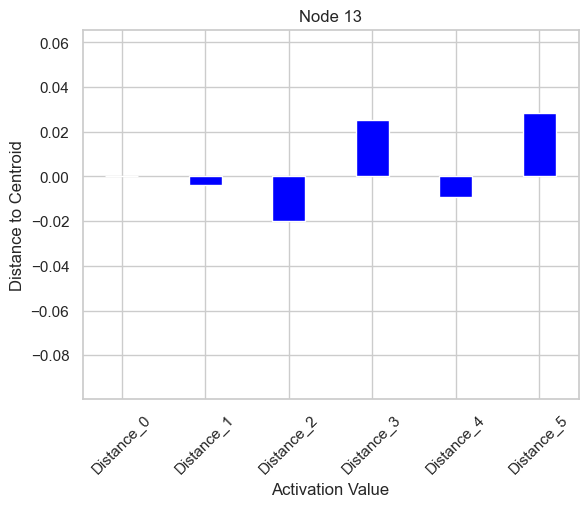

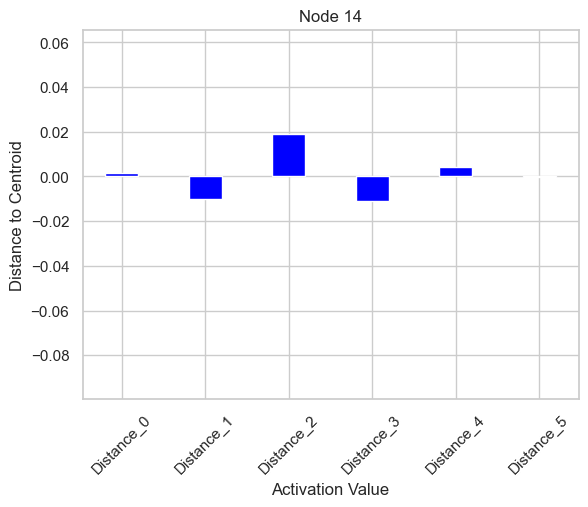

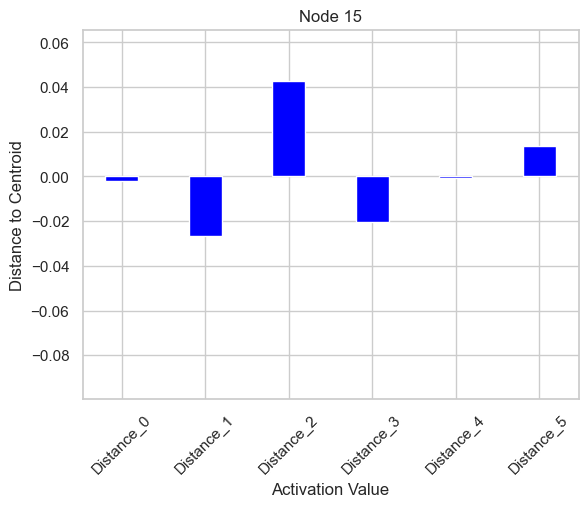

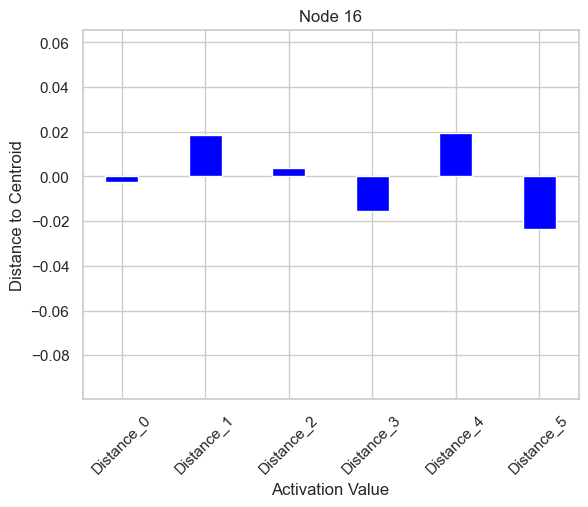

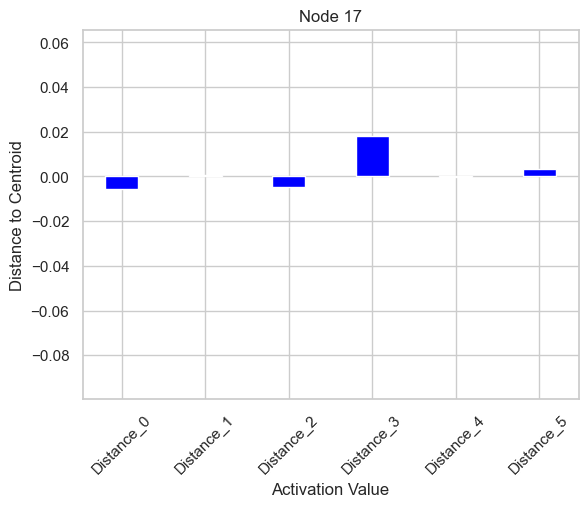

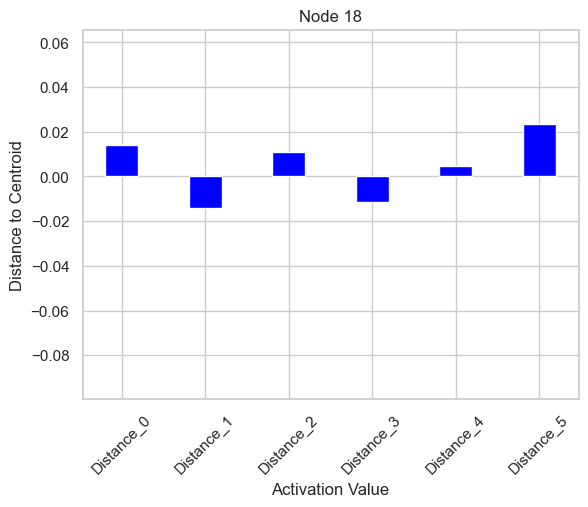

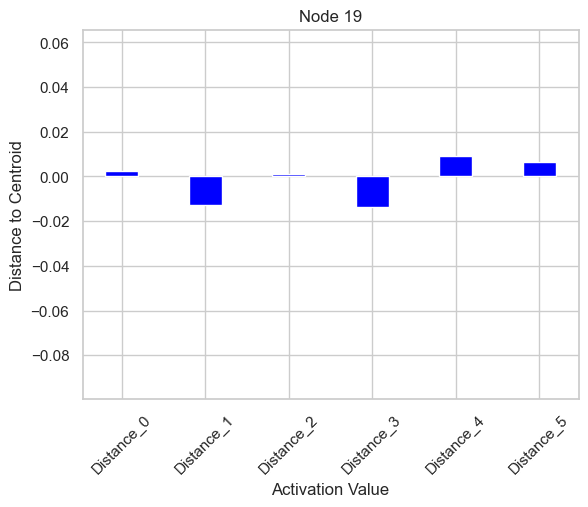

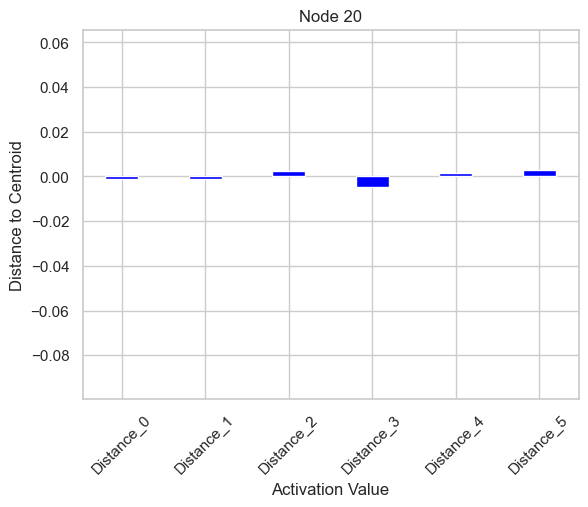

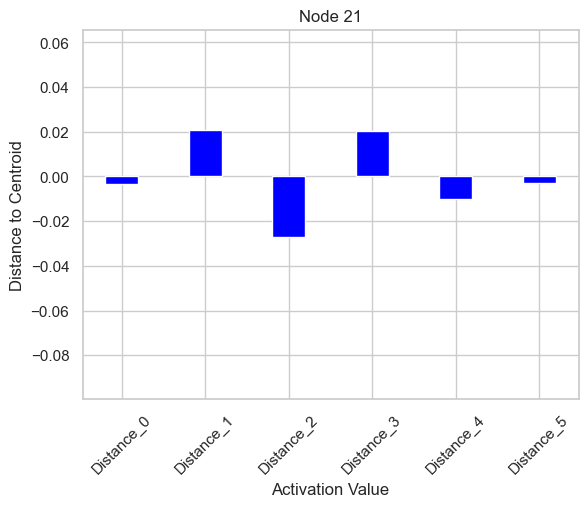

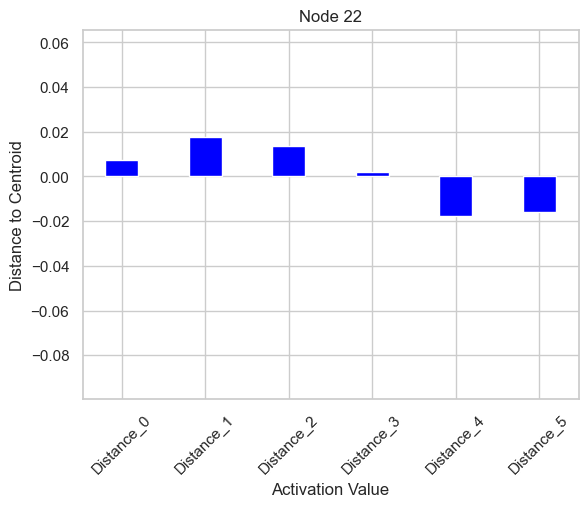

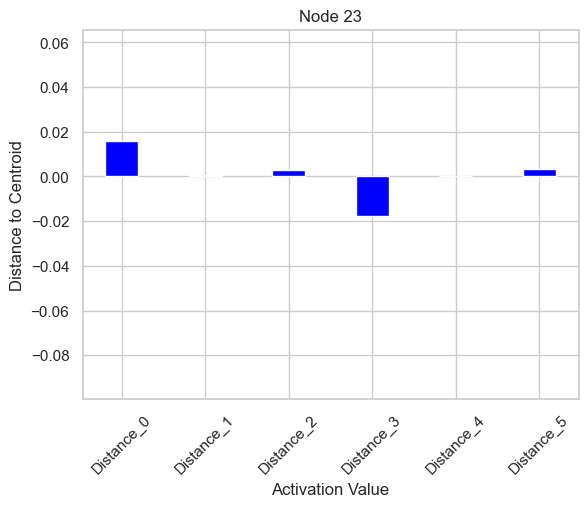

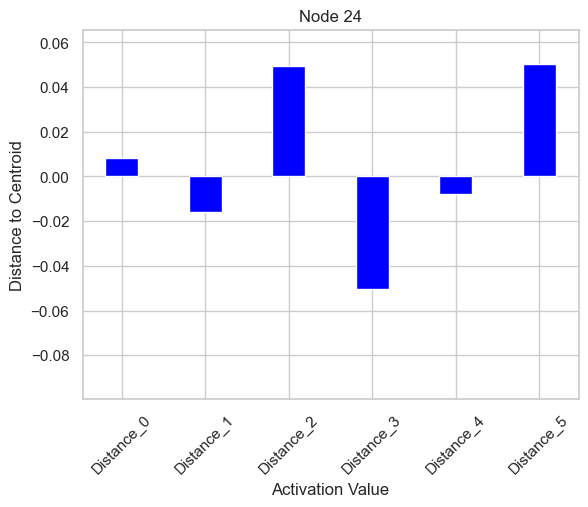

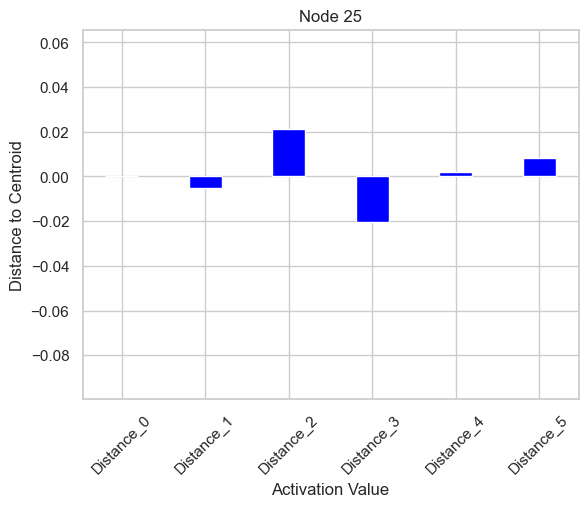

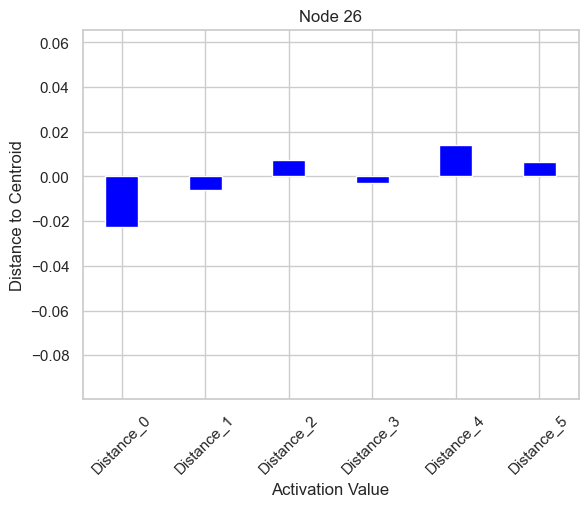

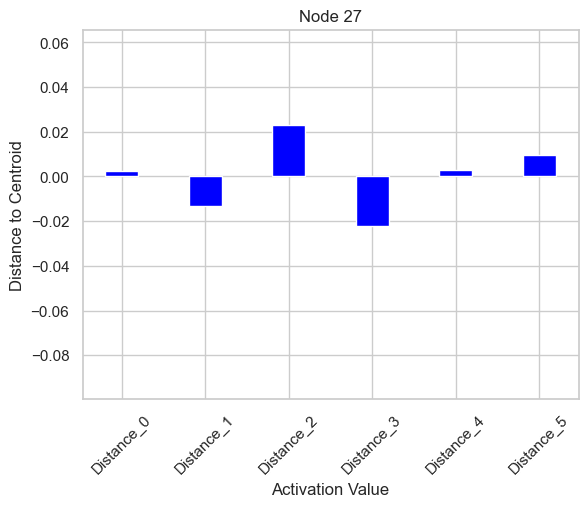

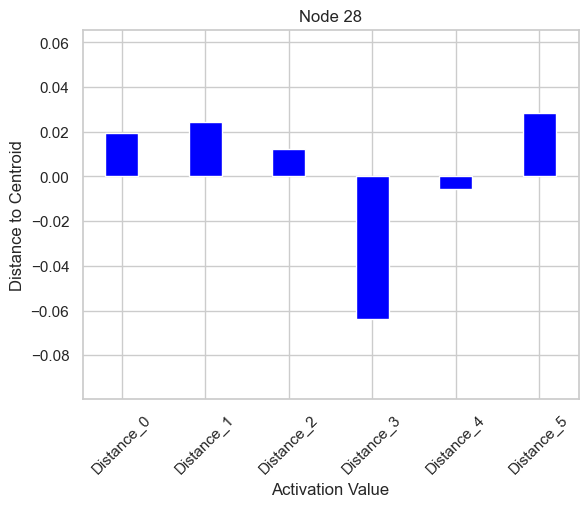

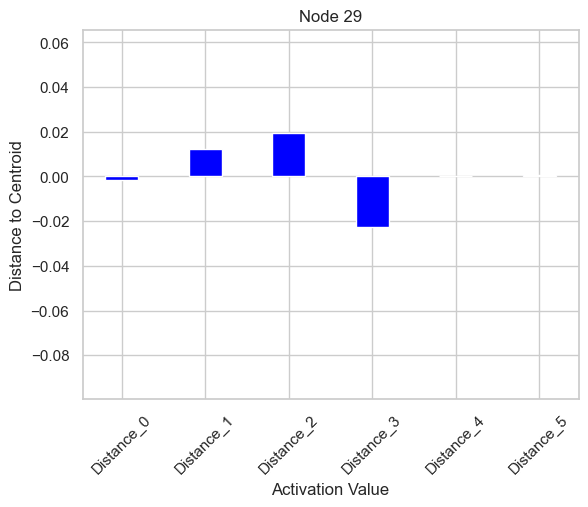

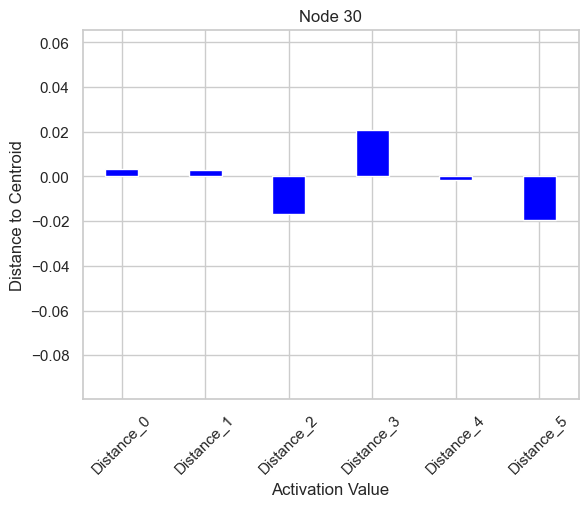

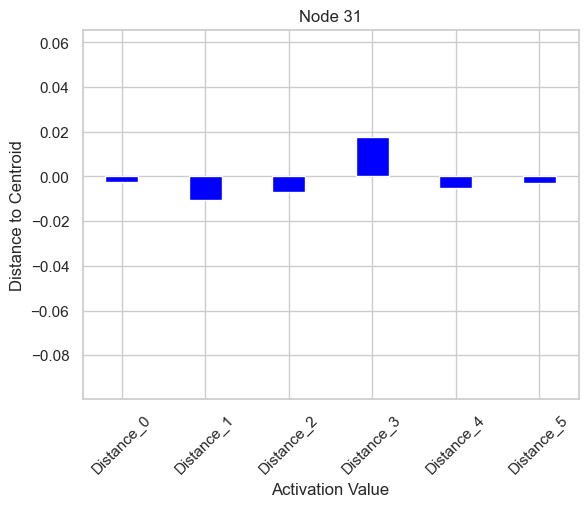

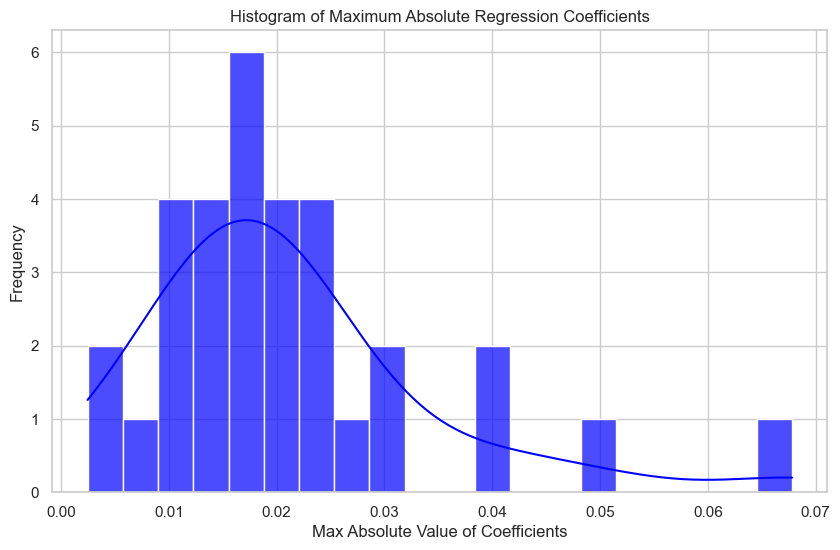

In [138]:


# now do the average version
avg_baseline_avg_abs_values = np.array(avg_abs_coefficients)
avg_baseline_sorted_indices = np.argsort(-avg_baseline_avg_abs_values)


# sort the elements on the argument order
avg_baseline_sorted_avg_abs_values = avg_baseline_avg_abs_values[avg_baseline_sorted_indices]
avg_baseline_sorted_lower_bounds = np.array([avg_lower_bounds[i] for i in avg_baseline_sorted_indices])
avg_baseline_sorted_upper_bounds = np.array([avg_upper_bounds[i] for i in avg_baseline_sorted_indices])
avg_baseline_sorted_importance_values = np.array([layer_baseline_importances[i] for i in avg_baseline_sorted_indices])


# iterate through each of the possible coefficients that we are going to consider
for coeffs_idx in tqdm(range(coefficients.shape[0]), desc="Plotting regression coefficients"):
    
    plt.figure()

    # get the coefficients for that node in the matrix
    # plot on some subplot
    plt.bar(coeff_labels, coefficients[coeffs_idx], color ='blue', width = 0.4)
    
    # get the labeling information for the graph
    plt.title(f'Node {coeffs_idx}')
    plt.xlabel('Activation Value')
    plt.ylabel('Distance to Centroid')
    plt.xticks(rotation=45)

    # scale the y axis
    plt.ylim(ymin, ymax)

    if SHOULD_SAVE_OUTPUT:
        os.makedirs(os.path.join(curr_run_dir, "baseline_coeff_hist_plots"), exist_ok=True)
        plt.savefig(dpi=300, fname=os.path.join(curr_run_dir, "baseline_coeff_hist_plots", f"baseline_plt_coeff_{coeffs_idx}_node.png"))

    

# show the figure that we constructed
plt.show()


# plot the histrogram
plt.figure(figsize=(10, 6))
sns.histplot(avg_baseline_sorted_avg_abs_values, bins=20, kde=True, color='blue', alpha=0.7)
plt.title('Histogram of Maximum Absolute Regression Coefficients')
plt.xlabel('Max Absolute Value of Coefficients')
plt.ylabel('Frequency')  

if SHOULD_SAVE_OUTPUT:
	plt.savefig(dpi=300, fname=os.path.join(curr_run_dir, "baseline_coeff_hist_plots", "baseline_abs_coeff.png"))
     
plt.show()


In [34]:
# getting the difference in standard error bar sizes
delta = max_baseline_sorted_upper_bounds - max_baseline_sorted_lower_bounds

print(f"Mean error bar size: {delta.mean()}")

Mean error bar size: 0.011258120246773102


### Baseline Neural Network Results

The neural network does substantially better on the training data. We can see in the distribution of the data above that the predicted and the actual values match one another much more closely than the XGBoost model. Empirically, we have verified the commonly held belief that neural networks are better able to capture complex, nonlinear data which supports the need for more metrics specifically adapted to neural networks explainability. 
<!-- 
| Metric            |   Value    |
|:------------------|:----------:|
| Train Accuracy    |   52.89%   |
| Kappa Cohen (Train) |   65.10    | -->

Additionally, the LIME calculation for the model does not yield much actionable insight that we can use. Many of the results that the LIME model gives us have such extreme values with low numbers of data points informing their creation that I would be hesitant to apply their results. 

# Start of Custom Loss Function

This is the start of the custom loss function that we are going to integrate for the explainability of the neural network. Recall from the proposal that the format for this loss function will be 

$$L(i) = L_{\text{base}} + \lambda \times e^{\alpha^{i}} \times L_{\text{layer-wise}} + \beta \times L_{\text{contrastive}}(i)$$

where the values of the equation are as follows:


- $L(i)$ represents the total loss corresponding to the $i^{th}$ layer.
- $L_{\text{base}}$ stands for the model's basic training loss over all the data.
- $\lambda$ is a factor to control for the strength of the loss term.
- $e^{\alpha^i}$ is an exponential factor that helps us change the outcome with the depth of the model.
- $\alpha$ is a value controlling the strength of the layer number's influence.
- $i$ is the index of the viewed layer.
- $L_{\text{contrastive}}(i)$ is a value that represents the contrast between items of separate classes in later layers.

In [35]:
# # change the structure of the surface
# from matplotlib import cm
# from matplotlib.ticker import LinearLocator

# # turn it on so that we can move the graph around
# # %matplotlib widget

# # plot the loss landscape that we are using to adjust the hyperparameters
# k = 2
# p = 1
# l_max = 10
# m_max = 10
# num_nodes = 100

# # loss equation
# # r_inputs = np.floor((1 / k) * ((l / l_max) ** p) * (m / m_max))

# # plot the landscape
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# # make data
# X = np.arange(0, l_max, 0.25)
# Y = np.arange(0, m_max, 0.25)
# X, Y = np.meshgrid(X, Y)

# # corrected loss equation calculation
# nodes_ceil = (1 / k) * num_nodes
# Z = np.floor(nodes_ceil * (np.sin((np.pi / 2) * np.power((X / l_max), p)) * (np.sin((np.pi / 2) * (Y / m_max)))))

# # plot the surface
# surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# # customize the z axis
# z_min, z_max = Z.min(), Z.max()
# ax.set_zlim(z_min, z_max)

# # set the axes
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter('{x:.02f}')

# # add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=5)

# plt.show()








### Extra code for faster network output visualization:

# modification: use a dictionary to store outputs with layer names as keys
# network_layer_outputs = {}

# # update the hook function to store outputs in a dictionary
# def get_layer_output_hook(module, input, output):
#     # use the module's name as the key. if the module doesn't have a name, use its type.
#     layer_name = id(module)  # or use module.__class__.__name__ for type name as key
#     if module not in network_layer_outputs:
#         network_layer_outputs[layer_name] = []
#     network_layer_outputs[layer_name].append(output.cpu().detach())

# # modification in hook registration to handle inhomogeneous layer outputs
# def register_hooks(model):
#     for layer in model.children():
#         if isinstance(layer, nn.Module):
#             layer.register_forward_hook(get_layer_output_hook)
#             print(f"registered a forward hook at: {layer}")



#### extra code to make it so that we keep track of the mean and variance of each of the layer outputs
# layer_stats = {
#     'foward_1': {'mean': None, 'variance': None, 'count': 0},
#     'forward_2': {'mean': None, 'variance': None, 'count': 0},
#     'forward_e, 'variance': None, 'count': 0}
# }

# def update_running_stats(layer_name, new_data):
#     stats = layer_stats[layer_name]
#     count, mean, M2 = stats['count'], stats['mean'], stats['variance']
#     count += new_data.shape[0]  # Assuming new_data is a batch, update count per sample
#     delta = new_data - mean
#     mean += delta.sum(dim=0) / count
#     delta2 = new_data - mean
#     M2 += (delta * delta2).sum(dim=0)
#     variance = M2 / count if count > 1 else torch.zeros_like(M2)

#     # Update stats
#     layer_stats[layer_name] = {'mean': mean, 'variance': variance, 'count': count}

# def get_layer_output_hook(module, input, output):
#     layer_name = module._get_name()
#     if layer_stats[layer_name]['mean'] is None:
#         # Initialize mean and variance with the same shape as output
#         layer_stats[layer_name]['mean'] = torch.zeros_like(output.data.mean(dim=0))
#         layer_stats[layer_name]['variance'] = torch.zeros_like(output.data.var(dim=0, unbiased=False))

#     # Assuming output is a tensor where the first dimension is the batch size
#     update_running_stats(layer_name, output.data)


In [36]:

# this function computes the step up of the loss that we are going to be using
# make sure that the input has not been put through a sigmoid or anything along those lines yet
def get_m_adjusted_value(mahalanobis_distance_arr, g_mahalanobis_arr, g_current, current_layer_idx, total_layers):

    # print(f"mahalanobis_distance_arr shape: {mahalanobis_distance_arr[0].shape}")
    # print(f"mahalanobis_distance_arr: {mahalanobis_distance_arr}")

    # first make sure that the mahalanobis distance is normalized within the allowed bounds
    # using the sigmoid function
    mahalanobis_distance_arr = [1 / (1 + math.exp(-m_dist)) for m_dist in mahalanobis_distance_arr]

    # now get the step up
    sum_term = sum([t_m_dist * (1 / torch.abs(g_current - g_mahalanobis)**2) + (1 - t_m_dist) * torch.abs(g_current - g_mahalanobis)**2 for (t_m_dist, g_mahalanobis) in zip(mahalanobis_distance_arr, g_mahalanobis_arr)])

    # multiply the loss by the index of the layer that we are considering
    weighted_loss = torch.sqrt(np.abs(total_layers / (np.abs(depth_revert_grad_boost * total_layers - current_layer_idx) + 1))) * sum_term

    # normalize for the length of the distance array
    weighted_loss = mahalanobis_distance_arr / len(mahalanobis_distance_arr)

    # now put it through the hyperbolic tangent function
    hyperbolic_loss = np.tanh(weighted_loss)

    # return the powers
    powered_loss = np.power(2, hyperbolic_loss)

    # put the losses to a power so that we can change the impact
    return powered_loss







# define a neural network that we can customize the inputs and outputs for each layer for
class NodeImportanceNN(nn.Module):

    # initialize the insurance neural network item
    def __init__(self):
        super(NodeImportanceNN, self).__init__()
        
        # define the layers that we are going to use for the neural network
        self.foward_1 = nn.Linear(pca_train_features.shape[1], 64)
        self.foward_2 = nn.Linear(64, 32)
        self.foward_3 = nn.Linear(32, NUM_CLASSES)  

    # go forward through the neural network
    def forward(self, x):

        global current_pass_through
        
        # append the initial input to the pass-through array
        current_pass_through.append(x.cpu().detach())

        # define a dictionary that we are going to be using to keep track of the losses
        # output_dict = {}
        # curr_idx = 0

        x_1 = F.relu(self.foward_1(x))
        # output_dict[str(curr_idx)] = x
        # curr_idx += 1

        x_2 = F.relu(self.foward_2(x_1))
        # output_dict[str(curr_idx)] = x
        # curr_idx += 1

        x_3 = self.foward_3(x_2)
        # output_dict[str(curr_idx)] = x
        # curr_idx += 1

        # return the overall loss dictionary with the output
        # return (x_3, x_2)
        return x_3

    # this function returns the probabilities for different classes from the neural network model
    def predict_proba(self, x, device='cpu'):
        
        # set the network to evaluation mode
        self.eval()  
        
        with torch.no_grad():
        
            # pass through the model
            x = x.to(device)
            outputs = self(x)

            # get the probabilities
            out_probs = F.softmax(outputs, dim=1)

            return out_probs

    # defining a fit function to appease the marginal probability regression function
    def fit(self, train_loader, epochs, optimizer, criterion, device='cpu'):
        
        # move everything to devices
        self.to(device)
        self.train()

        # iterate through some amount of epochs to train the model
        for epoch in range(epochs):

            for inputs, labels in train_loader:
            
                # move everything to the right devices
                inputs = inputs.to(device) 
                labels = labels.to(device)

                # reset the optimizer that we are using
                optimizer.zero_grad()
                outputs = self(inputs)

                # calc the loss
                loss = criterion(outputs, labels)
                
                # backprop the loss
                loss.backward()
                optimizer.step()
            
            # print epoch information
            print(f'epoch: {epoch+1}/{epochs} | loss: {loss.item():.4f}')




In [37]:


# initialize the model
augmented_model = NodeImportanceNN()

# initializing a gradient scaler for the training loop
scaler = GradScaler()

# actually register the hooks on the model
register_hooks(augmented_model)





Registering hooks...


In [38]:


# this function computes the distances and centroids for the data
# it follows the scheme that we have defined above that computes the distance between the centroid
# and the data that we give it
def mahalanobis_forward_pass(nn_model, all_features, centroids):

    # move the model to the right device
    nn_model.to(device)

    # getting the covariance matrix
    print(f"Computing mahalanobis matrix...")
    global pca_mahalanobis_covariance_matrix
    # global total_mahalanobis_covariance_matrix

    # check which one we need
    # if all_features.shape[1] == NUM_PCA_PC:
    m_mat = pca_mahalanobis_covariance_matrix
    # else:
    #     m_mat = total_mahalanobis_covariance_matrix

    # move the covariance matrix to the right tool
    # m_mat = m_mat.to('cpu')

    # mahalanobis_covariance_matrix = mahalanobis_distance_matrix(all_features)
    # mahalanobis_covariance_matrix = mahalanobis_covariance_matrix.to(device)

    print(f"Getting the mahalanobis distances...")

    # array of all of the m distances that we are going to use
    global all_mahalanobis
    all_mahalanobis = []

    clear_total_run()

    # use tqdm to wrap the outer loop for a progress bar
    for t_feature in tqdm(all_features, desc="Computing Mahalanobis distances"):

        # move it to the right device
        # t_feature = t_feature.to(device)

        # temp arr for mahalanobis distances corresponding to the distance from each of the K points from the clustering above
        t_m_arr = []

        # append all of the mahalanobis values
        for t_m_dist in centroids:

            # move it to the right device
            # t_m_dist = t_m_dist.to(device)

            # get the distance and append it
            m_dist = compute_mahalanobis(t_m_dist, t_feature, m_mat)
            t_m_arr.append(m_dist)

        # store the distances
        all_mahalanobis.append(t_m_arr) 


    save_and_clear_current_pass_through()
    clear_total_run()

    # do a forward pass on the model for each of the centroids
    for t_center in centroids:
        _ = nn_model(t_center.to(device).unsqueeze(0))
        save_and_clear_current_pass_through()

    # store the outputs of the centroid
    global network_layer_outputs
    centroid_passes = network_layer_outputs

    # clear the outputs
    clear_total_run()

    return (all_mahalanobis, centroid_passes)



# custom training function to incorporate the custom loss function that we are using
# that tries to increase the variance of each of the layers
# intensity_val increases the intensity of tanh to ensure that the output is closer to -1, 1 with higher intensity
def train_model_with_variance(nn_model, train_loader, val_loader, variance_criterion, optimizer, all_mahalanobis, centroid_coords, centroid_passes, m_cov_mat=None, epochs=10, patience=2, verbose=0, percent_way_through_model_emphasize=0.75, intensity_val=5, limit_layers=False, training_pca_and_full=False, sum_epsilon=None):

    # move everything to devices
    nn_model = nn_model.to(device)

    # move the centroids
    centroid_coords = centroid_coords.to(device)

    # keep track of the cov matrix
    global pca_mahalanobis_covariance_matrix
    # global total_mahalanobis_covariance_matrix

    # check which one we need
    i_dat, _ = next(iter(train_loader))
    # if i_dat.shape[1] == NUM_PCA_PC:
    m_mat = pca_mahalanobis_covariance_matrix
    # else:
    #     m_mat = total_mahalanobis_covariance_matrix

    # best validation loss that we have seen so far
    best_val_loss = float('inf')

    # how long are we waiting for the validation to improve
    patience_counter = 0

    # keep track of the largest mahalanobis distance
    max_mahalanobis = max(abs(val) for sublist in all_mahalanobis for val in sublist)

    # keep track of how many layers are in our network
    num_layers_learnable = sum(1 for _ in nn_model.children())

    # get the global passthrough variable
    global current_pass_through

    # keeping track of the losses
    train_losses = []
    val_losses = []
    epochs_list = []

    # TEMPORARY
    # keeping track of the min and max
    # min_values = []
    # max_values = []

    start_new_pass_through()

    # train for some amount of epochs
    for epoch in range(epochs):

        # clear all of the information from the network
        clear_total_run()

        # model in training mode
        nn_model.train()
        running_loss = 0.0

        # go through each of the inputs
        for (inputs, labels) in tqdm(train_loader, desc="Processing data for epoch"):
            
            # turn the gradient to zero
            optimizer.zero_grad()

            # check if we are operating with one or two outputs from the loader
            if training_pca_and_full:
                
                pca_inputs = inputs[0]
                pca_inputs = pca_inputs.to(device)
                
                inputs = inputs[1]

            # move inputs to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # initialize a scaler that can get the loss    
            with autocast():
                outputs = nn_model(inputs)
                loss = variance_criterion(outputs, labels)
            
            # back propogate the loss
            scaler.scale(loss).backward()

            # update the scaler as well
            scaler.step(optimizer)
            scaler.update()
            

            # initial_gradients = {}
            # for name, param in model.named_parameters():
            #     if param.requires_grad:
            #         # Make sure gradients exist by performing a backward pass wherever needed
            #         # This line assumes gradients have already been computed
            #         initial_gradients[name] = param.grad.clone()

            # keep track of the layer that we are currently looking at 
            current_layer_idx = 0

            # # track whether we have done a full layer pass
            # full_model_grad_adj = False
            # total_gradients = []

            # adjust the gradients so that they reflect the mahalanobis distances
            with torch.no_grad():

                # change the gradients
                for layer_idx, (name, param) in enumerate(nn_model.named_parameters()):
                    
                    # # initialize a test gradient
                    # try:
                    #     test_grad_adj = torch.ones_like(gradient_adjustment_final)
                    # except:
                    #     test_grad_adj = None

                    # check if this is a weights matrix that we are changing
                    if "weight" in name:  

                        # get the passthroughs of the most recent pass
                        intermediate_outputs = current_pass_through[current_layer_idx + 1].to(device)

                        if verbose:
                            print(f"intermediate_outputs shape: {intermediate_outputs.shape}")

                        # keeping track of the distance of each of the random points that we choose
                        # mahalanobis_distance_arr = []

                        if verbose:
                            print(f"inputs: {inputs.shape}")

                        # compute the denominator
                        layer_normalization = np.exp(-(np.power(((current_layer_idx / num_layers_learnable) - percent_way_through_model_emphasize), 2)))

                        # normalize for the number of centers that we have
                        centroid_len_norm = (1 / len(centroid_coords))

                        # init the denominator exponent
                        summation_result = 0


                        # go through each of the mahalanobis values, getting the intermediate values
                        for centroid_number, t_centroid in enumerate(centroid_coords):

                            # get the m-distance
                            # print(f"t_centroid: {t_centroid.shape}")
                            if training_pca_and_full:
                                m_dist = compute_mahalanobis(t_centroid, pca_inputs, m_mat, verbose=verbose)
                            
                            else:
                                m_dist = compute_mahalanobis(t_centroid, inputs, m_mat, verbose=verbose)
                            # m_dist = compute_mahalanobis(t_centroid, inputs, mahalanobis_covariance_matrix, verbose=1)
                            # mahalanobis_distance_arr.append(m_dist)

                            # change the gradients by whether they are helping or hurting us

                            # get the adjusted mahalanobis distance
                            mahalanobis_norm = m_dist / max_mahalanobis

                            # print(f"current_pass_through[current_layer_idx + 1]: {current_pass_through[0].shape}")
                            # print(f"centroid_passes[centroid_number][current_layer_idx + 1]: {centroid_passes[centroid_number][0].shape}")
                            # print(f"CENTROIDS: {len(centroid_passes)}")
                            # print(f"{len(centroid_passes[0])}")
                            # print(f"{len(current_pass_through[0])}")

                            # get the differences of the outputs
                            abs_output_diff = np.abs(current_pass_through[current_layer_idx + 1] - centroid_passes[centroid_number][current_layer_idx + 1])

                            # multiply the matrices
                            # reshape mahalanobis_norm for broadcasting
                            # mahalanobis_norm_expanded = mahalanobis_norm.unsqueeze(1) 
                            mahalanobis_norm_expanded = mahalanobis_norm.to(device)

                            # transform it to sigmoid
                            sigmoid_difference = 1 / (1 + np.exp(-abs_output_diff))
                            sigmoid_difference = sigmoid_difference.to(device)

                            # get the positive mahalanobis portion
                            positive_mahalanobis = (mahalanobis_norm_expanded) * sigmoid_difference.T

                            # get the negative mahalanobis portion
                            negative_mahalanobis = (1 - mahalanobis_norm_expanded) * (1 - sigmoid_difference).T

                            # get the centroid adjustment
                            centroid_adjustment = negative_mahalanobis + positive_mahalanobis
                            
                            if verbose:
                                print(f"current_pass_through {current_pass_through}")
                                print(f"centroid_adjustment: {centroid_adjustment}")
                                print(f"centroid_adjustment shape: {centroid_adjustment.shape}")
                            
                            # check and adjust the number of dimensionsions in the tensors
                            tensor_1 = (current_pass_through[current_layer_idx])
                            tensor_2 = (current_pass_through[current_layer_idx + 1] - centroid_passes[centroid_number][current_layer_idx + 1])

                            # check the dimensions of the tensors                    
                            if tensor_1.dim() == 1:
                                tensor_1 = tensor_1.unsqueeze(1)

                            # check the dimensions of the tensors                                        
                            if tensor_2.dim() == 1:
                                tensor_2 = tensor_2.unsqueeze(0)


                            # compute the sign that we are going to permute
                            # print(f"param.data.shape: {param.data.shape}")

                            if USE_BATCHES:
                                tensor_1 = tensor_1.T

                            # print(f"tensor_1: {tensor_1.shape} tensor_2: {tensor_2.shape} ")

                            sign_vector = torch.sign(torch.matmul(tensor_1, tensor_2)).to(device)
                            
                            if verbose:
                                print(f"sign_vector shape: {sign_vector.shape}")
                            

                            # multiply by the sign vector multiplied element-wise with a normalized weights matrix to attribute push
                            # perform the multiplication to normalize
                            modified_weights = torch.mul(param.data, sign_vector.T).to(device)

                            column_sums = modified_weights.sum(dim=0, keepdim=True)
                            normalized_weights = modified_weights / column_sums
                            if verbose:
                                print(f"normalized_weights shape: {normalized_weights.shape}")

                            # get the means for each of the batches
                            centroid_adjustment = centroid_adjustment.T.mean(dim=0, keepdim=True)
                            if verbose:                            
                                print(f"centroid_adjustment shape: {centroid_adjustment.shape}")

                            # add the result to the sum of all of the results
                            # print(f"normalized_weights.T: {normalized_weights.T.shape}")
                            # print(f"centroid_adjustment: {centroid_adjustment.shape}")
                            # print(f"(normalized_weights.T * centroid_adjustment).T: {(normalized_weights.T * centroid_adjustment).T.shape}")

                            tensor_product = adj_weight * (normalized_weights.T * centroid_adjustment).T

                            if UPWEIGHT_PERCENT is not None:
                                flattened_tensor = torch.abs(tensor_product).flatten()
                                
                                # get the cutoff
                                k = int((100 - UPWEIGHT_PERCENT) / 100.0 * flattened_tensor.numel())
                                values, indices = torch.topk(flattened_tensor, k, largest=False, sorted=True)
                                cutoff_threshold = values[-1]

                                # only keep the largest-influence-gradients
                                tensor_product = torch.where(torch.abs(tensor_product) < cutoff_threshold, torch.zeros_like(tensor_product), tensor_product)

                            
                            summation_result += tensor_product
                            
                            # summation_result += torch.matmul(normalized_weights.T, centroid_adjustment.T)


                            # # get the negative mahalanobis portion
                            # negative_mahalanobis = (1 - mahalanobis_norm_expanded) * abs_output_diff

                            # # get the positive mahalanobis portion
                            # positive_mahalanobis = (mahalanobis_norm_expanded) * (1 / (abs_output_diff + 0.0000000001))
                            
                            # # get the summated denominator
                            # denom_exponent += (positive_mahalanobis + negative_mahalanobis)

                            # normalize for the layer count and the number of centroids
                            # denom_exponent *= layer_normalization
                            # denom_exponent *= centroid_len_norm

                            # # get the final denominator
                            # final_denominator = 1 + np.exp(-denom_exponent)

                            # # figure out the numerator
                            # grad_delta = 1 + (sign_vector / final_denominator)


                        # adjust the simulation gradient delta
                        summation_result *= layer_normalization
                        summation_result *= centroid_len_norm

                        # compute the sigmoid of the summation
                        summation_result = torch.tanh(intensity_val * summation_result)

                        # get the new gradient adjustment
                        gradient_adjustment_final = 1 + summation_result

                        # print(f"grad_delta: {gradient_adjustment_final}")
                        # min_val = torch.min(gradient_adjustment_final).item()
                        # max_val = torch.max(gradient_adjustment_final).item()
                        # min_values.append(min_val)
                        # max_values.append(max_val)

                        if verbose:
                            min_val = torch.min(gradient_adjustment_final).item()
                            max_val = torch.max(gradient_adjustment_final).item()
                            print(f"Max: {max_val}, Min: {min_val}")
                            print(f"layer_normalization: {layer_normalization}")
                            print(f"centroid_len_norm: {centroid_len_norm}")

                        # print(f"param.grad.data: {param.grad.data.shape}")
                        # print(f"gradient_adjustment_final: {gradient_adjustment_final.shape}")

                        # adjust the weights matrix to reflect the corrected gradients
                        if not limit_layers or (limit_layers and layer_idx == 2):
                            # print(gradient_adjustment_final)
                            if SUM_WEIGHT:
                                if sum_epsilon is None:
                                    param.grad.data += SUM_EPSILON * (gradient_adjustment_final - 1)
                                    pass
                                else:
                                    param.grad.data += sum_epsilon * (gradient_adjustment_final - 1)
                            else:
                                param.grad.data *= gradient_adjustment_final
                                pass

                        # if test_grad_adj is not None:
                        #     print(f"test_grad_adj: {test_grad_adj}")
                        #     print(f"gradient_adjustment_final: {gradient_adjustment_final}")
                        #     test_grad_adj *= gradient_adjustment_final
                        # else:
                        #     test_grad_adj = gradient_adjustment_final

                        # increment the layer
                        current_layer_idx += 1

                # # change it to true
                # full_model_grad_adj = True

            # # print the optimizer value
            # print(f"test_grad_adj: {test_grad_adj}") 
                        
            # gradient_changes = {}
            # for name, param in model.named_parameters():
            #     if param.requires_grad:
            #         new_grad = param.grad
            #         initial_grad = initial_gradients[name]
            #         # Avoid division by zero errors
            #         with torch.no_grad():
            #             change = new_grad / (initial_grad + 1e-8)
            #             gradient_changes[name] = (torch.min(change), torch.max(change))

            # print("GRADIENT CHANGES: ")
            # for name, (min_change, max_change) in gradient_changes.items():
            #     print(f"{name} - Smallest Change: {min_change.item()}, Largest Change: {max_change.item()}")


            # apply the changes to all of the weight matrices
            # and bias values within the neural network
            optimizer.step()

            # append to the running loss
            running_loss += loss.item()

            # save the current passthrough
            save_and_clear_current_pass_through()


        # put the model in evaluation mode
        nn_model.eval()

        # keep track of the validation loss
        val_loss = 0.0

        # get the validation of the model
        with torch.no_grad():

            for inputs, labels in val_loader:

                # check if we are operating with one or two outputs from the loader
                if training_pca_and_full:
                    
                    pca_inputs = inputs[0]
                    pca_inputs = pca_inputs.to(device)
                    
                    inputs = inputs[1]

                # move them to device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # get the loss
                outputs = nn_model(inputs)
                loss = variance_criterion(outputs, labels)
                val_loss += loss.item()

        # update the loss
        epoch_loss = running_loss / len(train_loader)
        epoch_val_loss = val_loss / len(val_loader)

        train_losses.append(epoch_loss)
        val_losses.append(epoch_val_loss)
        epochs_list.append(epoch + 1)

        # check if the validation loss improved
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience_counter = 0
        
        else:
            patience_counter += 1

        # check for early stopping
        if patience_counter > patience:
            print("Stopping early due to increasing validation loss.")
            break

        # print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}, Val Loss: {val_loss / len(val_loader)}')
            
        # print the statistics from this epoch
        print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}, Val Loss: {val_loss / len(val_loader)}')


    # plotting the training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_list, train_losses, label='Training Loss', color=PLOT_COLOR_1)
    plt.plot(epochs_list, val_losses, label='Validation Loss', color=PLOT_COLOR_2)
    plt.title('Training and Validation Loss (X-NN)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    if SHOULD_SAVE_OUTPUT and not limit_layers:
        plt.savefig(dpi=300, fname=os.path.join(curr_run_dir, "aug_nn_loss.png"))
    if SHOULD_SAVE_OUTPUT and limit_layers:
        plt.savefig(dpi=300, fname=os.path.join(curr_run_dir, "single_layer_loss.png"))

    plt.show()









k_means_centers_variable: 6
Computing mahalanobis matrix...
Getting the mahalanobis distances...


Plotting labeled data points in subplot 0: 100%|██████████| 8/8 [00:00<00:00, 850.71it/s]


Plotting labeled data points in subplot 1: 100%|██████████| 8/8 [00:00<00:00, 2046.63it/s]


Plotting labeled data points in subplot 2: 100%|██████████| 8/8 [00:00<00:00, 986.17it/s]


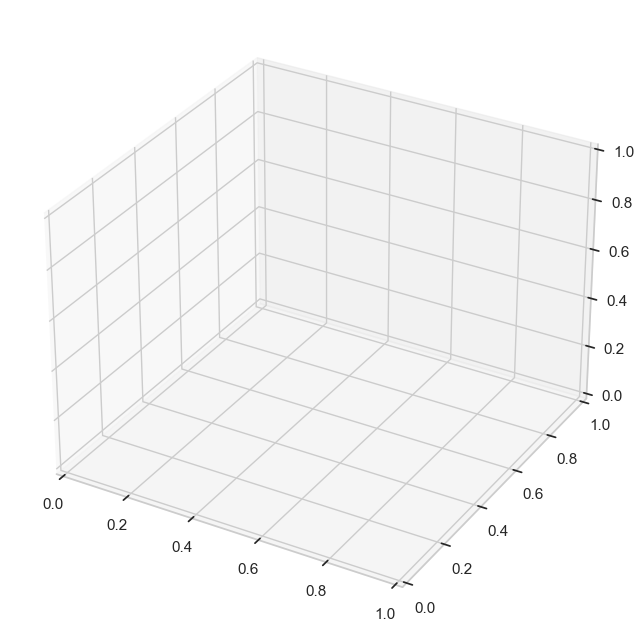

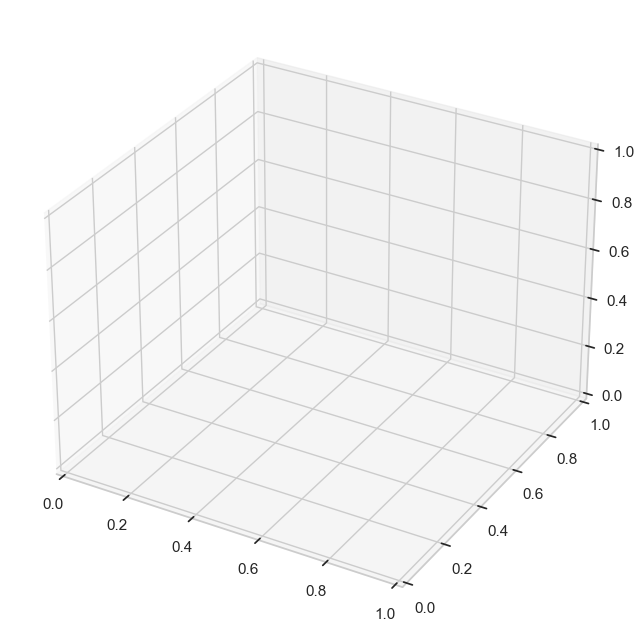

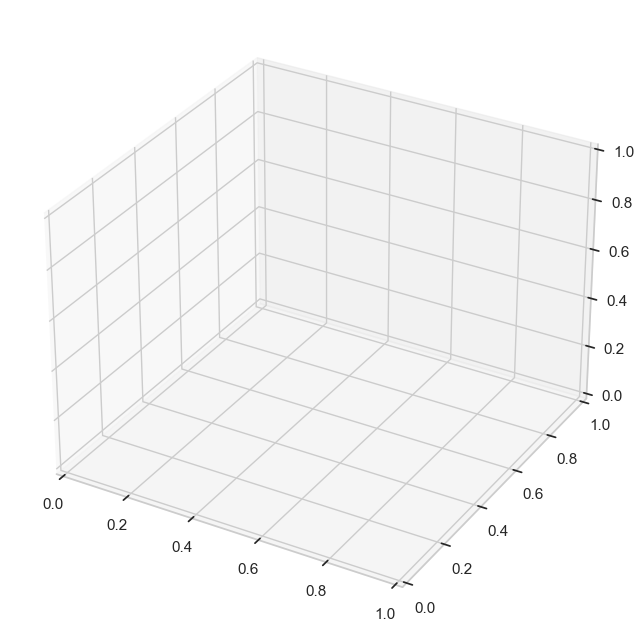

In [39]:

# getting the most recently saved file so that we can 
# use that as the model that we are analyzing
def get_most_recent_file(model_directory):
    
    # getting the files in the directory that we are considering
    files = [os.path.join(model_directory, f) for f in os.listdir(model_directory) if os.path.isfile(os.path.join(model_directory, f))]
    
    # check whether the list of files that exist in the directory is empty or not
    if not files:
        return None  

    # sort and return the first of the files sorted by how recently they were modified
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    return files[0]


# iterate through each of the clustering methods 
# for clustering_method in [k_means_centers, hierarchical_clustering, dbscan_clustering, mean_shift_clustering]:
# for clustering_method in [k_means_centers]:


# k_means_centers_variable = [t_cent.to(device) for t_cent in k_means_centers_variable]

# define the criteria and optimizer that we are going to be using to train the neural network
variance_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(augmented_model.parameters(), lr=0.001, weight_decay=1e-5)

print(f"k_means_centers_variable: {len(k_means_centers_variable)}")

# get the centroids and the mahalanobis values
(all_mahalanobis, centroid_passes) = mahalanobis_forward_pass(augmented_model, pca_train_features, k_means_centers_variable)

# get the pca labels
pca_labels = [t.item() for t in all_train_labels]

# print the labels
# print(f"Label set: {set(pca_labels)}")


Plotting labeled data points in subplot 0: 100%|██████████| 8/8 [00:00<00:00, 1930.52it/s]


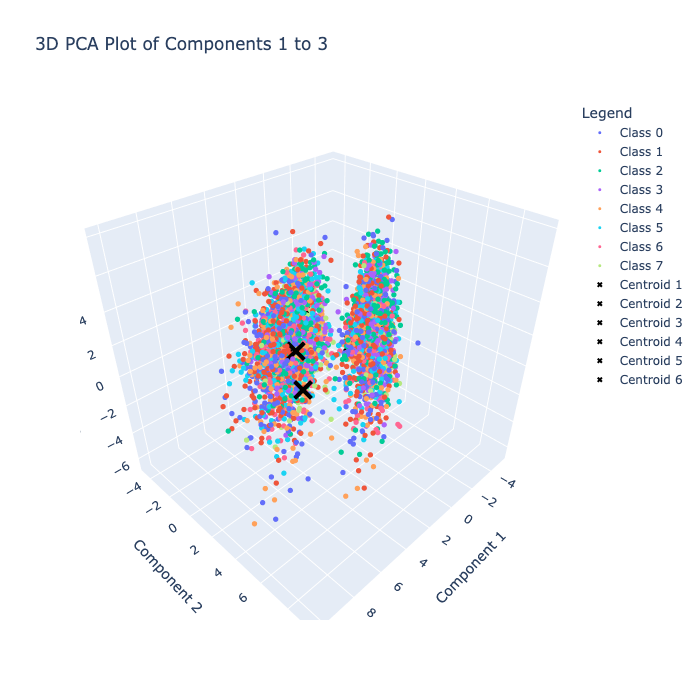

Plotting labeled data points in subplot 1: 100%|██████████| 8/8 [00:00<00:00, 1401.14it/s]


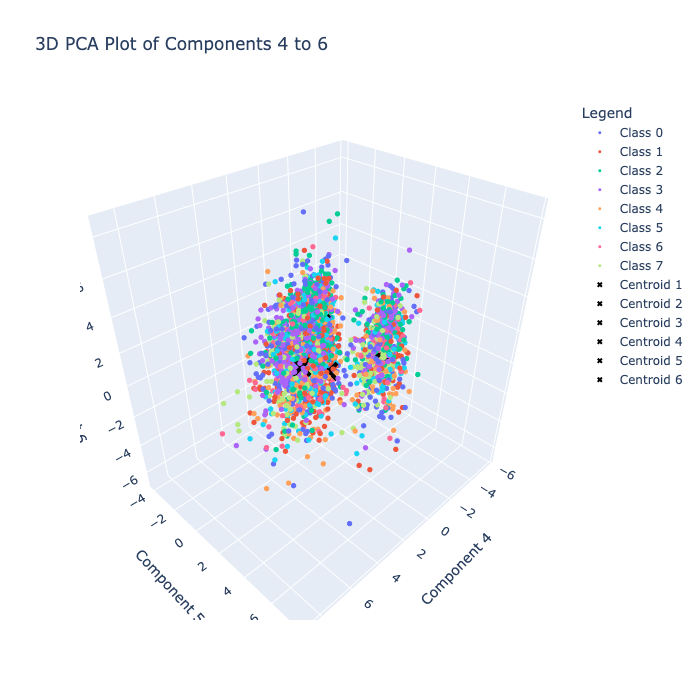

Plotting labeled data points in subplot 2: 100%|██████████| 8/8 [00:00<00:00, 2008.05it/s]


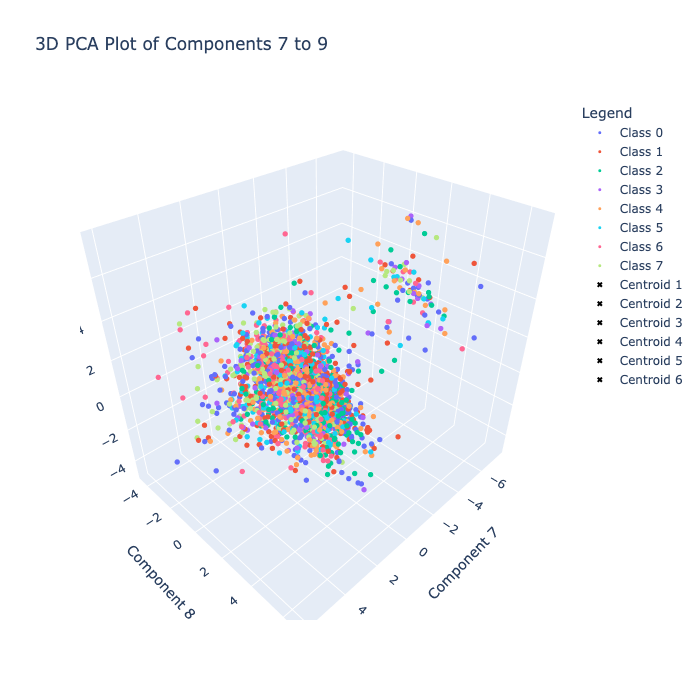

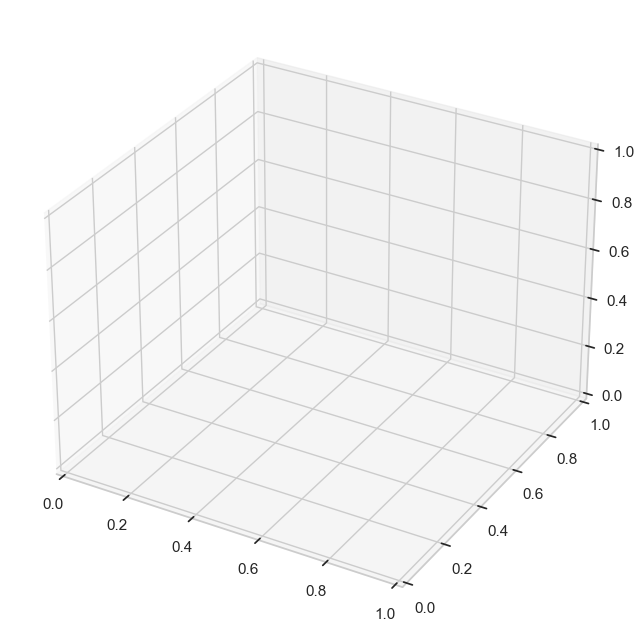

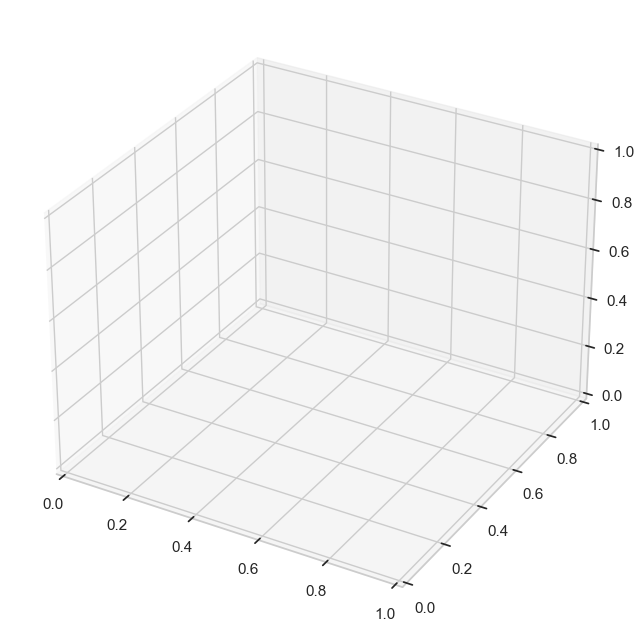

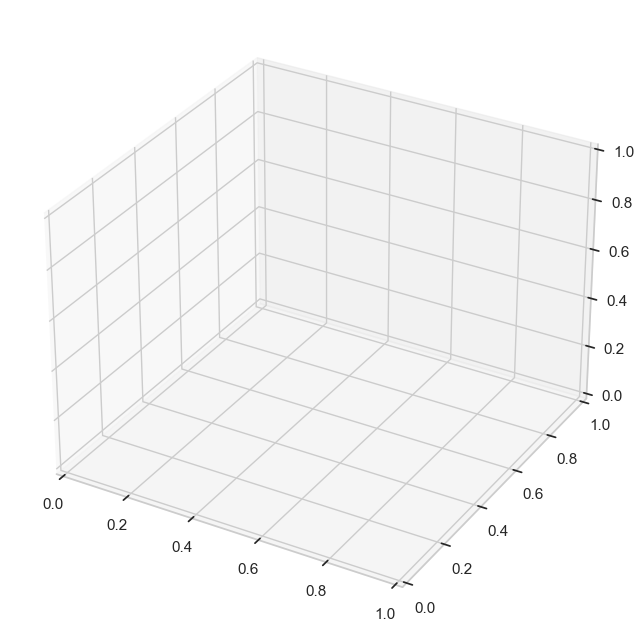

In [135]:

# show me the PCA clustering
visualize_pca(pca_train_features, pca_labels, k_means_centers_variable)


In [40]:
for c in centroid_passes:
    for t in c:
        print(t.shape)
        
    # break
    print()

torch.Size([1, 10])
torch.Size([1, 64])
torch.Size([1, 32])
torch.Size([1, 8])

torch.Size([1, 10])
torch.Size([1, 64])
torch.Size([1, 32])
torch.Size([1, 8])

torch.Size([1, 10])
torch.Size([1, 64])
torch.Size([1, 32])
torch.Size([1, 8])

torch.Size([1, 10])
torch.Size([1, 64])
torch.Size([1, 32])
torch.Size([1, 8])

torch.Size([1, 10])
torch.Size([1, 64])
torch.Size([1, 32])
torch.Size([1, 8])

torch.Size([1, 10])
torch.Size([1, 64])
torch.Size([1, 32])
torch.Size([1, 8])



Processing data for epoch: 100%|██████████| 1188/1188 [01:51<00:00, 10.69it/s]


Epoch 1, Loss: 1.5588304974414684, Val Loss: 1.5392346530651002


Processing data for epoch: 100%|██████████| 1188/1188 [01:51<00:00, 10.65it/s]


Epoch 2, Loss: 1.519145373543505, Val Loss: 1.5298418761905195


Processing data for epoch: 100%|██████████| 1188/1188 [01:51<00:00, 10.64it/s]


Epoch 3, Loss: 1.5086661453800971, Val Loss: 1.5265186756146878


Processing data for epoch: 100%|██████████| 1188/1188 [01:53<00:00, 10.49it/s]


Epoch 4, Loss: 1.5018157969018826, Val Loss: 1.5126145142898817


Processing data for epoch: 100%|██████████| 1188/1188 [01:54<00:00, 10.40it/s]


Epoch 5, Loss: 1.4959153890710086, Val Loss: 1.512351635730628


Processing data for epoch: 100%|██████████| 1188/1188 [01:54<00:00, 10.38it/s]


Epoch 6, Loss: 1.4920239803766964, Val Loss: 1.509025681701172


Processing data for epoch: 100%|██████████| 1188/1188 [01:54<00:00, 10.37it/s]


Epoch 7, Loss: 1.4885534839798706, Val Loss: 1.5104118705999972


Processing data for epoch: 100%|██████████| 1188/1188 [01:53<00:00, 10.46it/s]


Epoch 8, Loss: 1.4849611055168639, Val Loss: 1.5129688649065165


Processing data for epoch: 100%|██████████| 1188/1188 [01:54<00:00, 10.40it/s]


Epoch 9, Loss: 1.4820196180030554, Val Loss: 1.5060930938431711


Processing data for epoch: 100%|██████████| 1188/1188 [01:53<00:00, 10.46it/s]


Epoch 10, Loss: 1.4785046014520857, Val Loss: 1.5061760699307476


Processing data for epoch: 100%|██████████| 1188/1188 [01:53<00:00, 10.43it/s]


Epoch 11, Loss: 1.4763520875763814, Val Loss: 1.5039904535017432


Processing data for epoch: 100%|██████████| 1188/1188 [01:53<00:00, 10.46it/s]


Epoch 12, Loss: 1.4743603417769024, Val Loss: 1.5049875757910989


Processing data for epoch: 100%|██████████| 1188/1188 [01:53<00:00, 10.47it/s]


Epoch 13, Loss: 1.4719151060789923, Val Loss: 1.4987124943171286


Processing data for epoch: 100%|██████████| 1188/1188 [01:53<00:00, 10.45it/s]


Epoch 14, Loss: 1.4698198784882774, Val Loss: 1.5058766655648999


Processing data for epoch: 100%|██████████| 1188/1188 [01:53<00:00, 10.44it/s]


Epoch 15, Loss: 1.4680474865115452, Val Loss: 1.5002202112666685


Processing data for epoch: 100%|██████████| 1188/1188 [01:53<00:00, 10.47it/s]


Epoch 16, Loss: 1.4671520376044893, Val Loss: 1.4973451609563346


Processing data for epoch: 100%|██████████| 1188/1188 [01:53<00:00, 10.45it/s]


Epoch 17, Loss: 1.4645073287414783, Val Loss: 1.4998496855148162


Processing data for epoch: 100%|██████████| 1188/1188 [01:53<00:00, 10.46it/s]


Epoch 18, Loss: 1.4638350085176604, Val Loss: 1.4948430137602167


Processing data for epoch: 100%|██████████| 1188/1188 [01:53<00:00, 10.50it/s]


Epoch 19, Loss: 1.4617266687078507, Val Loss: 1.4994523091749712


Processing data for epoch: 100%|██████████| 1188/1188 [01:53<00:00, 10.47it/s]


Epoch 20, Loss: 1.4607915695668872, Val Loss: 1.4996896600883818


Processing data for epoch: 100%|██████████| 1188/1188 [01:53<00:00, 10.49it/s]


Stopping early due to increasing validation loss.


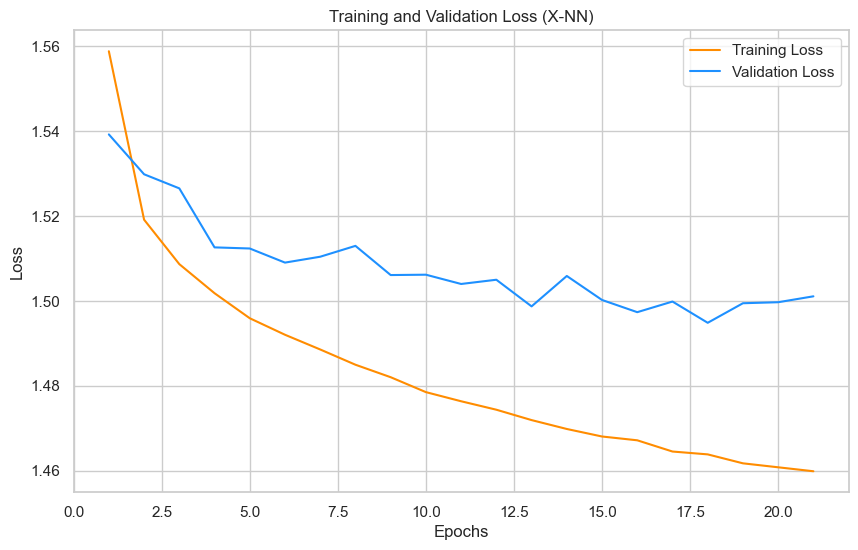

Train Accuracy: 45.63%
File will be saved as: /Users/tristanbrigham/Desktop/Classes/CPSC 471/Final Project/models_save/aug_model_save_k_means_centers_24
File will be saved as: /Users/tristanbrigham/Desktop/Classes/CPSC 471/Final Project/runthroughs/run_4/aug_model_save_k_means_centers.pth


In [41]:

# check if one or the other is not true
if TRAIN_MODEL and not SHOULD_SAVE_OUTPUT:
    raise ValueError("Incorrect truth table for arguments")


# train the model with the mahalanobis distances
if TRAIN_MODEL:
    if USE_BATCHES:
        train_model_with_variance(augmented_model, pca_train_loader, pca_val_loader, variance_criterion, optimizer, all_mahalanobis, k_means_centers_variable, centroid_passes, verbose=0, epochs=30)
    else:
        train_model_with_variance(augmented_model, pca_train_dataset, pca_val_dataset, variance_criterion, optimizer, all_mahalanobis, k_means_centers_variable, centroid_passes, verbose=0, epochs=30)

else:
    # getting the most recently saved file as the model
    rec_model = get_most_recent_file(SAVE_MODEL_PATH)

    path_for_display = rec_model.replace(' ', '\\ ')
    print(f"Loading model in from {path_for_display}")

    # load the model in from the save path
    augmented_model = torch.load(rec_model)

# get the output statistics for the model
accuracy = accuracy_score(all_train_labels, [np.argmax(t_arr) for t_arr in augmented_model(pca_train_features.to(device)).cpu().detach().numpy()])
print("Train Accuracy: {:.2f}%".format(accuracy * 100))


# saving the model if we have trained it
if TRAIN_MODEL:

    # generate a unique file name
    unique_dir = generate_unique_file_dir(SAVE_MODEL_PATH, AUG_SAVE_FILE_NAME.replace(".pth", f"_{clustering_method_name}"))
    os.makedirs(unique_dir, exist_ok=True)

    # save the file
    print("File will be saved as:", unique_dir)
    torch.save(augmented_model, os.path.join(unique_dir, AUG_SAVE_FILE_NAME))

    # save the information about the clusters and the centroids as well
    info_dict = {}

    # save the information in a dictionary
    info_dict['centroid_num'] = CLUSTER_NUM
    info_dict['centroids'] = k_means_centers_variable

    # open and dump the pickle file
    with open(os.path.join(unique_dir, INFO_DICT_NAME), 'wb') as file:
        pickle.dump(info_dict, file)


# check if we should save the model to a runthrough
if SHOULD_SAVE_OUTPUT:

    # generate a unique file name
    # unique_dir = generate_unique_file_dir(SAVE_MODEL_PATH, SAVE_FILE_NAME.replace(".pth", f"_{clustering_method.__name__}"))

    # save the file
    f_save_path = os.path.join(curr_run_dir, AUG_SAVE_FILE_NAME.replace(".pth", f"_{clustering_method_name}.pth"))
    print("File will be saved as:", f_save_path)
    torch.save(augmented_model, f_save_path)

    # save the information about the clusters and the centroids as well
    info_dict = {}

    # save the information in a dictionary
    info_dict['centroid_num'] = CLUSTER_NUM
    info_dict['centroids'] = k_means_centers_variable

    # open and dump the pickle file
    with open(os.path.join(curr_run_dir, INFO_DICT_NAME), 'wb') as file:
        pickle.dump(info_dict, file)


In [42]:
aug_pred = [np.argmax(t_arr) for t_arr in augmented_model(pca_val_features.to(device)).cpu().detach().numpy()]
accuracy = accuracy_score(all_val_labels, aug_pred)
print("Validation Accuracy: {:.2f}%".format(accuracy * 100))
print("Kappa Cohen: {:.4f}".format(eval_wrapper(all_val_labels, aug_pred) * 100))

Validation Accuracy: 44.22%
Kappa Cohen: 43.5707


Showing /Users/tristanbrigham/Desktop/Classes/CPSC 471/Final Project/models/generated_images/pca_subplot_1.png


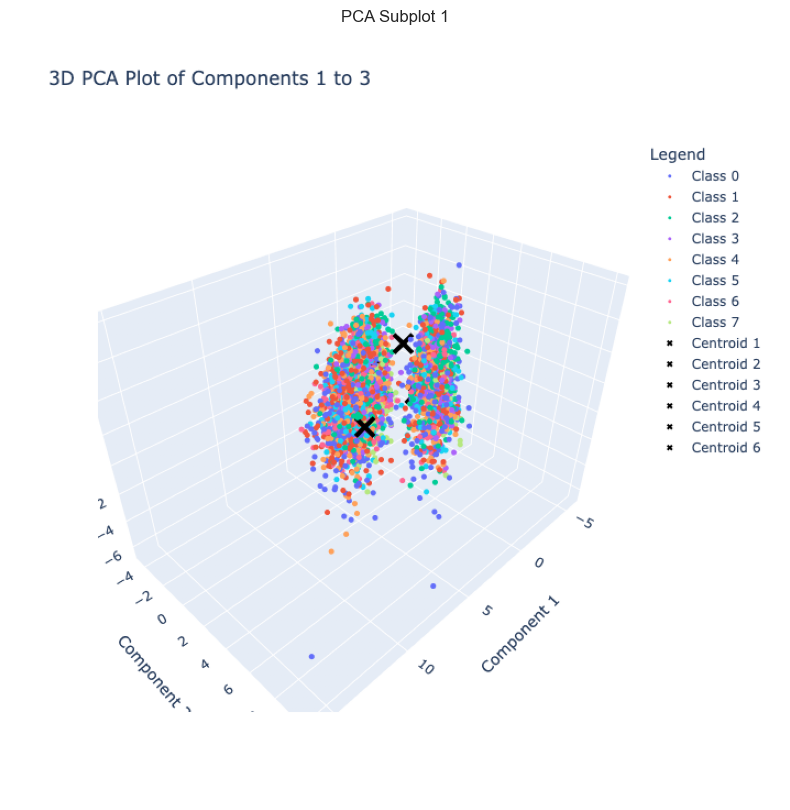

Showing /Users/tristanbrigham/Desktop/Classes/CPSC 471/Final Project/models/generated_images/pca_subplot_2.png


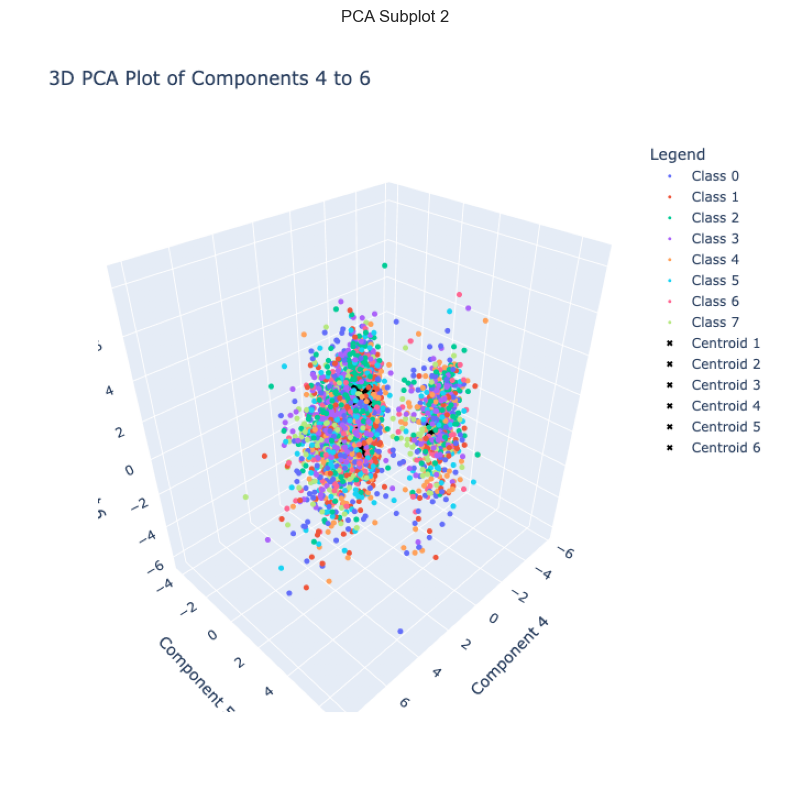

Showing /Users/tristanbrigham/Desktop/Classes/CPSC 471/Final Project/models/generated_images/pca_subplot_3.png


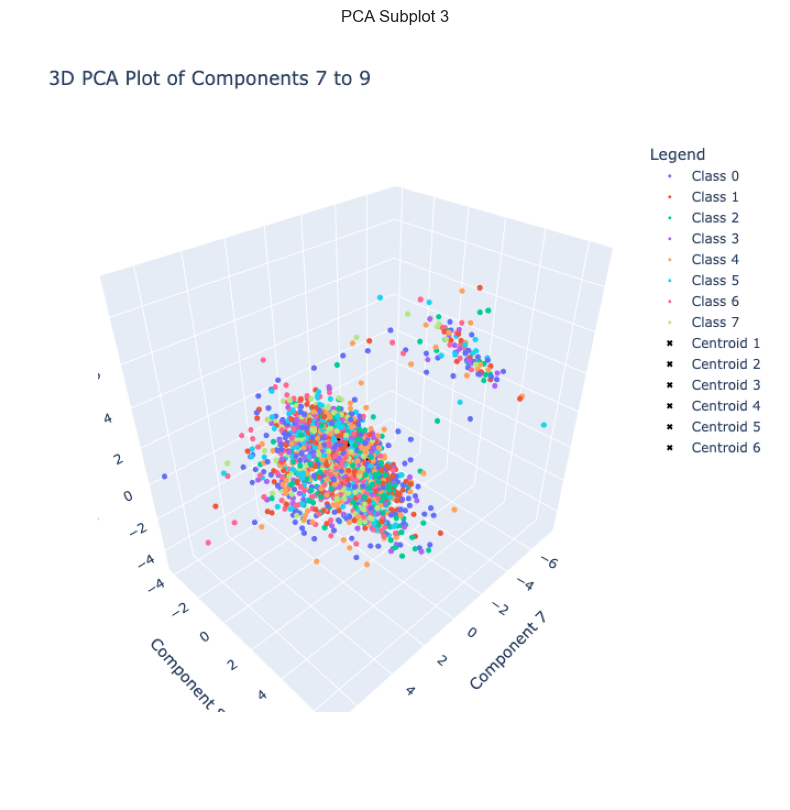

In [43]:
# showing the images for the notebook conversion
for i in range(1, 4):

	plt.figure(figsize=(10, 10))

	# get the path to the image that we should load in
	img_p = os.path.join(HOME_DIR, SUB_DIR, GENERATED_IMAGES_DIR, "generated_images", f"pca_subplot_{i}.png")

	print(f"Showing {img_p}")

	img = mpimg.imread(img_p)

	plt.axis('off')  # turn off axis
	plt.title(f"PCA Subplot {i}")

	imgplot = plt.imshow(img)

	if SHOULD_SAVE_OUTPUT:
		plt.savefig(dpi=300, fname=os.path.join(curr_run_dir, f"pca_subplot_{i}.png"))

	# show the image
	plt.show()


### Augmented Loss Function Neural Network Results

I find that the network with the augmented loss function aiming for explainability increases the loss that is associated with the neural network which is to be expected. With that being said, compared to popular benchmarks for explainability built into the neural network, the neural network above seems to have much better loss. We see average values for each of the statistics we are most interested in below:

| Metric            |   Value    |
|:------------------|:----------:|
| Train Accuracy    |   38.97%   |

As we can see, this is much better than the XGBoost model and slightly below the normal neural network model which was right around 50% (though it is not much behind the normal neural network's accuracy).

# Activation Analysis
Analysis of the explainability power of each of the nodes in the neural network is below. We are looking for co-dependencies between the input data and the activations of the neurons to try to see if the neurons are actually encoding data as a result of the training process. That is, we are looking for neurons that alone encode specific results as an extension of the CAV idea. Methods that we try to visualize and understand the interdependencies of the data along with their explanations are:
 
- Layer-Wise Relevance Propagation
	- This helps us understand how to weight the relative activation relationships that we find. If there is some activation that has a dramatically higher influence on the final output of the model than another, then it makes sense that we should investigate that neuron more closely than the other neurons with less explicit relationships. 
- Feature Activation Regressions
	- This helps us further understand the relationship between the inputs and the activations of neurons. Plotting the coefficients of the regression helps us to understand which combinations of inputs lead to the best explanation of the output of the activation of the neurons that we consider.  We analyze this below.

We also want to make sure that we have not forced the neural network into the lazy neural network regime where the neural network is simply approximating a kernel function or NTK. 

Some other methods that I could try with more time include:
- Neuron Activation Clustering
	- This is going to investigate the activations of the neurons to try to see if there is any relationship between the activations of the neurons in the model that we can attach to the labels that have been given to the input data points by the clustering method. 
	- Part of this method is going to be done with a regression attempting to quantify the relationship between the target layer for the neural network, and part of this method is going to be done with traditional clustering methods that are known. 
- Partial Dependence Plots
	- Shows the effect that some subset of the input features has on the output of the neuron activations. It helps us to understand the relative weighted relationship of the distance to the centroids of the clusters that we computed to the actual neuron activations that we are targeting.

In [44]:
# empty list for features
# features_list = []

# keep track of the max distance
max_mahalanobis = 0

# clear all of the intermediates in the model
global network_layer_outputs
clear_total_run()
# print(f"CURRENT MODEL STORAGE: {network_layer_outputs}")

# move the model
augmented_model = augmented_model.to(device)

# getting all of the training data for correlation analysis
for features, _ in pca_train_loader:

    # move the features to the device
    # features = features.to(device)

    # add it to the features list
    # features_list.append(features)

    # pipe it through the model
    outputs = augmented_model(features.to(device))
    
    # save the current passthrough to the list
    save_and_clear_current_pass_through()

# now get all of the outputs
aug_model_intermediates = network_layer_outputs
# print(f"AFTER MODEL STORAGE: {aug_model_intermediates}")
clear_total_run()

# concatenate all of the inputs that we are going to be using together
# all_features = torch.cat(features_list, dim=0)

# move the covariance matrix to the right device

# # moving the distance covariance matrix to the right device
# mahalanobis_covariance_matrix = mahalanobis_covariance_matrix.to('cpu')

# # array of all of the m distances that we are going to use
# all_mahalanobis = []

# # use tqdm to wrap the outer loop for a progress bar
# for t_feature in tqdm(all_features, desc="Computing Mahalanobis distances"):

#     # temp arr for mahalanobis distances corresponding to the distance from each of the K points from the clustering above
#     t_m_arr = []

#     # append all of the mahalanobis values
#     for t_m_dist in k_means_centers_variable:

#         # get the mahalanobis distance
#         m_dist = compute_mahalanobis(t_m_dist, t_feature, mahalanobis_covariance_matrix)

#         # check whether this is a new max distance or not
#         max_mahalanobis = max(abs(max_mahalanobis), m_dist)

#         t_m_arr.append(m_dist)

#     # store the distances
#     all_mahalanobis.append(t_m_arr) 

In [45]:
# do a forward pass on the model for each of the centroids
for t_center in k_means_centers_variable:
    _ = augmented_model(t_center.to(device))
    save_and_clear_current_pass_through()

# store the outputs of the centroid
centroid_passes = network_layer_outputs

# now perform the correlation analysis

In [46]:
# visualize the neural network that we made above
from torchviz import make_dot

# get the next input and label
inputs, labels = next(iter(pca_train_loader))

# get a passthrough of the augmented_model
y = augmented_model(inputs.to(device))

# make a diagram of the augmented_model
dot = make_dot(y.mean(), params=dict(augmented_model.named_parameters()))

if SHOULD_SAVE_OUTPUT:
	dot.format = 'png'
	dot.render(os.path.join(curr_run_dir, "nn_aug_structure.png"))

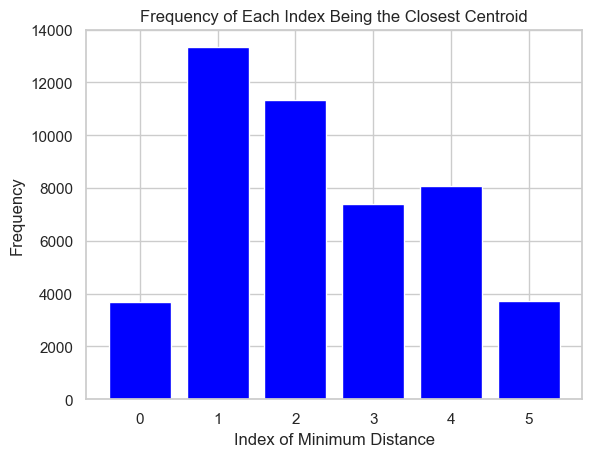

In [47]:
# plot a histogram of when each of the values are closest to one of the centroids

# find the index of the minimum value in each sub-array
min_indices = np.argmin(all_mahalanobis, axis=1)

# count the frequency of each index
index_counts = np.bincount(min_indices, minlength=5)

# plot the histogram
plt.bar(range(len(all_mahalanobis[0])), index_counts, color='blue')
plt.xlabel('Index of Minimum Distance')
plt.ylabel('Frequency')
plt.title('Frequency of Each Index Being the Closest Centroid')
plt.xticks(range(len(all_mahalanobis[0])))

if SHOULD_SAVE_OUTPUT:
	plt.savefig(dpi=300, fname=os.path.join(curr_run_dir, "min_dist_hist.png"))

plt.show()

In [48]:
# start correlation analysis with just a plain node correlation
from sklearn.linear_model import LinearRegression

# layer that we are considering
LAYER_IDX = 2

# the coefficients for the regressions that I am running
coefficients = []  
max_abs_coefficients = []
avg_abs_coefficients = []
max_lower_bounds = []
max_upper_bounds = []
avg_lower_bounds = []
avg_upper_bounds = []

# go through each of the intermediate variables in the model and collect them
for i in tqdm(range(len(aug_model_intermediates[0][LAYER_IDX][0])), desc="Creating regression between variables..."):

    # now we are going to get the ith element of the array
    current_node = []

    # adding all of the model intermediate values in 
    for j in range(len(aug_model_intermediates)):
        for t_element in aug_model_intermediates[j][LAYER_IDX][:, i]:
            current_node.append(t_element)

    # perform a regression between this element and the centroid distances

    # initialize a Linear Regression model
    linrg_model = LinearRegression()

    # convert the arrays to np arrays
    all_mahalanobis = np.array(all_mahalanobis)
    current_node = np.array(current_node)

    # print an update
    # print(f"Performing regression {i} between all_mahalanobis and current_node...")
    # print(f"Current Dimensions:\nall_mahalanobis shape{all_mahalanobis.shape}\ncurrent_node shape{current_node.shape}")

    # fit the regression
    linrg_model.fit(all_mahalanobis, current_node)

    # getting the maximum coefficient in the model
    max_abs_coef_index = np.argmax(np.abs(linrg_model.coef_))
    max_abs_model_coefficient = np.abs(linrg_model.coef_[max_abs_coef_index])
    max_abs_coefficients.append(max_abs_model_coefficient)

    avg_abs_coefficients.append(np.mean(np.sort(np.abs(linrg_model.coef_))[::-1][:3]))

    # get the residuals and the standard error
    bound_preds = linrg_model.predict(all_mahalanobis)
    resid_vals = np.sum((current_node - bound_preds)**2)
    model_standard_error = np.sqrt(resid_vals / (len(current_node) - 2)) /  np.sqrt(np.sum((all_mahalanobis - np.mean(all_mahalanobis))**2))

    # now compute the 95% confidence bound for the model
    df = len(current_node) - 2
    t_critical = stats.t.ppf(1-0.025, df)

     # append the upper and lower bounds to the arrays that we are using to keep track
    ci_lower = max_abs_model_coefficient - t_critical * model_standard_error
    ci_upper = max_abs_model_coefficient + t_critical * model_standard_error
    avg_ci_lower = avg_abs_coefficients[-1] - t_critical * model_standard_error
    avg_ci_upper = avg_abs_coefficients[-1] + t_critical * model_standard_error


    # naive average bounds -- FIX ME
    avg_lower_bounds.append(avg_ci_lower)
    avg_upper_bounds.append(avg_ci_upper)
        
    max_lower_bounds.append(ci_lower)
    max_upper_bounds.append(ci_upper)
        

        
    # store the coefficient
    coefficients.append(linrg_model.coef_)

Creating regression between variables...: 100%|██████████| 32/32 [00:12<00:00,  2.52it/s]


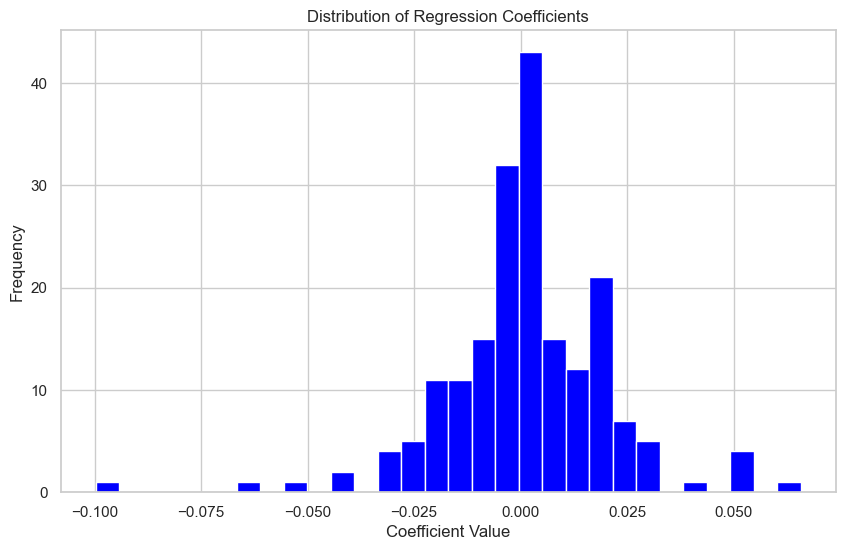

Coefficients Shape: (32, 6)


Plotting regression coefficients:  62%|██████▎   | 20/32 [00:05<00:03,  3.66it/s]/var/folders/d2/lsvbp7p92gnc5ql59sc72rx40000gn/T/ipykernel_99019/1752045325.py:39: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.

Plotting regression coefficients: 100%|██████████| 32/32 [00:09<00:00,  3.47it/s]


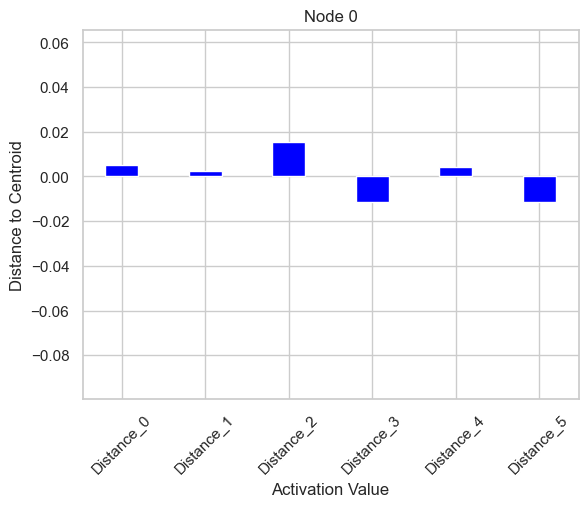

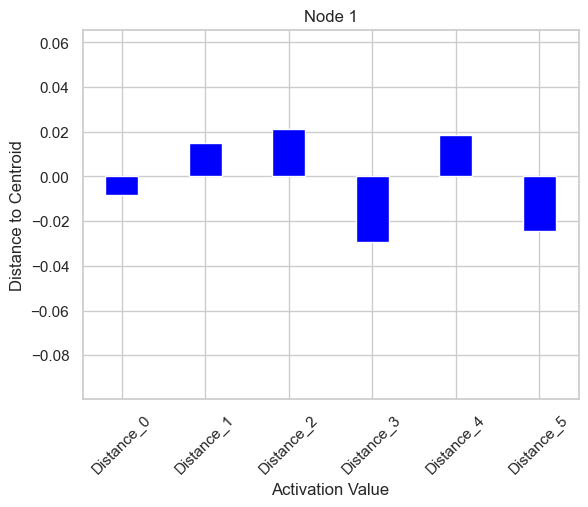

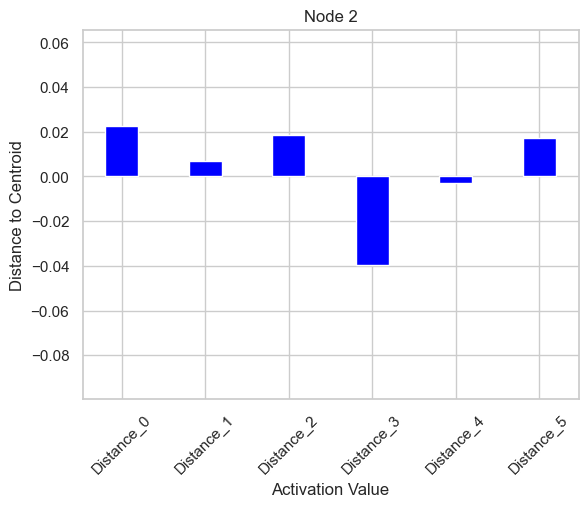

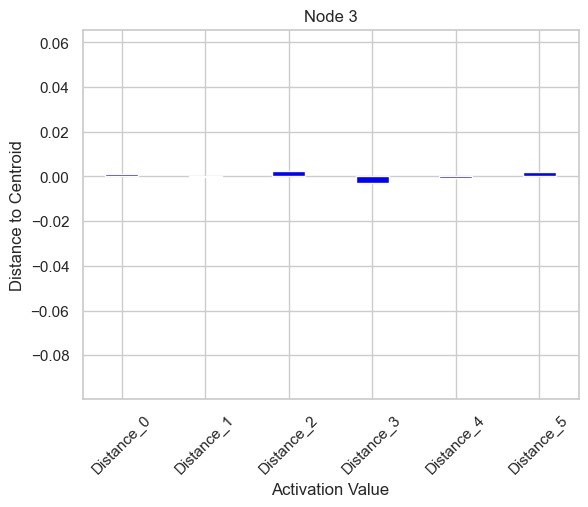

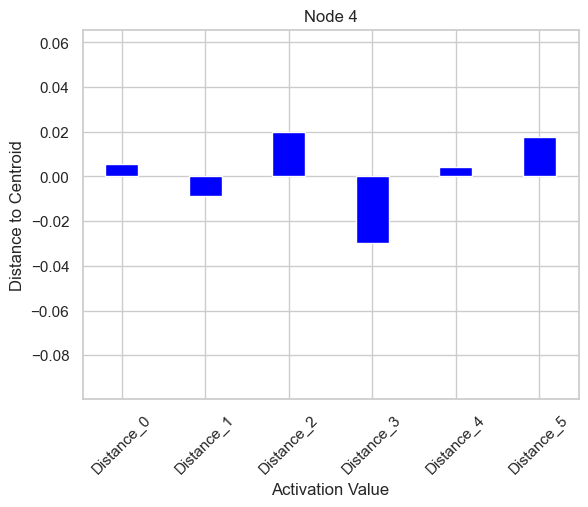

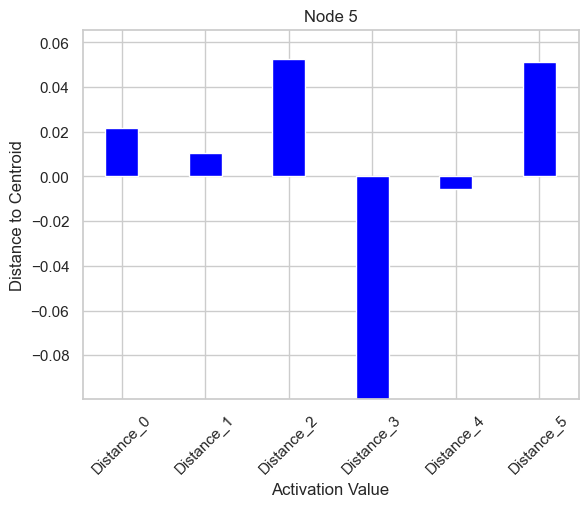

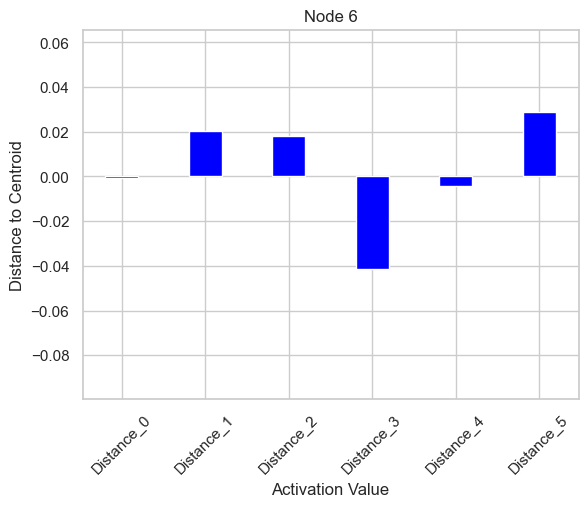

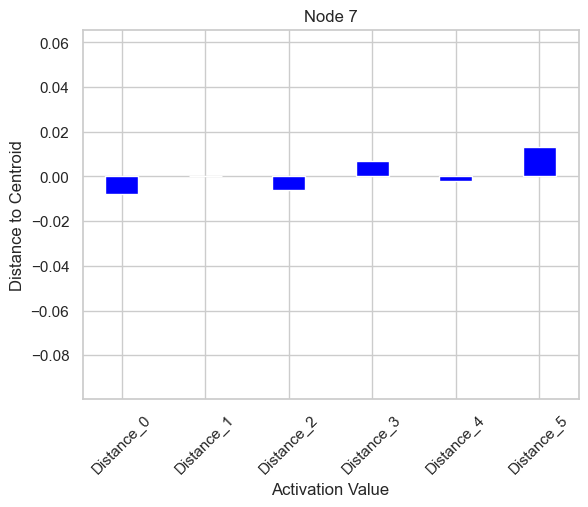

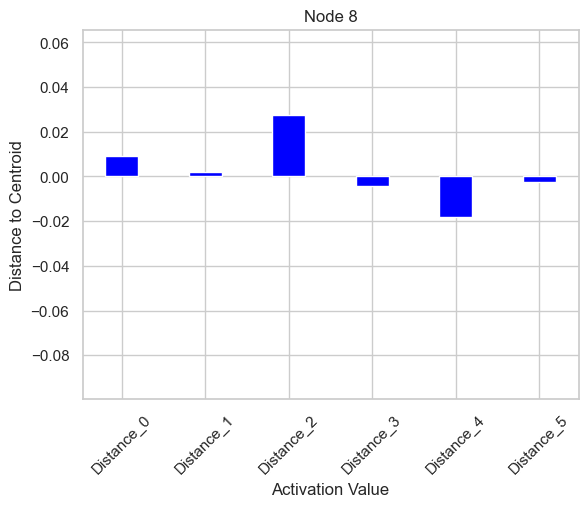

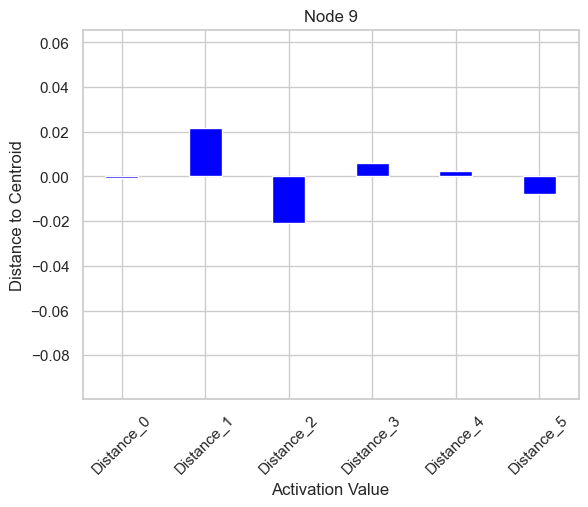

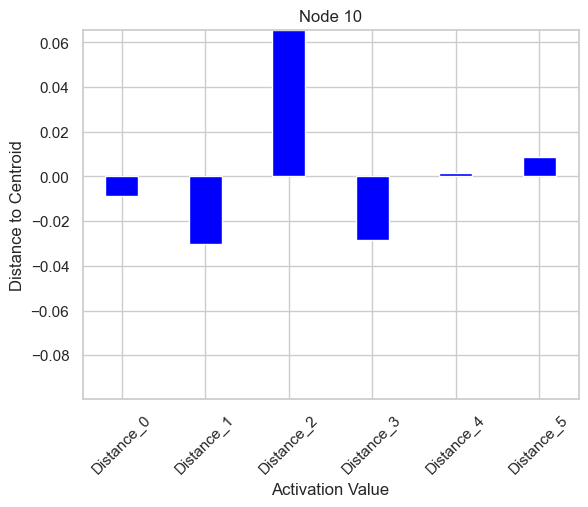

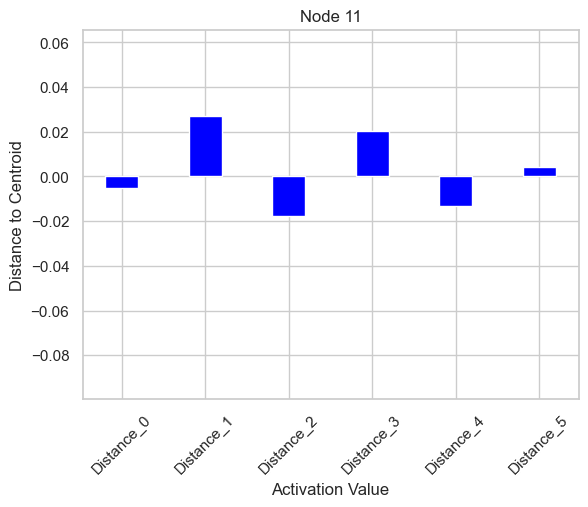

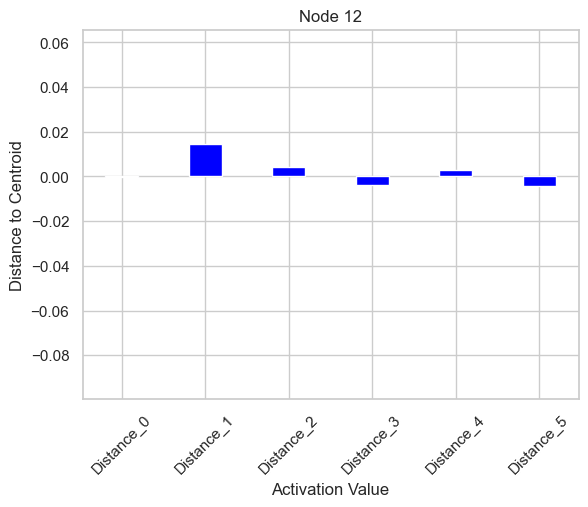

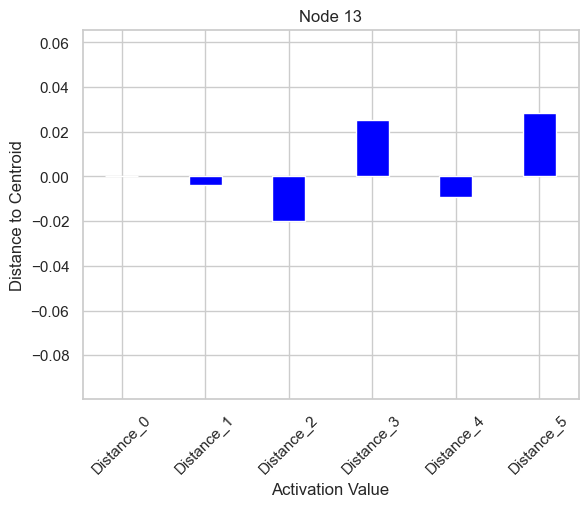

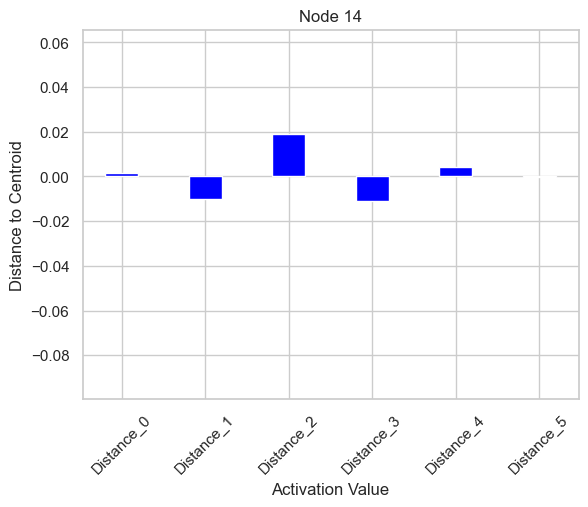

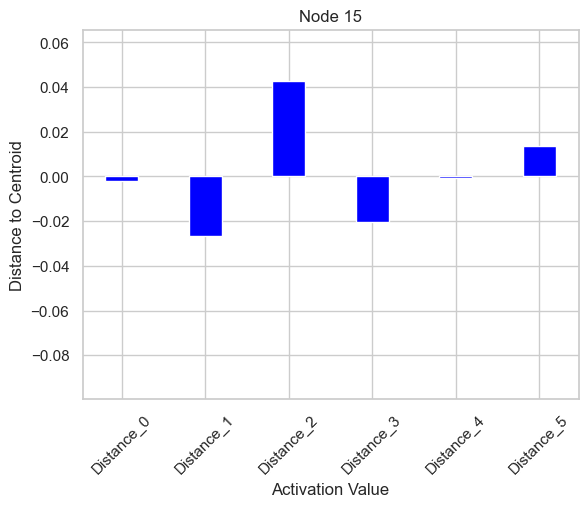

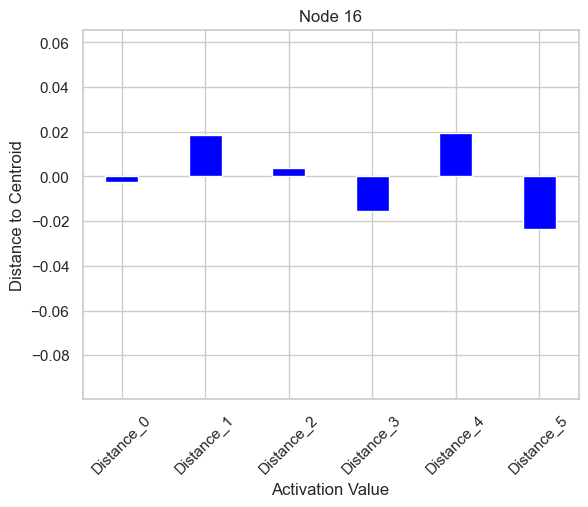

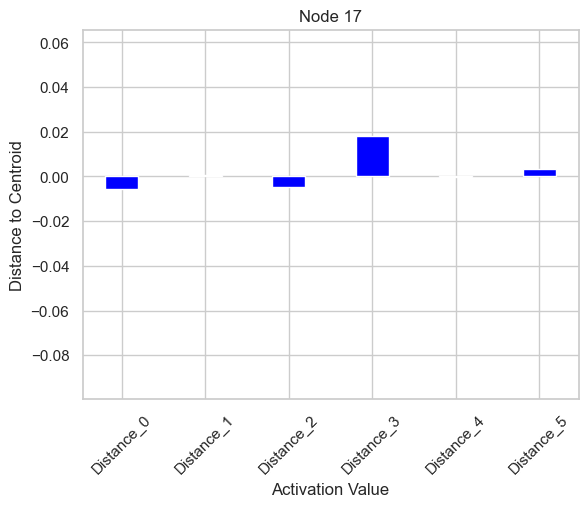

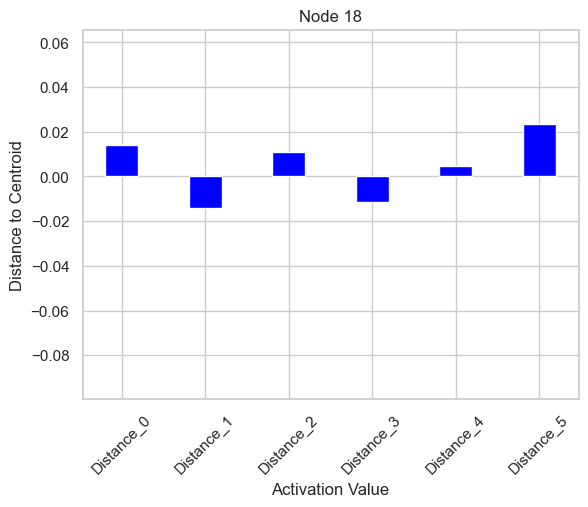

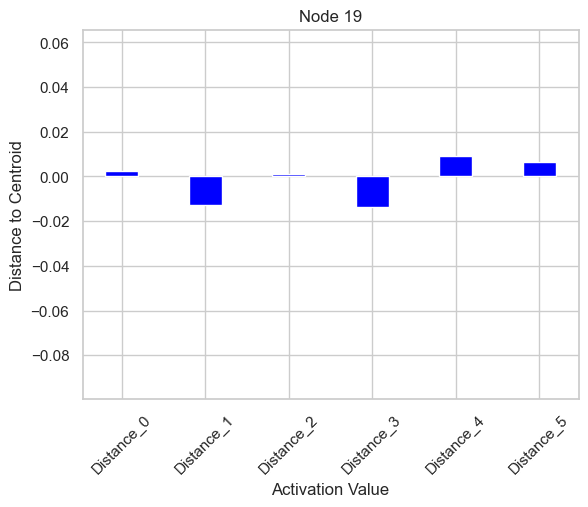

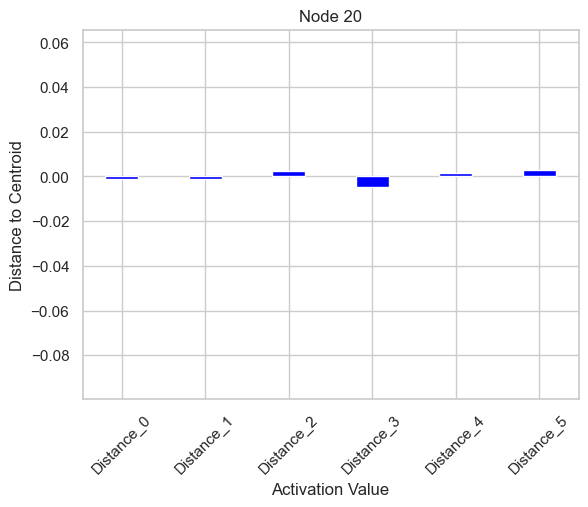

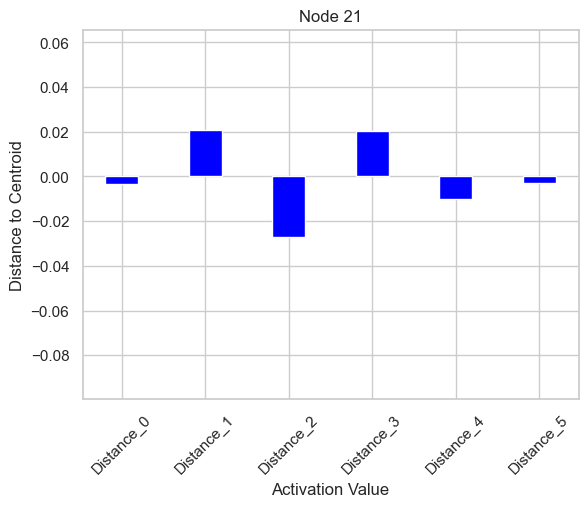

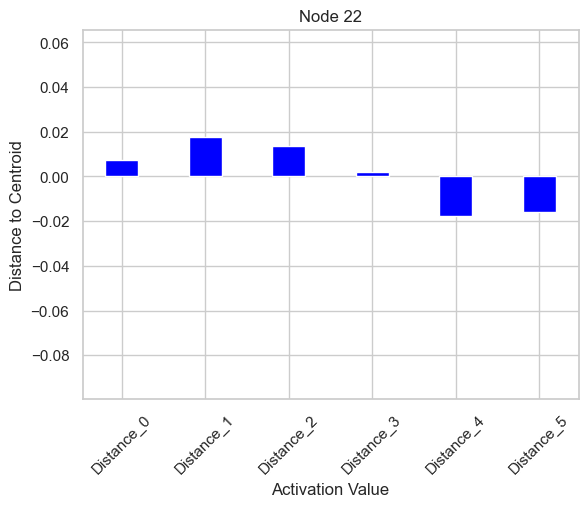

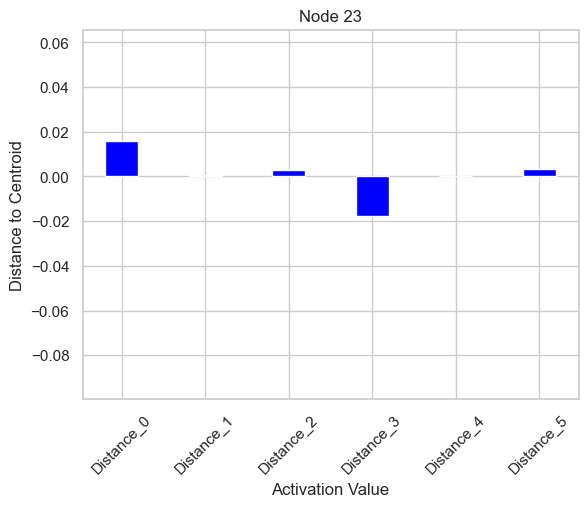

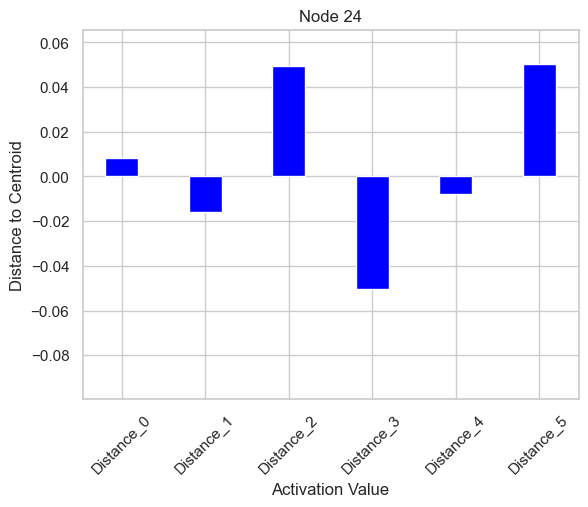

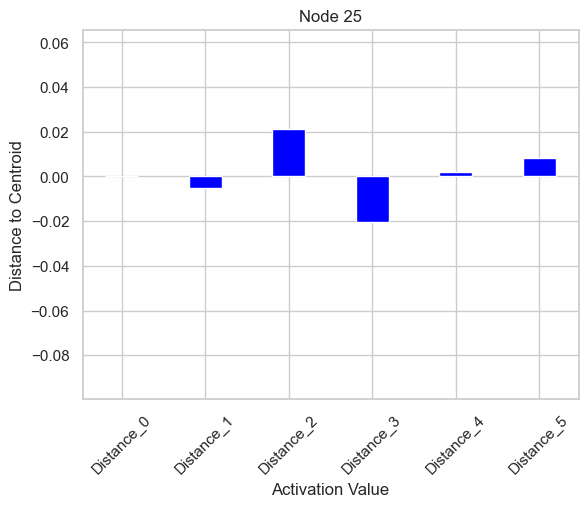

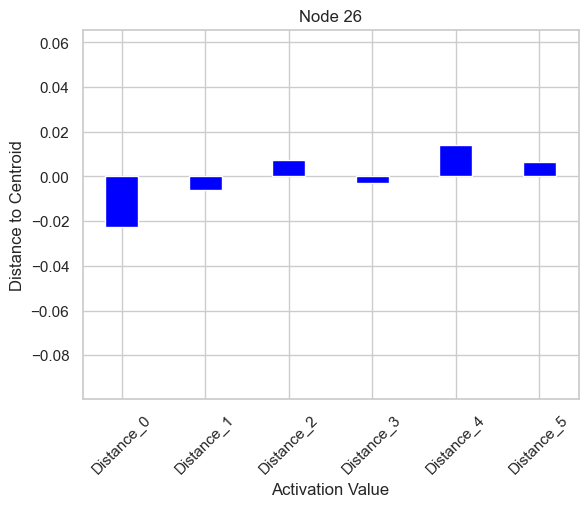

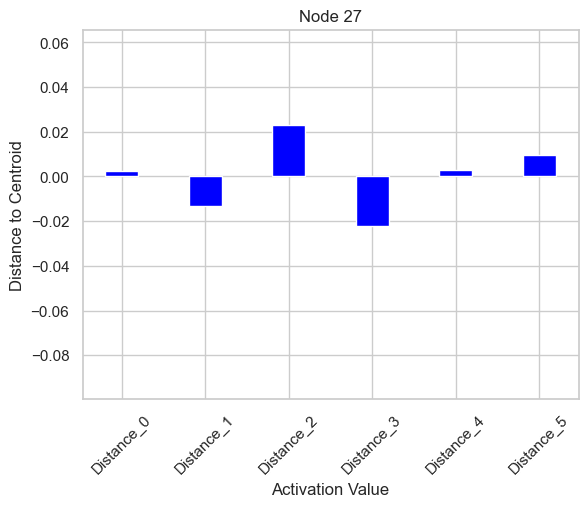

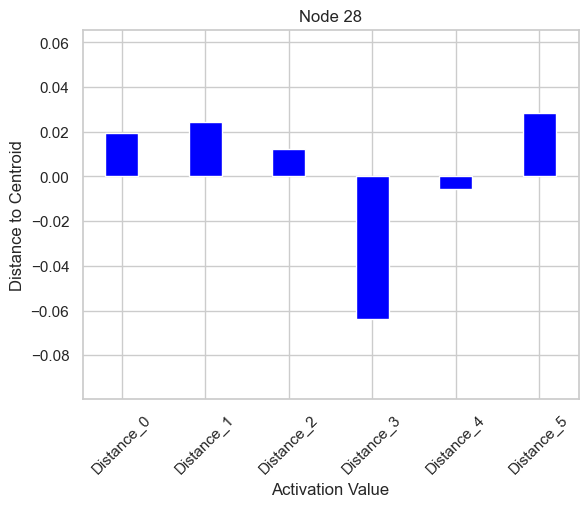

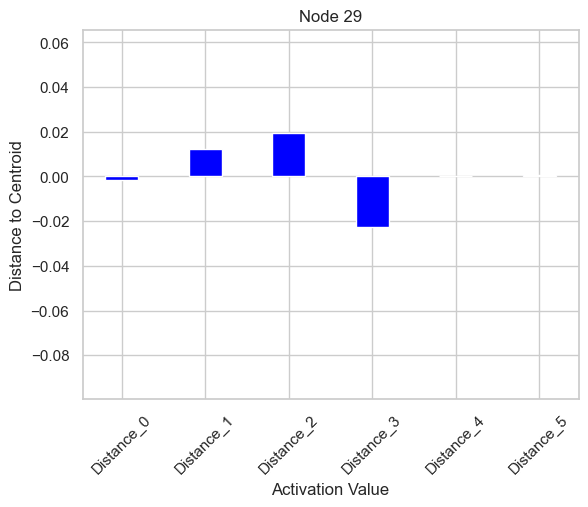

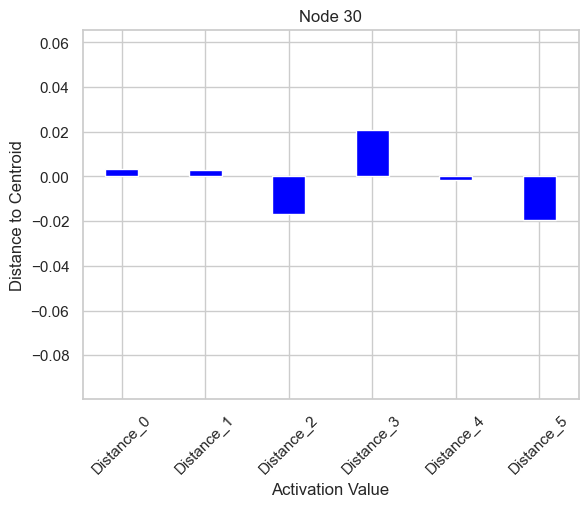

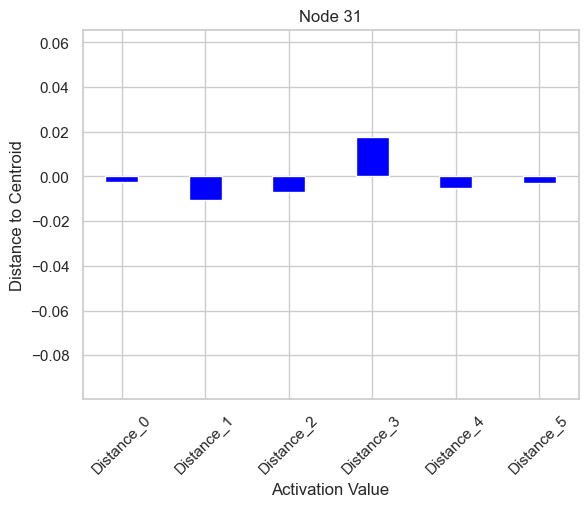

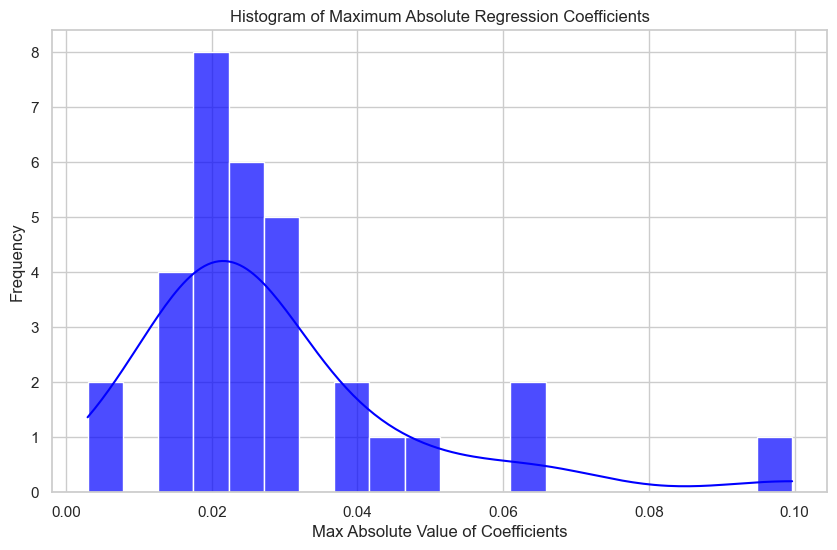

In [139]:
# plot the regression coefficients so that we can see what they are doing in the model
coefficients = np.array(coefficients)  

# flatten the array to get a single visualization
flat_coefficients = coefficients.flatten()

sns.set_theme(style="whitegrid")
sns.set_palette("magma")

# plot the information that we got
plt.figure(figsize=(10, 6))
plt.hist(flat_coefficients, bins=30, color='blue')
plt.title('Distribution of Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Frequency')

if SHOULD_SAVE_OUTPUT:
	os.makedirs(os.path.join(curr_run_dir, "aug_coeff_hist_plots"), exist_ok=True)
	plt.savefig(dpi=300, fname=os.path.join(curr_run_dir, "aug_coeff_hist_plots", "reg_coeff_dist_hist.png"))

plt.show()

# now go through and make subplots for everything that we are doing
print(f"Coefficients Shape: {coefficients.shape}")

# get the number of coefficients for creating subplots
n_coeffs = coefficients.shape[1]

# labels of the coefficients
coeff_labels = [f"Distance_{x}" for x in range(coefficients.shape[1])]

# getting the minimum and the maximum value of the regressions
ymin = np.min(coefficients)
ymax = np.max(coefficients)

# iterate through each of the possible coefficients that we are going to consider
for coeffs_idx in tqdm(range(coefficients.shape[0]), desc="Plotting regression coefficients"):
    
    plt.figure()

    # get the coefficients for that node in the matrix
    # plot on some subplot
    plt.bar(coeff_labels, coefficients[coeffs_idx], color ='blue', width = 0.4)
    
    # get the labeling information for the graph
    plt.title(f'Node {coeffs_idx}')
    plt.xlabel('Activation Value')
    plt.ylabel('Distance to Centroid')
    plt.xticks(rotation=45)

    # scale the y axis
    plt.ylim(ymin, ymax)

    if SHOULD_SAVE_OUTPUT:
        os.makedirs(os.path.join(curr_run_dir, "aug_coeff_hist_plots"), exist_ok=True)
        plt.savefig(dpi=300, fname=os.path.join(curr_run_dir, "aug_coeff_hist_plots", f"aug_plt_coeff_{coeffs_idx}_node.png"))

    

# show the figure that we constructed
plt.show()


# getting the node importances
aug_computed_importances = compute_importance_GRAD(augmented_model, pca_train_loader)


# get the right layer idx from the importance values
layer_aug_importances = aug_computed_importances[LAYER_IDX]

# now we are going to create the histogram 
# that shows the maximum values of the absolute regression coefficients

# getting the max value for each of the regs
max_aug_max_abs_values = np.array(max_abs_coefficients)
max_aug_sorted_indices = np.argsort(-max_aug_max_abs_values)

# sort the elements on the argument order
max_aug_sorted_max_abs_values = max_aug_max_abs_values[max_aug_sorted_indices]
max_aug_sorted_lower_bounds = np.array([max_lower_bounds[i] for i in max_aug_sorted_indices])
max_aug_sorted_upper_bounds = np.array([max_upper_bounds[i] for i in max_aug_sorted_indices])

max_aug_sorted_importance_values = np.array([layer_aug_importances[i] for i in max_aug_sorted_indices])



# getting the max value for each of the regs
avg_aug_max_abs_values = np.array(avg_abs_coefficients)
avg_aug_sorted_indices = np.argsort(-avg_aug_max_abs_values)

# sort the elements on the argument order
avg_aug_sorted_max_abs_values = avg_aug_max_abs_values[avg_aug_sorted_indices]
avg_aug_sorted_lower_bounds = np.array([avg_lower_bounds[i] for i in avg_aug_sorted_indices])
avg_aug_sorted_upper_bounds = np.array([avg_upper_bounds[i] for i in avg_aug_sorted_indices])

avg_aug_sorted_importance_values = np.array([layer_aug_importances[i] for i in avg_aug_sorted_indices])



# plot the histrogram
plt.figure(figsize=(10, 6))
sns.histplot(max_aug_max_abs_values, bins=20, kde=True, color='blue', alpha=0.7)
plt.title('Histogram of Maximum Absolute Regression Coefficients')
plt.xlabel('Max Absolute Value of Coefficients')
plt.ylabel('Frequency')  

if SHOULD_SAVE_OUTPUT:
	plt.savefig(dpi=300, fname=os.path.join(curr_run_dir, "aug_coeff_hist_plots", "aug_abs_coeff.png"))

plt.show()

In [50]:
# getting the difference in standard error bar sizes
delta = max_aug_sorted_upper_bounds - max_aug_sorted_lower_bounds

print(f"Mean error bar size: {delta.mean()}")

Mean error bar size: 0.017578295376721835


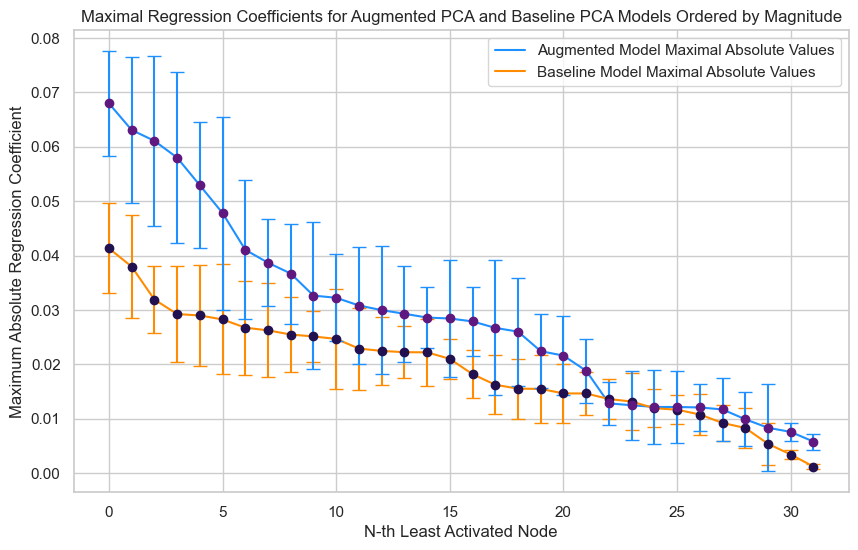

In [51]:
# now get a plot that shows the difference in the max absolute value ofthe coefficients inthe models

plt.figure(figsize=(10, 6))

# Plot both histograms
plt.plot(max_aug_sorted_max_abs_values, label='Augmented Model Maximal Absolute Values', color=PLOT_COLOR_2)
plt.plot(max_baseline_sorted_max_abs_values, label='Baseline Model Maximal Absolute Values', color=PLOT_COLOR_1)

plt.xlabel('N-th Least Activated Node')
plt.ylabel('Maximum Absolute Regression Coefficient')
plt.title('Maximal Regression Coefficients for Augmented PCA and Baseline PCA Models Ordered by Magnitude')
plt.legend()

plt.errorbar(x=np.arange(len(max_baseline_sorted_max_abs_values)), 
             y=max_baseline_sorted_max_abs_values, 
             yerr=[max_baseline_sorted_max_abs_values - max_baseline_sorted_lower_bounds, 
                   max_baseline_sorted_upper_bounds - max_baseline_sorted_max_abs_values],
             fmt='o', ecolor=PLOT_COLOR_1, capsize=5, label='95% Confidence Interval')


plt.errorbar(x=np.arange(len(max_aug_sorted_max_abs_values)), 
             y=max_aug_sorted_max_abs_values, 
             yerr=[max_aug_sorted_max_abs_values - max_aug_sorted_lower_bounds, 
                   max_aug_sorted_upper_bounds - max_aug_sorted_max_abs_values],
             fmt='o', ecolor=PLOT_COLOR_2, capsize=5, label='95% Confidence Interval')


if SHOULD_SAVE_OUTPUT:
	plt.savefig(os.path.join(curr_run_dir, "error_bar_aug_vs_baseline_regression_coeffs.png"), dpi=300)

plt.show()


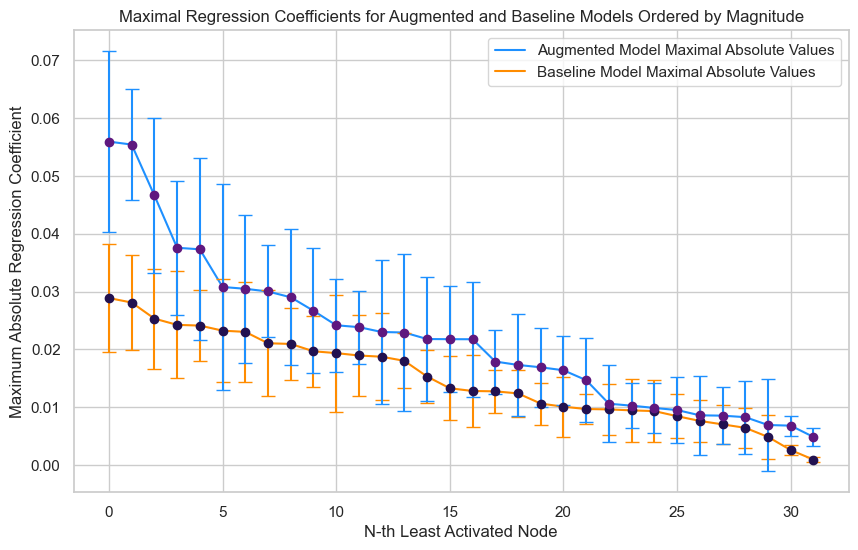

In [52]:
# now get a plot that shows the difference in the max absolute value ofthe coefficients inthe models

plt.figure(figsize=(10, 6))

# Plot both histograms
plt.plot(avg_aug_sorted_max_abs_values, label='Augmented Model Maximal Absolute Values', color=PLOT_COLOR_2)
plt.plot(avg_baseline_sorted_avg_abs_values, label='Baseline Model Maximal Absolute Values', color=PLOT_COLOR_1)

plt.xlabel('N-th Least Activated Node')
plt.ylabel('Maximum Absolute Regression Coefficient')
plt.title('Maximal Regression Coefficients for Augmented and Baseline Models Ordered by Magnitude')
plt.legend()

plt.errorbar(x=np.arange(len(avg_baseline_sorted_avg_abs_values)), 
             y=avg_baseline_sorted_avg_abs_values, 
             yerr=[avg_baseline_sorted_avg_abs_values - avg_baseline_sorted_lower_bounds, 
                   avg_baseline_sorted_upper_bounds - avg_baseline_sorted_avg_abs_values],
             fmt='o', ecolor=PLOT_COLOR_1, capsize=5, label='95% Confidence Interval')


plt.errorbar(x=np.arange(len(avg_aug_sorted_max_abs_values)), 
             y=avg_aug_sorted_max_abs_values, 
             yerr=[avg_aug_sorted_max_abs_values - avg_aug_sorted_lower_bounds, 
                   avg_aug_sorted_upper_bounds - avg_aug_sorted_max_abs_values],
             fmt='o', ecolor=PLOT_COLOR_2, capsize=5, label='95% Confidence Interval')

if SHOULD_SAVE_OUTPUT:
	plt.savefig(os.path.join(curr_run_dir, "aug_vs_baseline_regression_coeffs.png"), dpi=300)

plt.show()


Registering hooks...


Processing data for epoch:   0%|          | 0/1188 [00:00<?, ?it/s]

Processing data for epoch: 100%|██████████| 1188/1188 [01:52<00:00, 10.58it/s]


Epoch 1, Loss: 1.408120042095682, Val Loss: 1.3531709475950762


Processing data for epoch: 100%|██████████| 1188/1188 [01:52<00:00, 10.60it/s]


Epoch 2, Loss: 1.3104654080940015, Val Loss: 1.323167248406394


Processing data for epoch: 100%|██████████| 1188/1188 [01:52<00:00, 10.53it/s]


Epoch 3, Loss: 1.2830515473780006, Val Loss: 1.3177611031114855


Processing data for epoch: 100%|██████████| 1188/1188 [01:52<00:00, 10.57it/s]


Epoch 4, Loss: 1.2641613869253634, Val Loss: 1.3019352978728838


Processing data for epoch: 100%|██████████| 1188/1188 [01:51<00:00, 10.64it/s]


Epoch 5, Loss: 1.2476913957583784, Val Loss: 1.3077208170987138


Processing data for epoch: 100%|██████████| 1188/1188 [01:52<00:00, 10.53it/s]


Epoch 6, Loss: 1.2367395459100454, Val Loss: 1.3212941961256341


Processing data for epoch: 100%|██████████| 1188/1188 [01:55<00:00, 10.29it/s]


Stopping early due to increasing validation loss.


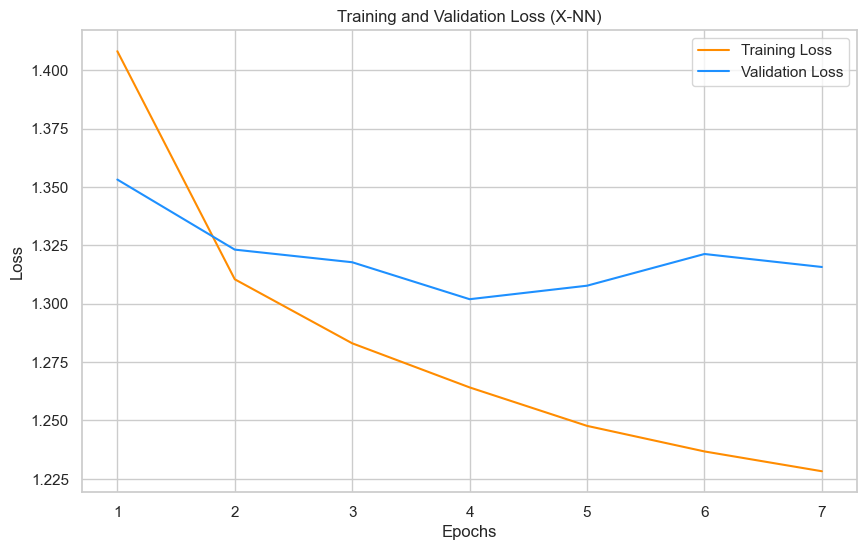

Train Accuracy: 56.82%
Training full input model
File will be saved as: /Users/tristanbrigham/Desktop/Classes/CPSC 471/Final Project/models_save/full_input_aug_model_save_k_means_centers_4
File will be saved as: /Users/tristanbrigham/Desktop/Classes/CPSC 471/Final Project/runthroughs/run_4/full_input_aug_model_save_k_means_centers.pth


In [53]:
# now try the same training with the whole 130 input features but PCA distances as the distance function

# define a neural network that we can customize the inputs and outputs for each layer for
class FullNodeImportanceNN(nn.Module):

    # initialize the insurance neural network item
    def __init__(self):
        super(FullNodeImportanceNN, self).__init__()
        
        # define the layers that we are going to use for the neural network
        self.foward_1 = nn.Linear(all_train_features.shape[1], 64)
        self.foward_2 = nn.Linear(64, 32)
        self.forward_3 = nn.Linear(32, NUM_CLASSES)  

    # go forward through the neural network
    def forward(self, x):

        global current_pass_through
        
        # append the initial input to the pass-through array
        current_pass_through.append(x.cpu().detach())

        # define a dictionary that we are going to be using to keep track of the losses
        # output_dict = {}
        # curr_idx = 0

        x = F.relu(self.foward_1(x))
        # output_dict[str(curr_idx)] = x
        # curr_idx += 1

        x = F.relu(self.foward_2(x))
        # output_dict[str(curr_idx)] = x
        # curr_idx += 1

        x = self.forward_3(x)
        # output_dict[str(curr_idx)] = x
        # curr_idx += 1

        # return the overall loss dictionary with the output
        return x

    # this function returns the probabilities for different classes from the neural network model
    def predict_proba(self, x, device='cpu'):
        
        # set the network to evaluation mode
        self.eval()  
        
        with torch.no_grad():
        
            # pass through the model
            x = x.to(device)
            outputs = self(x)

            # get the probabilities
            out_probs = F.softmax(outputs, dim=1)

            return out_probs

    # defining a fit function to appease the marginal probability regression function
    def fit(self, train_loader, epochs, optimizer, criterion, device='cpu'):
        
        # move everything to devices
        self.to(device)
        self.train()

        # iterate through some amount of epochs to train the model
        for epoch in range(epochs):

            for inputs, labels in train_loader:
            
                # move everything to the right devices
                inputs = inputs.to(device) 
                labels = labels.to(device)

                # reset the optimizer that we are using
                optimizer.zero_grad()
                outputs = self(inputs)

                # calc the loss
                loss = criterion(outputs, labels)
                
                # backprop the loss
                loss.backward()
                optimizer.step()
            
            # print epoch information
            print(f'epoch: {epoch+1}/{epochs} | loss: {loss.item():.4f}')




# initialize the model
total_input_model = FullNodeImportanceNN()

variance_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(total_input_model.parameters(), lr=0.001, weight_decay=1e-5)

start_new_pass_through()
clear_total_run()

# actually register the hooks on the model
register_hooks(total_input_model)

# save the old cov matrix
# total_mahalanobis_covariance_matrix = mahalanobis_distance_matrix(pca_train_features)
# total_mahalanobis_covariance_matrix = total_mahalanobis_covariance_matrix.to('cpu')


# check if one or the other is not true
if TRAIN_MODEL and not SHOULD_SAVE_OUTPUT:
	raise ValueError("Incorrect truth table for arguments")



# train the model with the mahalanobis distances
if TRAIN_MODEL:
    
    if USE_BATCHES:
        train_model_with_variance(total_input_model, pca_full_train_loader, pca_full_val_loader, variance_criterion, optimizer, all_mahalanobis, k_means_centers_variable, centroid_passes, verbose=0, epochs=30, training_pca_and_full=True, sum_epsilon=0.1)
    else:
        train_model_with_variance(total_input_model, pca_full_train_dataset, pca_full_val_dataset, variance_criterion, optimizer, all_mahalanobis, k_means_centers_variable, centroid_passes, verbose=0, epochs=30, training_pca_and_full=True, sum_epsilon=0.1)

else:

	raise ValueError("Not able to load in untrained model")


# get the output statistics for the model
accuracy = accuracy_score(all_train_labels, [np.argmax(t_arr) for t_arr in total_input_model(all_train_features.to(device)).cpu().detach().numpy()])
print("Train Accuracy: {:.2f}%".format(accuracy * 100))


# saving the model if we have trained it
if TRAIN_MODEL:

	# give the status update that we are training the full model now
	print(f"Training full input model")

	# generate a unique file name
	unique_dir = generate_unique_file_dir(SAVE_MODEL_PATH, FULL_INPUT_AUG_SAVE_FILE_NAME.replace(".pth", f"_{clustering_method_name}"))
	os.makedirs(unique_dir, exist_ok=True)

	# save the file
	print("File will be saved as:", unique_dir)
	torch.save(total_input_model, os.path.join(unique_dir, FULL_INPUT_AUG_SAVE_FILE_NAME))

	# save the information about the clusters and the centroids as well
	info_dict = {}

	# save the information in a dictionary
	info_dict['centroid_num'] = CLUSTER_NUM
	info_dict['centroids'] = k_means_centers_variable

	# open and dump the pickle file
	with open(os.path.join(unique_dir, INFO_DICT_NAME), 'wb') as file:
		pickle.dump(info_dict, file)



# check if we should save the model to a runthrough
if SHOULD_SAVE_OUTPUT:

	# generate a unique file name
	# unique_dir = generate_unique_file_dir(SAVE_MODEL_PATH, SAVE_FILE_NAME.replace(".pth", f"_{clustering_method.__name__}"))

	# save the file
	f_save_path = os.path.join(curr_run_dir, FULL_INPUT_AUG_SAVE_FILE_NAME.replace(".pth", f"_{clustering_method_name}.pth"))
	print("File will be saved as:", f_save_path)
	torch.save(total_input_model, f_save_path)

	# save the information about the clusters and the centroids as well
	info_dict = {}

	# save the information in a dictionary
	info_dict['centroid_num'] = CLUSTER_NUM
	info_dict['centroids'] = k_means_centers_variable

	# open and dump the pickle file
	with open(os.path.join(curr_run_dir, INFO_DICT_NAME), 'wb') as file:
		pickle.dump(info_dict, file)

Creating regression between variables...: 100%|██████████| 32/32 [00:12<00:00,  2.65it/s]


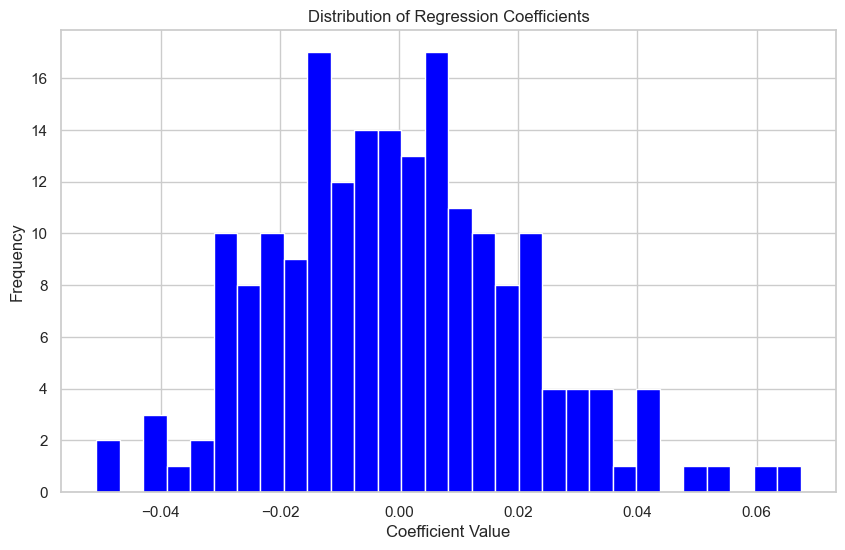

Coefficients Shape: (32, 6)


Plotting regression coefficients:  62%|██████▎   | 20/32 [00:06<00:03,  3.25it/s]/var/folders/d2/lsvbp7p92gnc5ql59sc72rx40000gn/T/ipykernel_99019/2285232680.py:149: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.

Plotting regression coefficients: 100%|██████████| 32/32 [00:09<00:00,  3.22it/s]


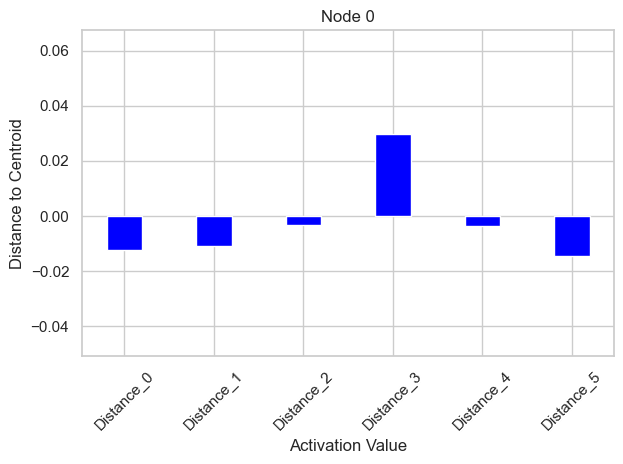

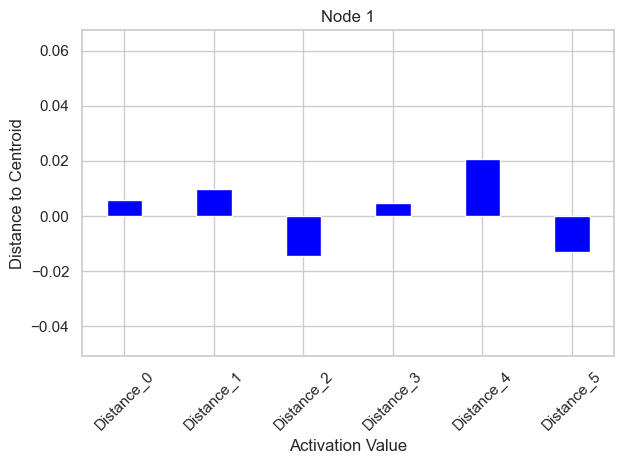

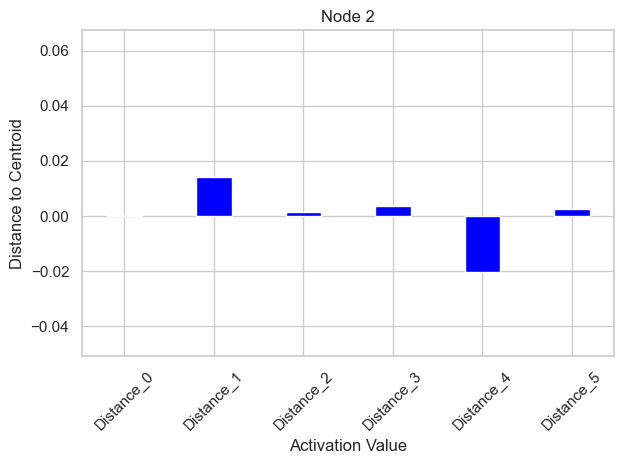

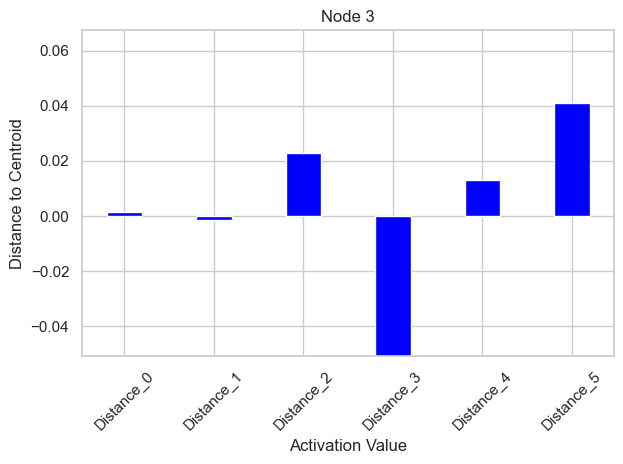

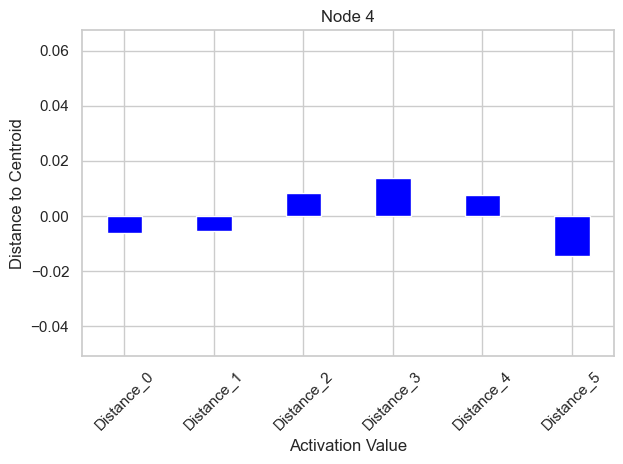

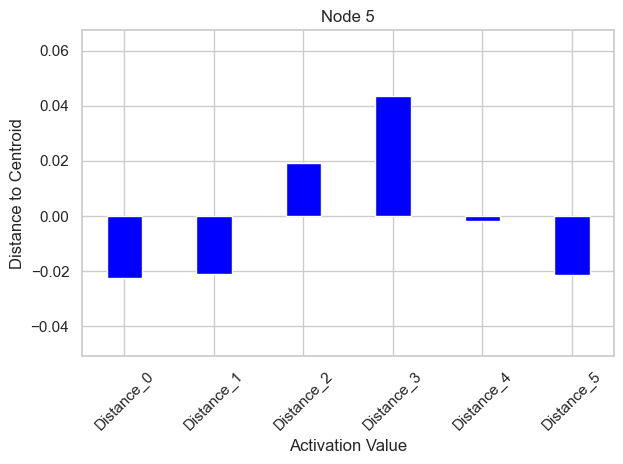

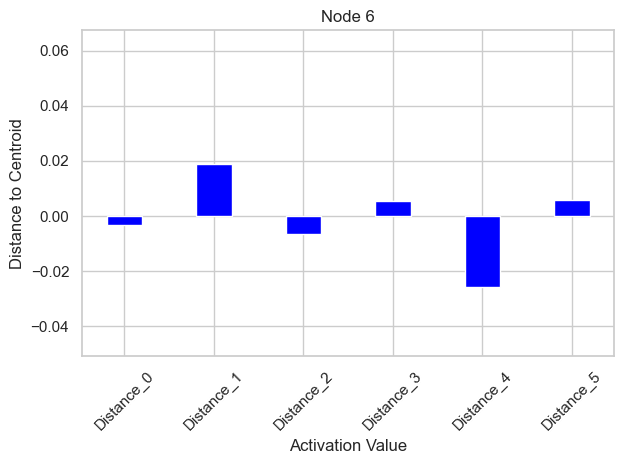

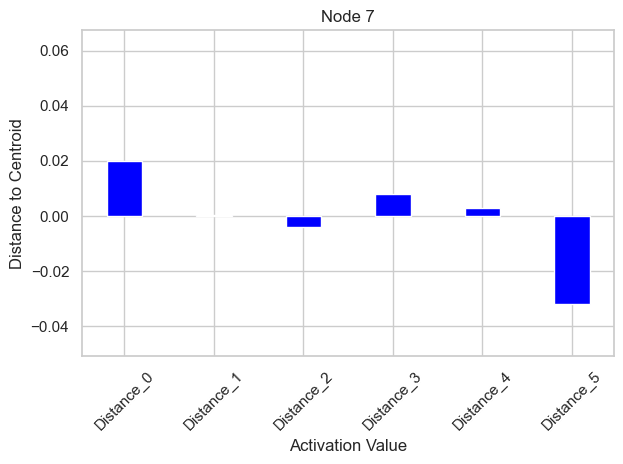

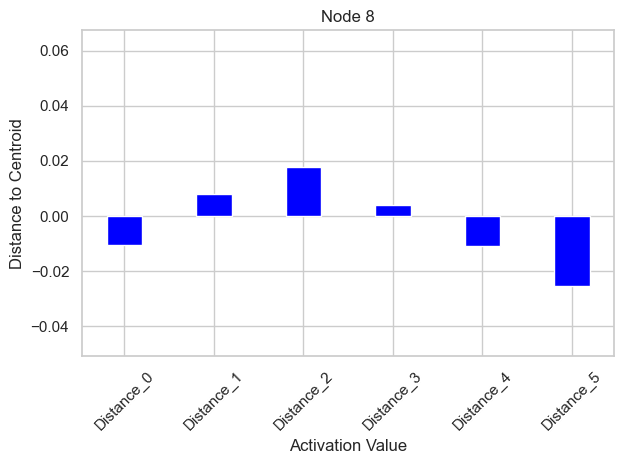

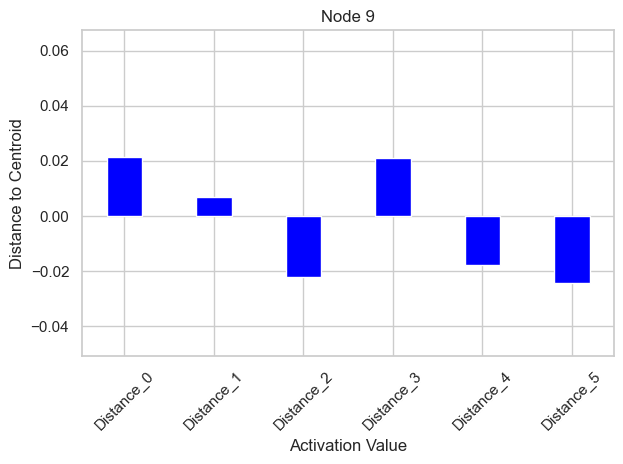

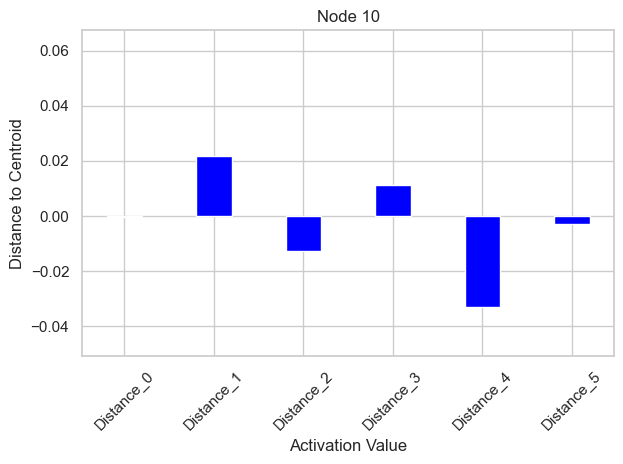

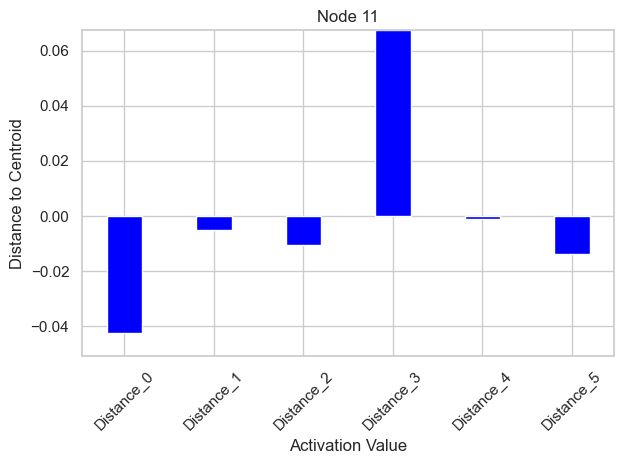

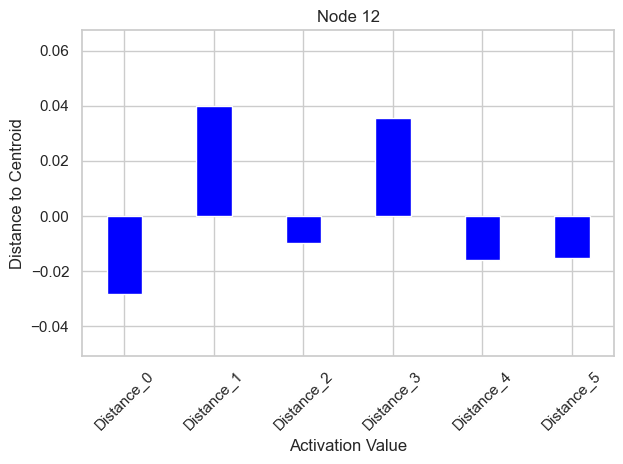

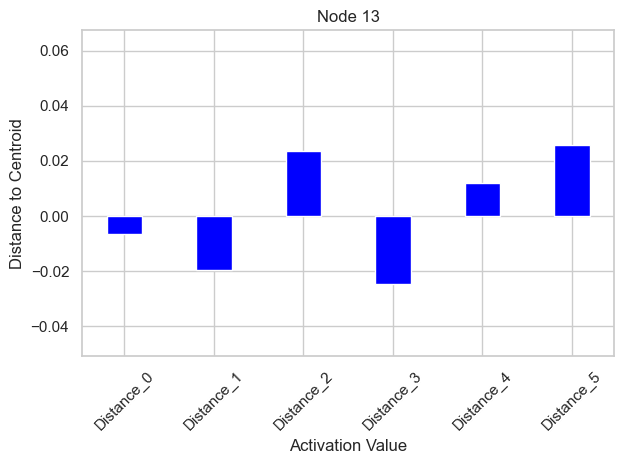

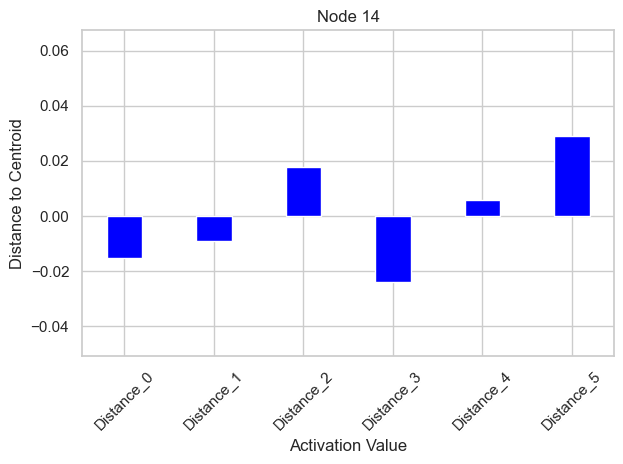

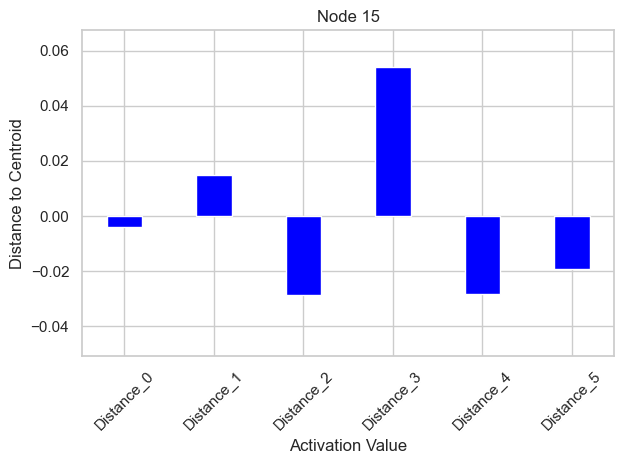

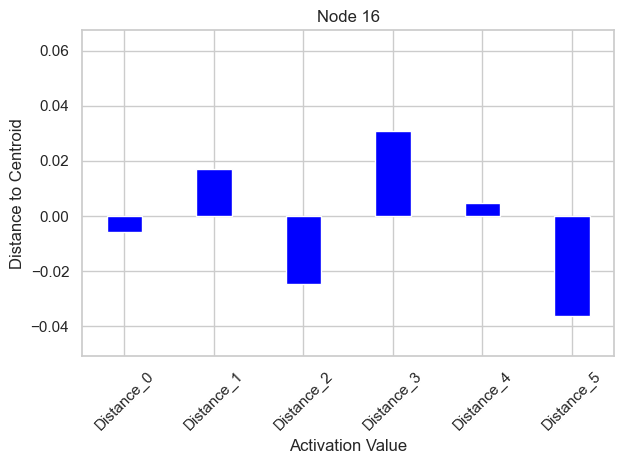

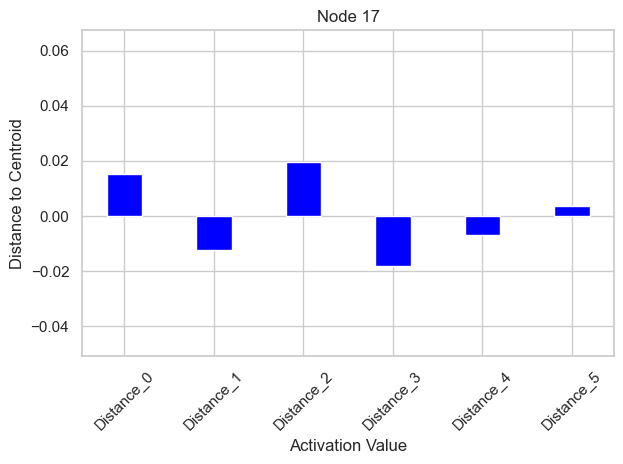

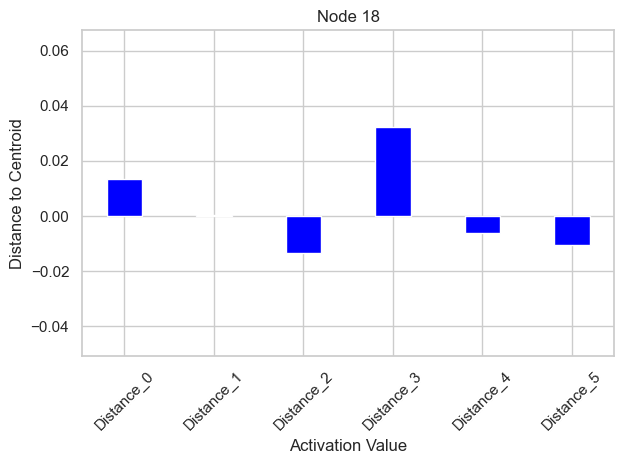

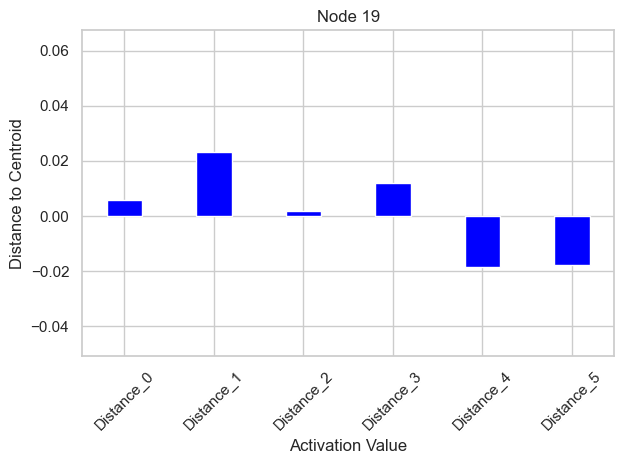

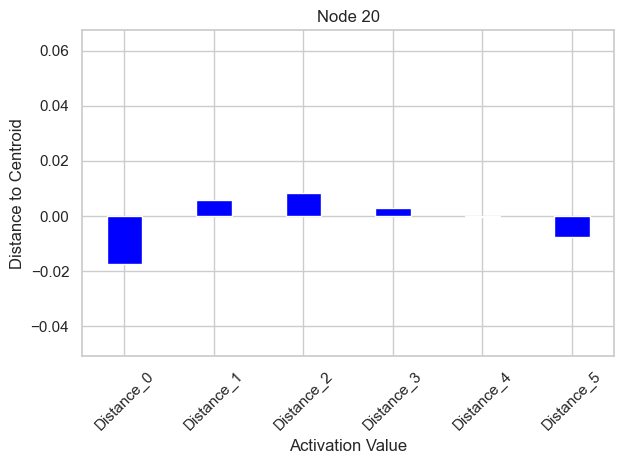

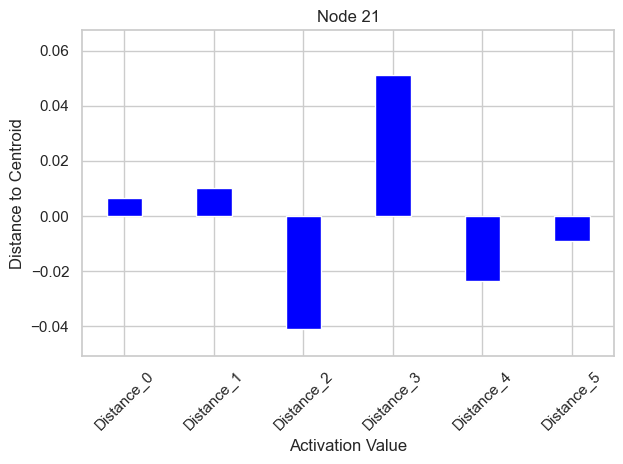

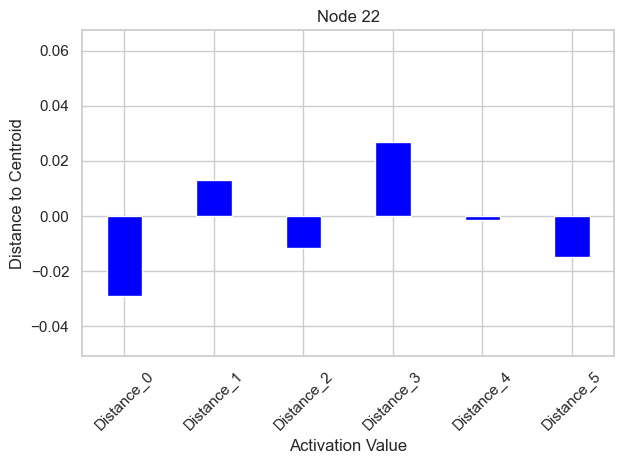

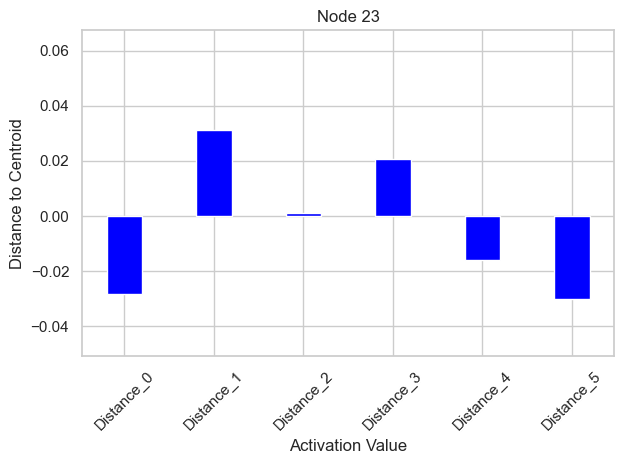

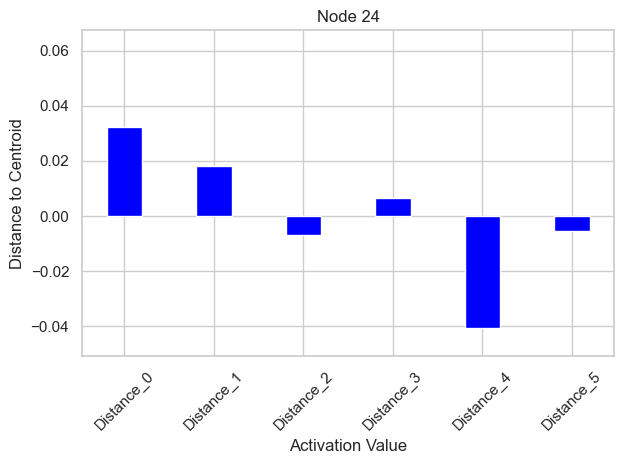

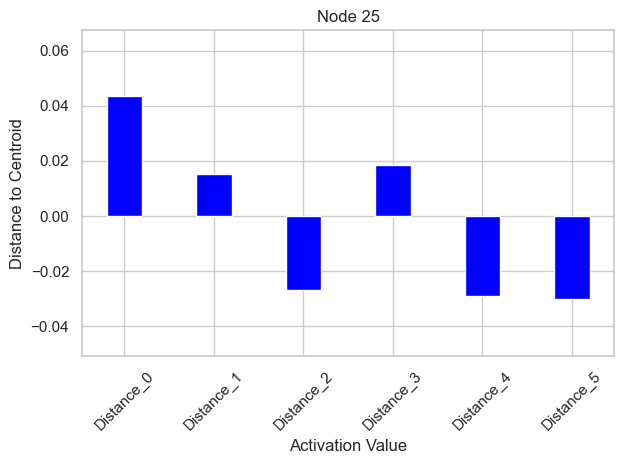

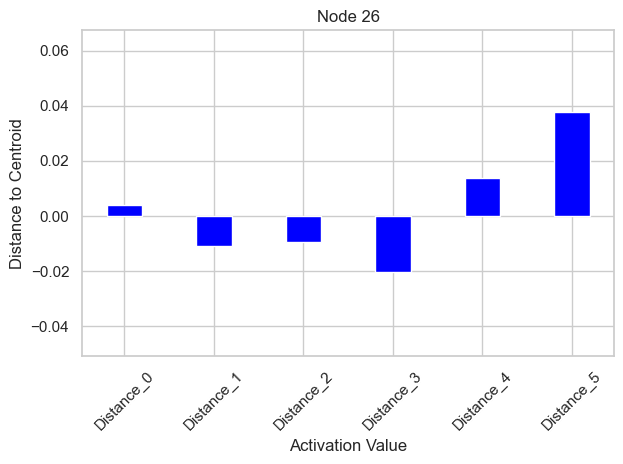

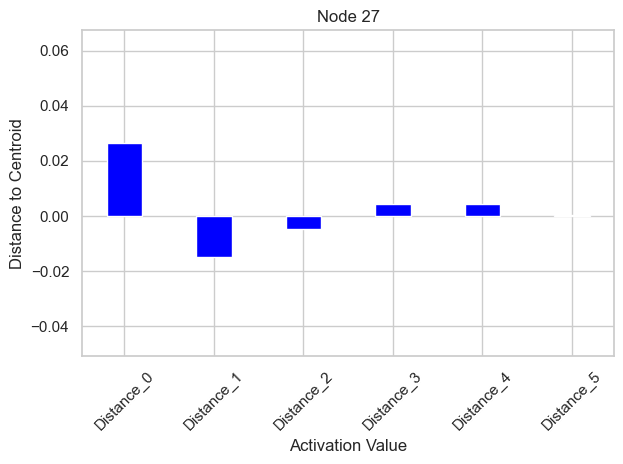

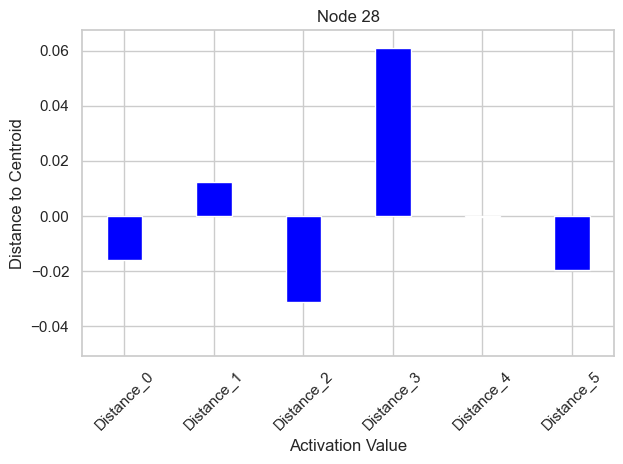

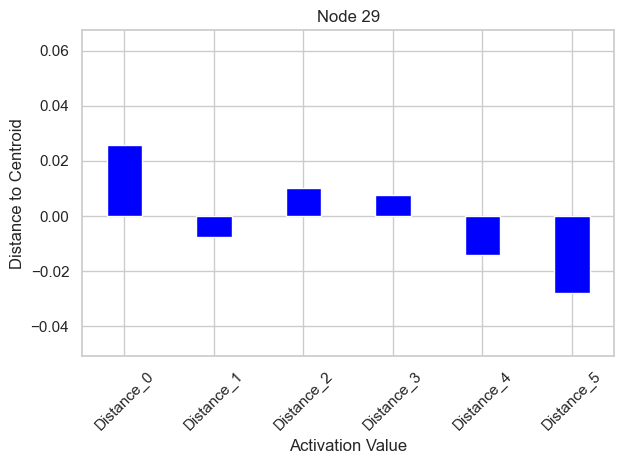

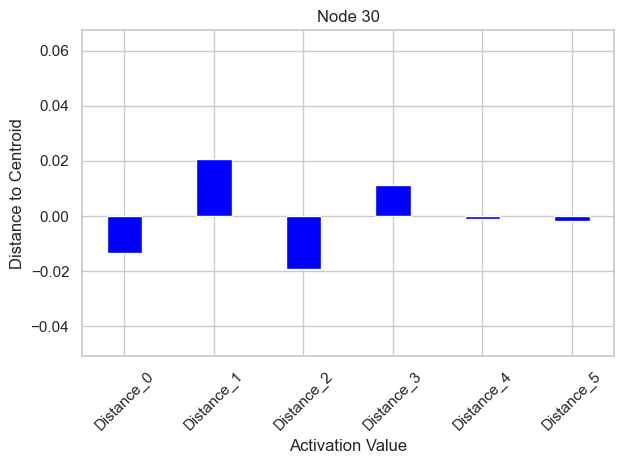

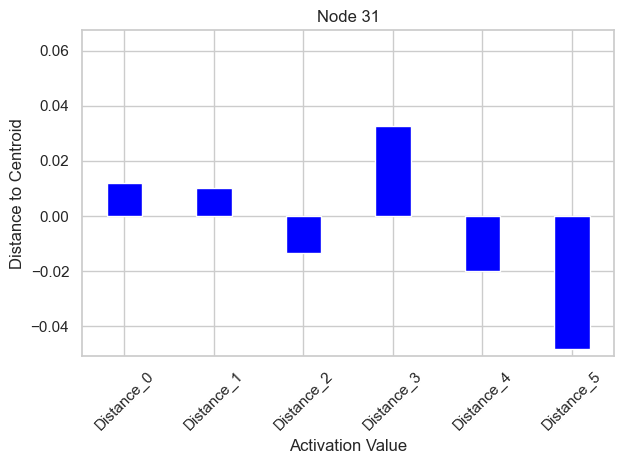

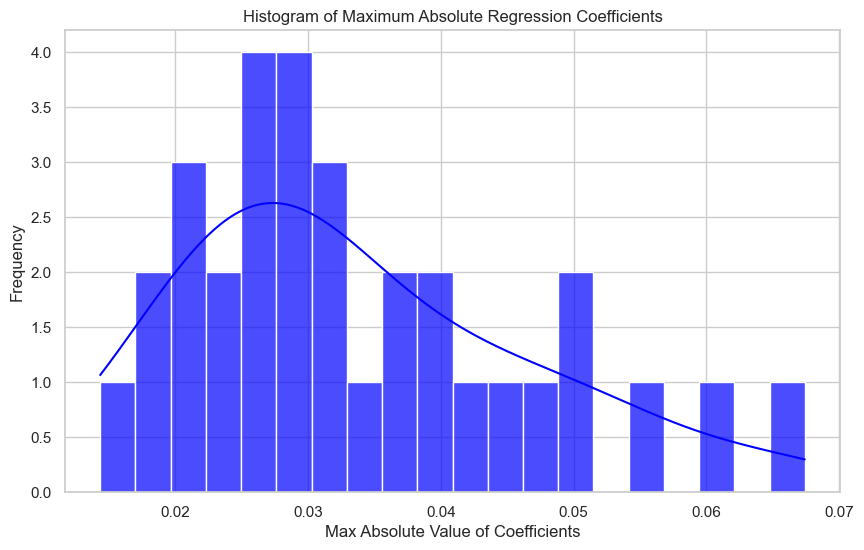

In [140]:


# keep track of the max distance
max_mahalanobis = 0

# move the model
total_input_model = total_input_model.to(device)

features_list = []


global network_layer_outputs
clear_total_run()


# getting all of the training data for correlation analysis
for features, _ in full_train_loader:

    # move the features to the device
    # features = features.to(device)

    # add it to the features list
    features_list.append(features)

    # pipe it through the model
    outputs = total_input_model(features.to(device))
    
    # save the current passthrough to the list
    save_and_clear_current_pass_through()

# now get all of the outputs
full_aug_model_intermediates = network_layer_outputs
clear_total_run()

# the coefficients for the regressions that I am running
coefficients = []  
lower_bounds = []
max_abs_coefficients = []
upper_bounds = []

# go through each of the intermediate variables in the model and collect them
for i in tqdm(range(len(full_aug_model_intermediates[0][LAYER_IDX][0])), desc="Creating regression between variables..."):

    # now we are going to get the ith element of the array
    current_node = []

    # adding all of the model intermediate values in 
    for j in range(len(full_aug_model_intermediates)):
        for t_element in full_aug_model_intermediates[j][LAYER_IDX][:, i]:
            current_node.append(t_element)


    # perform a regression between this element and the centroid distances

    # initialize a Linear Regression model
    linrg_model = LinearRegression()

    # convert the arrays to np arrays
    all_mahalanobis = np.array(all_mahalanobis)
    current_node = np.array(current_node)

    # print an update
    # print(f"Performing regression {i} between all_mahalanobis and current_node...")
    # print(f"Current Dimensions:\nall_mahalanobis shape{all_mahalanobis.shape}\ncurrent_node shape{current_node.shape}")

    # fit the regression
    linrg_model.fit(all_mahalanobis, current_node)


    # getting the maximum coefficient in the model
    max_abs_coef_index = np.argmax(np.abs(linrg_model.coef_))
    max_abs_model_coefficient = np.abs(linrg_model.coef_[max_abs_coef_index])
    max_abs_coefficients.append(max_abs_model_coefficient)
    
    
    # get the residuals and the standard error
    bound_preds = linrg_model.predict(all_mahalanobis)
    resid_vals = np.sum((current_node - bound_preds)**2)
    model_standard_error = np.sqrt(resid_vals / (len(current_node) - 2)) /  np.sqrt(np.sum((all_mahalanobis - np.mean(all_mahalanobis))**2))

    # now compute the 95% confidence bound for the model
    df = len(current_node) - 2
    t_critical = stats.t.ppf(1-0.025, df)

    # append the upper and lower bounds to the arrays that we are using to keep track
    ci_lower = max_abs_model_coefficient - t_critical * model_standard_error
    ci_upper = max_abs_model_coefficient + t_critical * model_standard_error

    lower_bounds.append(ci_lower)
    upper_bounds.append(ci_upper)
        
        
    # store the coefficient
    coefficients.append(linrg_model.coef_)





# plot the regression coefficients so that we can see what they are doing in the model
coefficients = np.array(coefficients)  

# flatten the array to get a single visualization
flat_coefficients = coefficients.flatten()

sns.set_theme(style="whitegrid")
sns.set_palette("magma")

# plot the information that we got
plt.figure(figsize=(10, 6))
plt.hist(flat_coefficients, bins=30, color='blue')
plt.title('Distribution of Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Frequency')

if SHOULD_SAVE_OUTPUT:
    os.makedirs(os.path.join(curr_run_dir, "full_aug_coeff_hist_plots"), exist_ok=True)
    plt.savefig(dpi=300, fname=os.path.join(curr_run_dir, "full_aug_coeff_hist_plots", "reg_coeff_dist_hist.png"))

plt.show()


# now go through and make subplots for everything that we are doing
print(f"Coefficients Shape: {coefficients.shape}")

# get the number of coefficients for creating subplots
n_coeffs = coefficients.shape[1]

# labels of the coefficients
coeff_labels = [f"Distance_{x}" for x in range(coefficients.shape[1])]

# getting the minimum and the maximum value of the regressions
ymin = np.min(coefficients)
ymax = np.max(coefficients)

# create arrays that have the maximum absolute value coefficien tfrom each of them
# sort the arrays on the max vals now
full_aug_max_abs_values = np.array(max_abs_coefficients)
full_aug_sorted_indices = np.argsort(-full_aug_max_abs_values)


# sort the elements on the argument order
full_aug_sorted_max_abs_values = full_aug_max_abs_values[full_aug_sorted_indices]
full_aug_sorted_lower_bounds = np.array([lower_bounds[i] for i in full_aug_sorted_indices])
full_aug_sorted_upper_bounds = np.array([upper_bounds[i] for i in full_aug_sorted_indices])


# iterate through each of the possible coefficients that we are going to consider
for coeffs_idx in tqdm(range(coefficients.shape[0]), desc="Plotting regression coefficients"):
    
	plt.figure()

	# get the coefficients for that node in the matrix
	# plot on some subplot
	plt.bar(coeff_labels, coefficients[coeffs_idx], color ='blue', width = 0.4)

	# get the labeling information for the graph
	plt.title(f'Node {coeffs_idx}')
	plt.xlabel('Activation Value')
	plt.ylabel('Distance to Centroid')
	plt.xticks(rotation=45)

	# scale the y axis
	plt.ylim(ymin, ymax)

	plt.tight_layout()

	if SHOULD_SAVE_OUTPUT:
		os.makedirs(os.path.join(curr_run_dir, "full_aug_coeff_hist_plots"), exist_ok=True)
		plt.savefig(dpi=300, fname=os.path.join(curr_run_dir, "full_aug_coeff_hist_plots", f"full_plt_coeff_{coeffs_idx}_node.png"))

    

# show the figure that we constructed
plt.show()


# plot the histrogram
plt.figure(figsize=(10, 6))
sns.histplot(full_aug_sorted_max_abs_values, bins=20, kde=True, color='blue', alpha=0.7)
plt.title('Histogram of Maximum Absolute Regression Coefficients')
plt.xlabel('Max Absolute Value of Coefficients')
plt.ylabel('Frequency')  

if SHOULD_SAVE_OUTPUT:
	plt.savefig(dpi=300, fname=os.path.join(curr_run_dir, "full_aug_coeff_hist_plots", "full_aug_abs_coeff.png"))
     
plt.show()


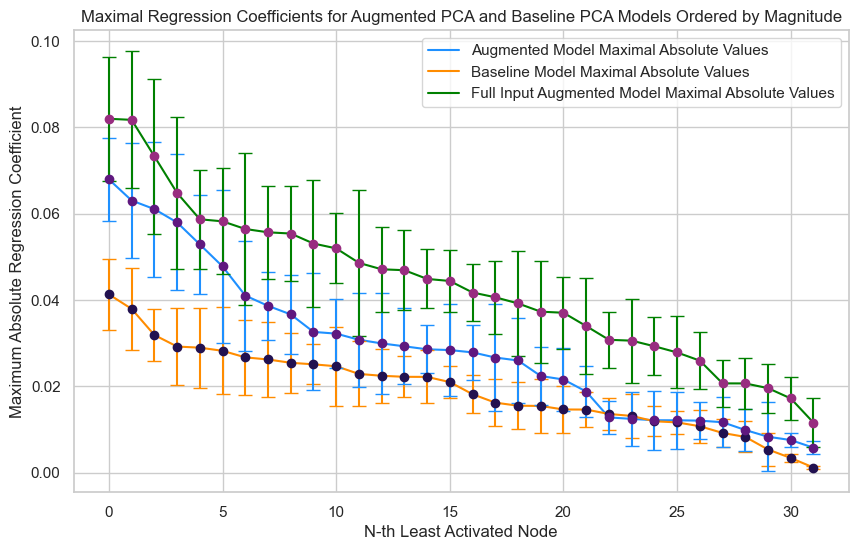

In [58]:
# now get a plot that shows the difference in the max absolute value ofthe coefficients inthe models

full_norm = (all_train_features.shape[1] / pca_train_features.shape[1])

plt.figure(figsize=(10, 6))

# plot both histograms
plt.plot(max_aug_sorted_max_abs_values,
         label='Augmented Model Maximal Absolute Values', color=PLOT_COLOR_2)
plt.plot(max_baseline_sorted_max_abs_values,
         label='Baseline Model Maximal Absolute Values', color=PLOT_COLOR_1)
plt.plot(full_aug_sorted_max_abs_values,
         label='Full Input Augmented Model Maximal Absolute Values', color=PLOT_COLOR_3)
# plt.plot(full_aug_sorted_max_abs_values * full_norm, label='Normalized Full Input Augmented Model Maximal Absolute Values', color=PLOT_COLOR_4)

plt.xlabel('N-th Least Activated Node')
plt.ylabel('Maximum Absolute Regression Coefficient')
plt.title('Maximal Regression Coefficients for Augmented PCA and Baseline PCA Models Ordered by Magnitude')
plt.legend()

plt.errorbar(x=np.arange(len(max_baseline_sorted_max_abs_values)),
             y=max_baseline_sorted_max_abs_values,
             yerr=[max_baseline_sorted_max_abs_values - max_baseline_sorted_lower_bounds,
                   max_baseline_sorted_upper_bounds - max_baseline_sorted_max_abs_values],
             fmt='o', ecolor=PLOT_COLOR_1, capsize=5, label='95% Confidence Interval')


plt.errorbar(x=np.arange(len(max_aug_sorted_max_abs_values)),
             y=max_aug_sorted_max_abs_values,
             yerr=[max_aug_sorted_max_abs_values - max_aug_sorted_lower_bounds,
                   max_aug_sorted_upper_bounds - max_aug_sorted_max_abs_values],
             fmt='o', ecolor=PLOT_COLOR_2, capsize=5, label='95% Confidence Interval')

plt.errorbar(x=np.arange(len(full_aug_sorted_max_abs_values)),
             y=full_aug_sorted_max_abs_values,
             yerr=[full_aug_sorted_max_abs_values - full_aug_sorted_lower_bounds,
                   full_aug_sorted_upper_bounds - full_aug_sorted_max_abs_values],
             fmt='o', ecolor=PLOT_COLOR_3, capsize=5, label='95% Confidence Interval')

# plt.errorbar(x=np.arange(len(full_aug_sorted_max_abs_values)),
#              y=full_aug_sorted_max_abs_values*full_norm,
#              yerr=[full_aug_sorted_max_abs_values * full_norm - full_aug_sorted_lower_bounds * full_norm,
#                    full_aug_sorted_upper_bounds * full_norm - full_aug_sorted_max_abs_values * full_norm],
#              fmt='o', ecolor=PLOT_COLOR_4, capsize=5, label='95% Confidence Interval')


if SHOULD_SAVE_OUTPUT:
    plt.savefig(os.path.join(
        curr_run_dir, "full_error_bar_aug_vs_baseline_regression_coeffs.png"), dpi=300)

plt.show()

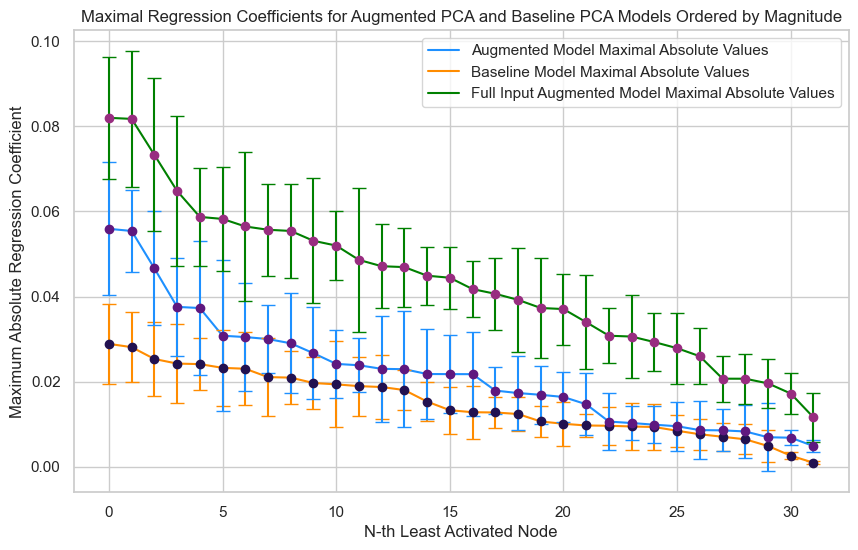

In [60]:
# now get a plot that shows the difference in the max absolute value ofthe coefficients inthe models

full_norm = (all_train_features.shape[1] / pca_train_features.shape[1])

plt.figure(figsize=(10, 6))

# plot both histograms
plt.plot(avg_aug_sorted_max_abs_values,
         label='Augmented Model Maximal Absolute Values', color=PLOT_COLOR_2)
plt.plot(avg_baseline_sorted_avg_abs_values,
         label='Baseline Model Maximal Absolute Values', color=PLOT_COLOR_1)
plt.plot(full_aug_sorted_max_abs_values,
         label='Full Input Augmented Model Maximal Absolute Values', color=PLOT_COLOR_3)
# plt.plot(full_aug_sorted_max_abs_values * full_norm, label='Normalized Full Input Augmented Model Maximal Absolute Values', color=PLOT_COLOR_4)

plt.xlabel('N-th Least Activated Node')
plt.ylabel('Maximum Absolute Regression Coefficient')
plt.title('Maximal Regression Coefficients for Augmented PCA and Baseline PCA Models Ordered by Magnitude')
plt.legend()

plt.errorbar(x=np.arange(len(avg_baseline_sorted_avg_abs_values)),
             y=avg_baseline_sorted_avg_abs_values,
             yerr=[avg_baseline_sorted_avg_abs_values - avg_baseline_sorted_lower_bounds,
                   avg_baseline_sorted_upper_bounds - avg_baseline_sorted_avg_abs_values],
             fmt='o', ecolor=PLOT_COLOR_1, capsize=5, label='95% Confidence Interval')


plt.errorbar(x=np.arange(len(avg_aug_sorted_max_abs_values)),
             y=avg_aug_sorted_max_abs_values,
             yerr=[avg_aug_sorted_max_abs_values - avg_aug_sorted_lower_bounds,
                   avg_aug_sorted_upper_bounds - avg_aug_sorted_max_abs_values],
             fmt='o', ecolor=PLOT_COLOR_2, capsize=5, label='95% Confidence Interval')

plt.errorbar(x=np.arange(len(full_aug_sorted_max_abs_values)),
             y=full_aug_sorted_max_abs_values,
             yerr=[full_aug_sorted_max_abs_values - full_aug_sorted_lower_bounds,
                   full_aug_sorted_upper_bounds - full_aug_sorted_max_abs_values],
             fmt='o', ecolor=PLOT_COLOR_3, capsize=5, label='95% Confidence Interval')

# plt.errorbar(x=np.arange(len(full_aug_sorted_max_abs_values)),
#              y=full_aug_sorted_max_abs_values*full_norm,
#              yerr=[full_aug_sorted_max_abs_values * full_norm - full_aug_sorted_lower_bounds * full_norm,
#                    full_aug_sorted_upper_bounds * full_norm - full_aug_sorted_max_abs_values * full_norm],
#              fmt='o', ecolor=PLOT_COLOR_4, capsize=5, label='95% Confidence Interval')


if SHOULD_SAVE_OUTPUT:
    plt.savefig(os.path.join(
        curr_run_dir, "full_error_bar_aug_vs_baseline_regression_coeffs.png"), dpi=300)

plt.show()

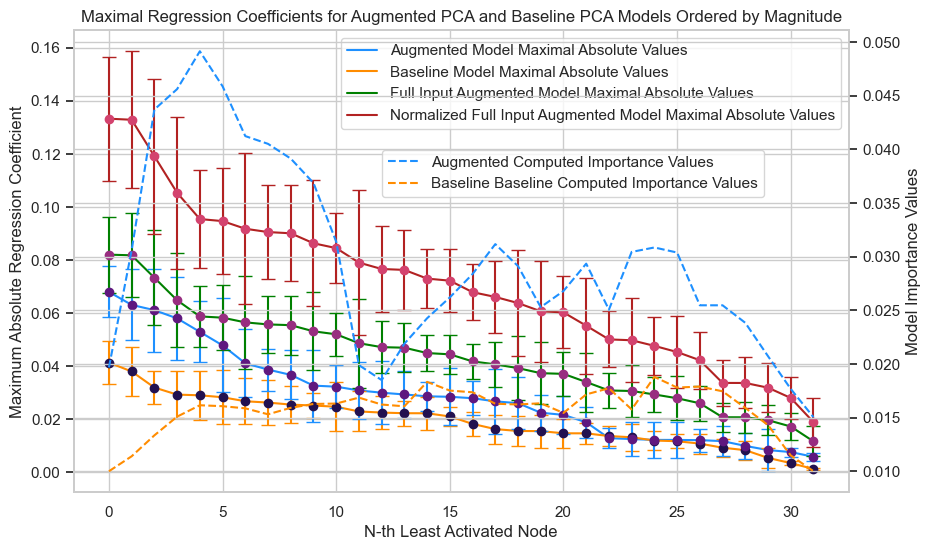

In [79]:
# include the importances of the nodes

full_norm = (all_train_features.shape[1] / pca_train_features.shape[1])

plt.figure(figsize=(10, 6))


# plot both histograms
ax1 = plt.gca()
ax1.plot(max_aug_sorted_max_abs_values,
         label='Augmented Model Maximal Absolute Values', color=PLOT_COLOR_2)
ax1.plot(max_baseline_sorted_max_abs_values,
         label='Baseline Model Maximal Absolute Values', color=PLOT_COLOR_1)
ax1.plot(full_aug_sorted_max_abs_values,
         label='Full Input Augmented Model Maximal Absolute Values', color=PLOT_COLOR_3)
ax1.plot(full_aug_sorted_max_abs_values * full_norm , label='Normalized Full Input Augmented Model Maximal Absolute Values', color=PLOT_COLOR_4)

ax1.set_xlabel('N-th Least Activated Node')
ax1.set_ylabel('Maximum Absolute Regression Coefficient')
ax1.set_title('Maximal Regression Coefficients for Augmented PCA and Baseline PCA Models Ordered by Magnitude')
ax1.legend()

ax1.errorbar(x=np.arange(len(max_baseline_sorted_max_abs_values)),
             y=max_baseline_sorted_max_abs_values,
             yerr=[max_baseline_sorted_max_abs_values - max_baseline_sorted_lower_bounds,
                   max_baseline_sorted_upper_bounds - max_baseline_sorted_max_abs_values],
             fmt='o', ecolor=PLOT_COLOR_1, capsize=5, label='95% Confidence Interval')


ax1.errorbar(x=np.arange(len(max_aug_sorted_max_abs_values)),
             y=max_aug_sorted_max_abs_values,
             yerr=[max_aug_sorted_max_abs_values - max_aug_sorted_lower_bounds,
                   max_aug_sorted_upper_bounds - max_aug_sorted_max_abs_values],
             fmt='o', ecolor=PLOT_COLOR_2, capsize=5, label='95% Confidence Interval')

ax1.errorbar(x=np.arange(len(full_aug_sorted_max_abs_values)),
             y=full_aug_sorted_max_abs_values,
             yerr=[full_aug_sorted_max_abs_values - full_aug_sorted_lower_bounds,
                   full_aug_sorted_upper_bounds - full_aug_sorted_max_abs_values],
             fmt='o', ecolor=PLOT_COLOR_3, capsize=5, label='95% Confidence Interval')

ax1.errorbar(x=np.arange(len(full_aug_sorted_max_abs_values)),
             y=full_aug_sorted_max_abs_values*full_norm ,
             yerr=[(full_aug_sorted_max_abs_values * full_norm - full_aug_sorted_lower_bounds * full_norm) ,
                   (full_aug_sorted_upper_bounds * full_norm - full_aug_sorted_max_abs_values * full_norm) ],
             fmt='o', ecolor=PLOT_COLOR_4, capsize=5, label='95% Confidence Interval')



# this function is used to smooth out the importance
def smooth_importance(i_arr, smooth_len=9):
    s_window = np.ones(smooth_len) / smooth_len
    return np.convolve(i_arr, s_window, mode='same')

smoothed_aug_values = smooth_importance(max_aug_sorted_importance_values)
smoothed_baseline_values = smooth_importance(max_baseline_sorted_importance_values)

# create the other side of the graph
ax2 = ax1.twinx()
ax2.plot(smoothed_aug_values, label='Augmented Computed Importance Values', color=PLOT_COLOR_2, linestyle='--')
# ax2.plot(aug_sorted_importance_values, label='Augmented Computed Importance Values', color=PLOT_COLOR_2, linestyle='--')
ax2.plot(smoothed_baseline_values, label='Baseline Baseline Computed Importance Values', color=PLOT_COLOR_1, linestyle='--')
# ax2.plot(baseline_sorted_importance_values, label='Baseline Baseline Computed Importance Values', color=PLOT_COLOR_1, linestyle='--')
ax2.set_ylabel('Model Importance Values')

legend2 = ax2.legend(loc='center right', bbox_to_anchor=(0.9, 0.69))   

if SHOULD_SAVE_OUTPUT:
    plt.savefig(os.path.join(
        curr_run_dir, "ABSOLUTE_double_importance_full_error_bar_aug_vs_baseline_regression_coeffs.png"), dpi=300)

plt.show()

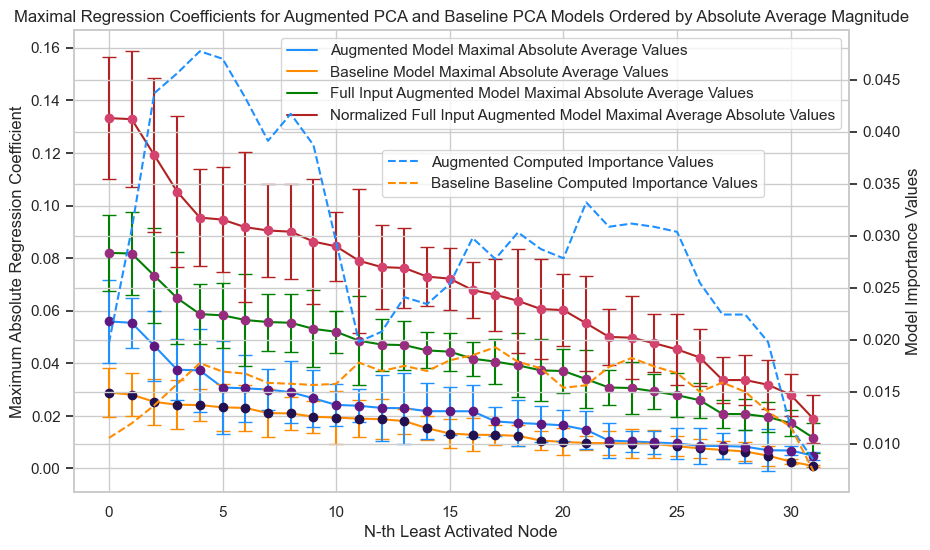

In [78]:
# include the importances of the nodes

full_norm = (all_train_features.shape[1] / pca_train_features.shape[1])

plt.figure(figsize=(10, 6))


# plot both histograms
ax1 = plt.gca()
ax1.plot(avg_aug_sorted_max_abs_values,
         label='Augmented Model Maximal Absolute Average Values', color=PLOT_COLOR_2)
ax1.plot(avg_baseline_sorted_avg_abs_values,
         label='Baseline Model Maximal Absolute Average Values', color=PLOT_COLOR_1)
ax1.plot(full_aug_sorted_max_abs_values,
         label='Full Input Augmented Model Maximal Absolute Average Values', color=PLOT_COLOR_3)
ax1.plot(full_aug_sorted_max_abs_values * full_norm , label='Normalized Full Input Augmented Model Maximal Average Absolute Values', color=PLOT_COLOR_4)

ax1.set_xlabel('N-th Least Activated Node')
ax1.set_ylabel('Maximum Absolute Regression Coefficient')
ax1.set_title('Maximal Regression Coefficients for Augmented PCA and Baseline PCA Models Ordered by Absolute Average Magnitude')
ax1.legend()

ax1.errorbar(x=np.arange(len(avg_baseline_sorted_avg_abs_values)),
             y=avg_baseline_sorted_avg_abs_values,
             yerr=[avg_baseline_sorted_avg_abs_values - avg_baseline_sorted_lower_bounds,
                   avg_baseline_sorted_upper_bounds - avg_baseline_sorted_avg_abs_values],
             fmt='o', ecolor=PLOT_COLOR_1, capsize=5, label='95% Confidence Interval')


ax1.errorbar(x=np.arange(len(avg_aug_sorted_max_abs_values)),
             y=avg_aug_sorted_max_abs_values,
             yerr=[avg_aug_sorted_max_abs_values - avg_aug_sorted_lower_bounds,
                   avg_aug_sorted_upper_bounds - avg_aug_sorted_max_abs_values],
             fmt='o', ecolor=PLOT_COLOR_2, capsize=5, label='95% Confidence Interval')

ax1.errorbar(x=np.arange(len(full_aug_sorted_max_abs_values)),
             y=full_aug_sorted_max_abs_values,
             yerr=[full_aug_sorted_max_abs_values - full_aug_sorted_lower_bounds,
                   full_aug_sorted_upper_bounds - full_aug_sorted_max_abs_values],
             fmt='o', ecolor=PLOT_COLOR_3, capsize=5, label='95% Confidence Interval')

ax1.errorbar(x=np.arange(len(full_aug_sorted_max_abs_values)),
             y=full_aug_sorted_max_abs_values*full_norm ,
             yerr=[(full_aug_sorted_max_abs_values * full_norm - full_aug_sorted_lower_bounds * full_norm) ,
                   (full_aug_sorted_upper_bounds * full_norm - full_aug_sorted_max_abs_values * full_norm) ],
             fmt='o', ecolor=PLOT_COLOR_4, capsize=5, label='95% Confidence Interval')



# this function is used to smooth out the importance
def smooth_importance(i_arr, smooth_len=9):
    s_window = np.ones(smooth_len) / smooth_len
    return np.convolve(i_arr, s_window, mode='same')

smoothed_aug_values = smooth_importance(avg_aug_sorted_importance_values)
smoothed_baseline_values = smooth_importance(avg_baseline_sorted_importance_values)

# create the other side of the graph
ax2 = ax1.twinx()
ax2.plot(smoothed_aug_values, label='Augmented Computed Importance Values', color=PLOT_COLOR_2, linestyle='--')
# ax2.plot(aug_sorted_importance_values, label='Augmented Computed Importance Values', color=PLOT_COLOR_2, linestyle='--')
ax2.plot(smoothed_baseline_values, label='Baseline Baseline Computed Importance Values', color=PLOT_COLOR_1, linestyle='--')
# ax2.plot(baseline_sorted_importance_values, label='Baseline Baseline Computed Importance Values', color=PLOT_COLOR_1, linestyle='--')
ax2.set_ylabel('Model Importance Values')

legend2 = ax2.legend(loc='center right', bbox_to_anchor=(0.9, 0.69))  

if SHOULD_SAVE_OUTPUT:
    plt.savefig(os.path.join(
        curr_run_dir, "AVERAGE_double_importance_full_error_bar_aug_vs_baseline_regression_coeffs.png"), dpi=300)

plt.show()

In [80]:
# # # perform a partial dependence plot for the activations of the nodes and the inputs to the neural network

# # iterate over each input to the model
# num_features = data.shape[1] 
# for feature_index in range(num_features):


# feature_range = np.linspace(data[:, feature_index].min(), data[:, feature_index].max(), 100)
# fixed_data = np.repeat(data.mean(axis=0)[np.newaxis, :], len(feature_range), axis=0)
# fixed_data[:, feature_index] = feature_range

# predictions = model.predict(fixed_data)  # Make sure your model's predict method can handle this

# plt.plot(feature_range, predictions)
# plt.xlabel('Feature Value')
# plt.ylabel('Predicted Output')
# plt.title('Partial Dependence Plot')
# plt.show()


# Testing the Influencing of Only a Single Layer in the Neural network

In this section, we are going to test the impact of only running this scheme of upweighting and downweighting on a single network layer and attempt to measure the effect of it

Registering hooks...


Processing data for epoch:   0%|          | 2/1188 [00:00<02:19,  8.52it/s]

Processing data for epoch: 100%|██████████| 1188/1188 [01:41<00:00, 11.68it/s]


Epoch 1, Loss: 2.111706634763917, Val Loss: 2.1109602668068628


Processing data for epoch: 100%|██████████| 1188/1188 [01:42<00:00, 11.62it/s]


Epoch 2, Loss: 2.111688717647835, Val Loss: 2.1109602668068628


Processing data for epoch: 100%|██████████| 1188/1188 [01:41<00:00, 11.71it/s]


Epoch 3, Loss: 2.1117073221238774, Val Loss: 2.1109602668068628


Processing data for epoch: 100%|██████████| 1188/1188 [01:41<00:00, 11.73it/s]


Stopping early due to increasing validation loss.


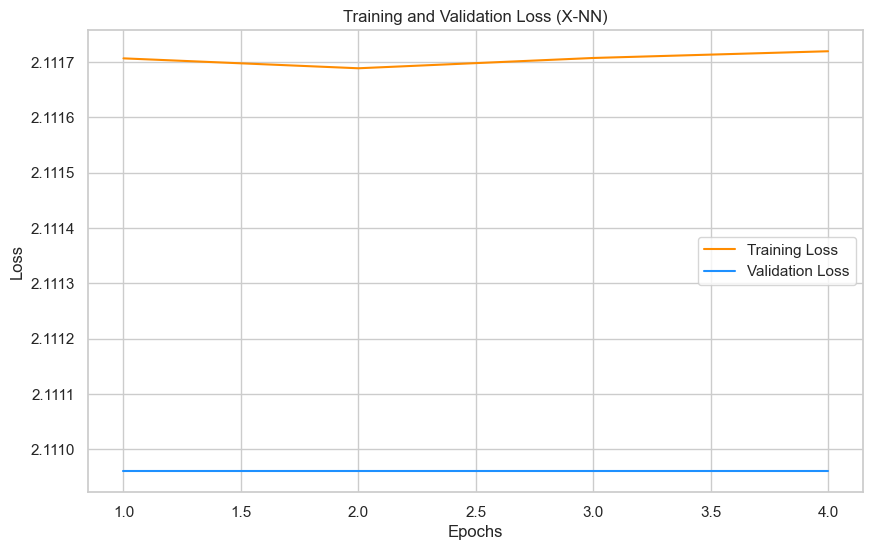

Train Accuracy: 9.08%
File will be saved as: /Users/tristanbrigham/Desktop/Classes/CPSC 471/Final Project/models_save/single_model_save_k_means_centers_13
File will be saved as: /Users/tristanbrigham/Desktop/Classes/CPSC 471/Final Project/runthroughs/run_4/single_model_save_k_means_centers.pth


In [81]:
if TESTING_SINGLE_lAYER:


    # initialize the model
    single_layer_model = NodeImportanceNN()

    # actually register the hooks on the model
    register_hooks(single_layer_model)



    # check if one or the other is not true
    if TRAIN_MODEL and not SHOULD_SAVE_OUTPUT:
        raise ValueError("Incorrect truth table for arguments")



    # train the model with the mahalanobis distances
    if TRAIN_MODEL:
        if USE_BATCHES:
            train_model_with_variance(single_layer_model, pca_train_loader, pca_val_loader, variance_criterion, optimizer, all_mahalanobis, k_means_centers_variable, centroid_passes, verbose=0, epochs=30, limit_layers=True)
        else:
            train_model_with_variance(single_layer_model, pca_train_dataset, pca_val_dataset, variance_criterion, optimizer, all_mahalanobis, k_means_centers_variable, centroid_passes, verbose=0, epochs=30, limit_layers=True)

    else:
        # getting the most recently saved file as the model
        rec_model = get_most_recent_file(SAVE_MODEL_PATH)

        path_for_display = rec_model.replace(' ', '\\ ')
        print(f"Loading model in from {path_for_display}")

        # load the model in from the save path
        single_layer_model = torch.load(rec_model)

    # get the output statistics for the model
    accuracy = accuracy_score(all_train_labels, [np.argmax(t_arr) for t_arr in single_layer_model(pca_train_features.to(device)).cpu().detach().numpy()])
    print("Train Accuracy: {:.2f}%".format(accuracy * 100))


    # saving the model if we have trained it
    if TRAIN_MODEL:

        # generate a unique file name
        unique_dir = generate_unique_file_dir(SAVE_MODEL_PATH, SINGLE_SAVE_FILE_NAME.replace(".pth", f"_{clustering_method_name}"))
        os.makedirs(unique_dir, exist_ok=True)

        # save the file
        print("File will be saved as:", unique_dir)
        torch.save(single_layer_model, os.path.join(unique_dir, SINGLE_SAVE_FILE_NAME))

        # save the information about the clusters and the centroids as well
        info_dict = {}

        # save the information in a dictionary
        info_dict['centroid_num'] = CLUSTER_NUM
        info_dict['centroids'] = k_means_centers_variable

        # open and dump the pickle file
        with open(os.path.join(unique_dir, INFO_DICT_NAME), 'wb') as file:
            pickle.dump(info_dict, file)


    # check if we should save the model to a runthrough
    if SHOULD_SAVE_OUTPUT:

        # generate a unique file name
        # unique_dir = generate_unique_file_dir(SAVE_MODEL_PATH, SAVE_FILE_NAME.replace(".pth", f"_{clustering_method.__name__}"))

        # save the file
        f_save_path = os.path.join(curr_run_dir, SINGLE_SAVE_FILE_NAME.replace(".pth", f"_{clustering_method_name}.pth"))
        print("File will be saved as:", f_save_path)
        torch.save(single_layer_model, f_save_path)

        # save the information about the clusters and the centroids as well
        info_dict = {}

        # save the information in a dictionary
        info_dict['centroid_num'] = CLUSTER_NUM
        info_dict['centroids'] = k_means_centers_variable

        # open and dump the pickle file
        with open(os.path.join(curr_run_dir, INFO_DICT_NAME), 'wb') as file:
            pickle.dump(info_dict, file)



In [82]:
single_layer_pred = [np.argmax(t_arr) for t_arr in single_layer_model(pca_val_features.to(device)).cpu().detach().numpy()]
accuracy = accuracy_score(all_val_labels, single_layer_pred)
print("Validation Accuracy: {:.2f}%".format(accuracy * 100))
print("Kappa Cohen: {:.5f}".format(eval_wrapper(all_val_labels, single_layer_pred)))

Validation Accuracy: 8.66%
Kappa Cohen: 0.01163


# Start of Importance Reduction Formula

This is the start of the development of the importance reduction equation which will lower the importance of certain inputs to the network. We are going to try a series of analyses to try to understand how to optimally remove the influence of a single input on the neural network that we are considering. We are going to try to find how long each of the methods that we detail takes along with the degradation in accuracy compared to baseline. Some methods that we plan to explore are below, but there likely will not be enough time to explore all of the method:

- simple retraining: this is going to serve as the baseline that we compare the rest of the methdos that we try against. We are going to remove one of the inputs from the model, and train the model to see how the model does along with how long it takes. 
- stochastic fine-tuning: this method takes the original dataset and fine-tunes the model where the input feature that we are trying to mask has a stochastic value in place of the real value for each instance that we process in the dataset.
- inversion fine-tuning: similar to the stochastic method, this method takes the input tensors that we used to originally train the model but changes the feature that we are trying to remove to an inverted version of the original data point. That is, given the original datapoint feature $x$ and the mean of the feature over the entire dataset $x'$, we fine-tune the model using the save input data but with x changed to $x = x - 2 \cdot (x - x')$. We explore whether using the mean is the optimal configuration as well. 
- amplitude-influence reduction: in this method, we actually manipulate the weights of the model to try to approximate the original output of the model while enforcing all weights coming out of the node that we target in the model remain equal to 0. If the node hthat we are tring to limit the influence of is an inut node, then we can fine-tune the model after to ensure that the output is approximated as closely as possible. Otherwise, we simply have to keep the model as is after the weight manipulation or the concept could become dispersed through other nodes and flow to a later layer. 
- amplitude-influence reduction (extended): an extension of this method would be to use the covariance of the individual activations from layer $i-1$ to supplement the removal of a single node in layer $i-1$ totally. In order to do this, I find the covariance of all of the outputs of the layer and greedily add influenece from the nodes that have the highest magnitude covariance on all of the outputs that have lost the influence of the selected node. I adjust the bias in the process if possible as well. 

In [122]:
TRAIN_PCA = False
BASELINE_IMPORTANCE_SAVE_FILE_NAME = "manipulate_nn.pth"
RUN_TIMES = 5

# this is the last PCA component
# in the first layer
FEATURE_NUM = 7
LAYER_NUM = 0

In [123]:
# turn the training data into a dataset
importance_pca_train_loader = TensorDataset(pca_train_features, all_train_labels)
importance_pca_val_loader = TensorDataset(pca_val_features, all_val_labels)
importance_pca_test_loader = TensorDataset(pca_test_features, all_test_labels)

# define the loaders
importance_pca_train_loader = DataLoader(importance_pca_train_loader, batch_size=BATCH_SIZE, shuffle=True)
importance_pca_val_loader = DataLoader(importance_pca_val_loader, batch_size=BATCH_SIZE, shuffle=False)
importance_pca_test_loader = DataLoader(importance_pca_test_loader, batch_size=BATCH_SIZE, shuffle=False)

if TRAIN_PCA:
    importance_train_loader = importance_pca_train_loader
    importance_test_loader = importance_pca_test_loader
    importance_val_loader = importance_pca_val_loader


t_input, _ = next(iter(importance_train_loader))
t_input_shape = t_input.shape[1]

print(f'Input shape: {t_input_shape}')

# now get the k centroids that would represent the center of the clusters that
# I would get if I ran a k-means clustering algorithm
print(f"Computing theoretical clustering centroids...")

Input shape: 10
Computing theoretical clustering centroids...


In [124]:

# these are helper functions that help us to monitor the output of the neural network layers and 
# attach hooks to the neural network that helps us get the forward pass values
influence_network_layer_outputs = []
influence_network_current_pass_through = []

# define the hook to get the forward pass through the neural network
def node_importance_get_layer_output_hook(module, input, output):

    global influence_network_current_pass_through

    # append the output of this passthrough to the total array
    influence_network_current_pass_through.append(output.cpu().detach())  

# register the hooks with the network
def node_importance_register_hooks(model):

    # print(f"Registering hooks...")

    # check each of the layers for somewhere where we can register a hook
    for layer in model.children():

        # check for an instance of a layer
        if isinstance(layer, nn.Module):

            # register a forward hook
            layer.register_forward_hook(node_importance_get_layer_output_hook)

            # give the staus
            # print(f"Registered a forward hook at: {layer}")

# start a new pass of the model that we are running with specified inputs
def node_importance_start_new_pass_through_with_input(inputs):
    global influence_network_current_pass_through
    influence_network_current_pass_through = [inputs]

# start a new pass of the model that we are running
def node_importance_start_new_pass_through():
    global influence_network_current_pass_through
    influence_network_current_pass_through = []

# clear the current pass through
def node_importance_save_and_clear_influence_network_current_pass_through():
    global influence_network_layer_outputs, influence_network_current_pass_through
    influence_network_layer_outputs.append(influence_network_current_pass_through)

    node_importance_start_new_pass_through()

# this function entirely wipes the storage of the intermediate values
def node_importance_clear_total_run():
    global influence_network_layer_outputs
    influence_network_layer_outputs = []

# function to return and clear the entire training series
def node_importance_retrieve_and_return_entire_network_outputs():
    global influence_network_layer_outputs
    t_ret = influence_network_layer_outputs
    influence_network_layer_outputs = []
    return t_ret

# Start of Importance Reduction Formula

This is the start of the development of the importance reduction equation which will lower the importance of certain inputs to the network. We are going to try a series of analyses to try to understand how to optimally remove the influence of a single input on the neural network that we are considering. We are going to try to find how long each of the methods that we detail takes along with the degradation in accuracy compared to baseline. Some methods that we plan to explore are below, but there likely will not be enough time to explore all of the method:

- simple retraining: this is going to serve as the baseline that we compare the rest of the methdos that we try against. We are going to remove one of the inputs from the model, and train the model to see how the model does along with how long it takes. 
- stochastic fine-tuning: this method takes the original dataset and fine-tunes the model where the input feature that we are trying to mask has a stochastic value in place of the real value for each instance that we process in the dataset.
- inversion fine-tuning: similar to the stochastic method, this method takes the input tensors that we used to originally train the model but changes the feature that we are trying to remove to an inverted version of the original data point. That is, given the original datapoint feature $x$ and the mean of the feature over the entire dataset $x'$, we fine-tune the model using the save input data but with x changed to $x = x - 2 \cdot (x - x')$. We explore whether using the mean is the optimal configuration as well. 
- amplitude-influence reduction: in this method, we actually manipulate the weights of the model to try to approximate the original output of the model while enforcing all weights coming out of the node that we target in the model remain equal to 0. If the node that we are tring to limit the influence of is an input node, then we can fine-tune the model after to ensure that the output is approximated as closely as possible. Otherwise, we simply have to keep the model as is after the weight manipulation or the concept could become dispersed through other nodes and flow to a later layer. One way to improve the effectiveness of this method would be to use the covariance of the individual activations from layer $i-1$ to supplement the removal of a single node in layer $i-1$ totally. In order to do this, I find the covariance of all of the outputs of the layer and greedily add influenece from the nodes that have the highest magnitude covariance on all of the outputs that have lost the influence of the selected node. I adjust the bias in the process if possible as well. Please note that the code below hardcodes the influence function for the first layer, but this can be changed with some adjustments. Additionally, because of the nature of PCA, this function does not perform well with the PCA loader. 

I start with simply trying to remove the influence of one of the inputs to the model. If there is time, I will extend this to deeper layers of the model. 

Epoch 1, Loss: 1.6033590416916292, Val Loss: 1.558383381326592
Epoch 2, Loss: 1.5315525046101324, Val Loss: 1.5340711488466874
Epoch 3, Loss: 1.51809810769277, Val Loss: 1.5276652060775242
Epoch 4, Loss: 1.5106960272146797, Val Loss: 1.525569038760381
Epoch 5, Loss: 1.506433218516886, Val Loss: 1.5229971493133392
Epoch 6, Loss: 1.503618161937203, Val Loss: 1.517178804384739
Epoch 7, Loss: 1.4998747393338367, Val Loss: 1.5124696513217708
Epoch 8, Loss: 1.498046059399743, Val Loss: 1.5138493981024232
Epoch 9, Loss: 1.4962650375936168, Val Loss: 1.5094468673873027
Epoch 10, Loss: 1.493912287432738, Val Loss: 1.5092032906985042
Epoch 11, Loss: 1.4926273416389118, Val Loss: 1.5071766902300645
Epoch 12, Loss: 1.491253646836939, Val Loss: 1.5054927201383443
Epoch 13, Loss: 1.4900723461952274, Val Loss: 1.5091893994045578
Epoch 14, Loss: 1.488780890199472, Val Loss: 1.507155221319359
Epoch 15, Loss: 1.4879364416454777, Val Loss: 1.50462868077185
Epoch 16, Loss: 1.4867985160262496, Val Loss: 1.

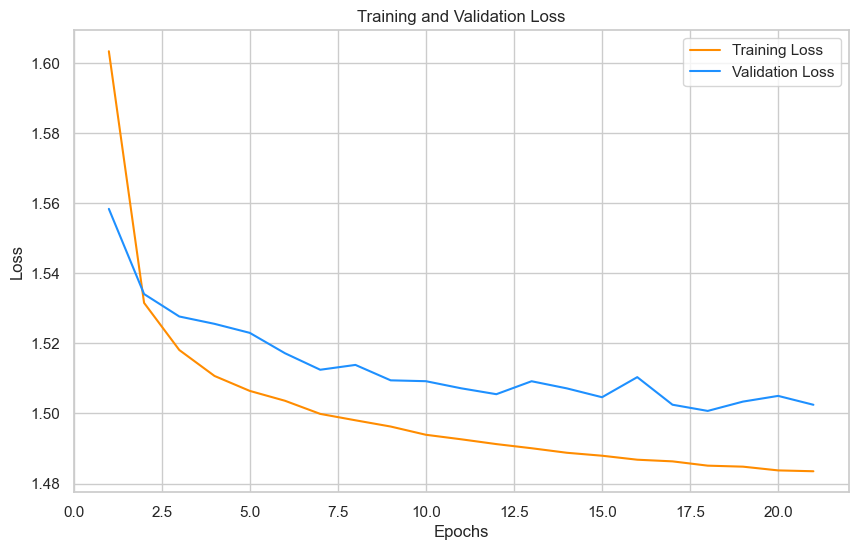

In [125]:
# start by defining a model that we are going to analyze and change

##
# this function is used to train the neural network that we are going to be using for classification of the items that 
# we are considering for insurance and for prisoners
def train_model_node_importance(model, train_loader, val_loader, loss_function, optimizer, epochs=10, patience=2):
    best_val_loss = float('inf')
    patience_counter = 0

    # lists to store loss values for plotting
    train_losses = []
    val_losses = []
    epochs_list = []


    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                val_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        epoch_val_loss = val_loss / len(val_loader)
        # print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Val Loss: {epoch_val_loss}')

        train_losses.append(epoch_loss)
        val_losses.append(epoch_val_loss)
        epochs_list.append(epoch + 1)

        # check if the validation loss improved
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience_counter = 0
        
        else:
            patience_counter += 1

        # check for early stopping
        if patience_counter > patience:
            print("Stopping early due to increasing validation loss.")
            break

        # print the statistics from this epoch
        print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Val Loss: {epoch_val_loss}')

    # plotting the training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_list, train_losses, label='Training Loss', color=PLOT_COLOR_1)
    plt.plot(epochs_list, val_losses, label='Validation Loss', color=PLOT_COLOR_2)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    if SHOULD_SAVE_OUTPUT:
        plt.savefig(os.path.join(curr_run_dir, "nn_loss.png"))

    plt.show()


t_input, _ = next(iter(importance_train_loader))
t_input_shape = t_input.shape[1]

# neural network for the insurance dataset
# as a baseline for the model
class ImportanceInsuranceNN(nn.Module):

    # initialize the insurance neural network item
    def __init__(self):
        super(ImportanceInsuranceNN, self).__init__()
        self.foward_1 = nn.Linear(t_input_shape, 32)
        self.foward_2 = nn.Linear(32, 16)
        self.foward_3 = nn.Linear(16, NUM_CLASSES)  

    # go forward through the neural network
    def forward(self, x):
        x = F.relu(self.foward_1(x))
        x = F.relu(self.foward_2(x))
        x = self.foward_3(x)
        return x

importance_baseline_model = ImportanceInsuranceNN()

# define the loss function and optimizer that we are going to be using to train the neural network
importance_loss_function = nn.CrossEntropyLoss()
importance_optimizer = optim.Adam(importance_baseline_model.parameters(), lr=0.001)

# training the model
train_model_node_importance(importance_baseline_model, importance_train_loader, importance_val_loader, importance_loss_function, importance_optimizer, epochs=30)

# saving the model to a state dictionary
torch.save(importance_baseline_model, os.path.join(curr_run_dir, BASELINE_IMPORTANCE_SAVE_FILE_NAME))

In [128]:



# first bit of importance computation
initial_importance = compute_importance_GRAD(importance_baseline_model, importance_train_loader)
print(f"Initial importance of feature {FEATURE_NUM} in layer {LAYER_NUM}:")

for l_num in range(len(initial_importance)):
	print(f"{l_num} : {len(initial_importance[l_num])} | {sum(initial_importance[l_num]):.2f}")

# print the importance
print(f"Importance to output: {initial_importance[0][5]}")

print()
print(initial_importance[0])

Initial importance of feature 7 in layer 0:
0 : 10 | 1.00
1 : 32 | 1.00
2 : 16 | 1.00
Importance to output: 0.1619533896446228

[0.14749005 0.08602081 0.13260457 0.10926215 0.08689249 0.16195339
 0.07142986 0.07523763 0.07323179 0.05587729]


In [131]:
# now set a target node that we are going to try to minimize the effect of
# we are going to run each of the functions RUN_TIMES times to get an average time score
# method_function: the method that we are using to try to remove the influence. the arguments to the funciton are standardized
# input_model: this is the model that we want to remove the influence from
# layer: the layer that we want to be targeting with the influence depreciation
# node_num: the number node in the layer that we want to be limiting the influence of
# train_loader: this is the loader that we should be using to pull the training data
# val_loader: this is the validation dataset loader that we are going to use to evaluate the model
def remove_influence(method_function, input_model, layer, node_num, train_loader, val_loader, epochs=10, patience=2):

	# print the method that we ar eusing
	print(f"Removing influence with {method_function.__name__}")

	# the amount of time that it took for each iteration
	time_arr = []

	val_loss_arr = []
	train_loss_arr = []

	# keeping track of the importance of the input
	ret_importance_arr = []

	# make a copy of the input model
	input_model = input_model.to(device)
	new_input_model = copy.deepcopy(input_model)

	# measure the influence of the feature that we are trying to cancel on the model
	target_feature_initial_importance = compute_importance_GRAD(baseline_model, val_loader)[layer][node_num]

	# compute the metrics for the original model
	input_model.eval()
	orig_train_loss = 0.0
	with torch.no_grad():
		for inputs, labels in train_loader:
			outputs = input_model(inputs.to(device))
			loss = importance_loss_function(outputs, labels.to(device))
			orig_train_loss += loss.item()

	orig_train_loss = orig_train_loss / len(train_loader)

	orig_val_loss = 0.0
	with torch.no_grad():
		for inputs, labels in val_loader:
			outputs = input_model(inputs.to(device))
			loss = importance_loss_function(outputs, labels.to(device))
			orig_val_loss += loss.item()
	orig_val_loss = orig_val_loss / len(val_loader)

	
	# how many times are we going to run the operation
	for run_instance in range(RUN_TIMES):

		# get the timer going
		start_time = time.time()

		# run the function
		# each of the functions shoudl return a dictionary with at least the accuracy of the model that came out of the method
		ret_dict = method_function(input_model=new_input_model, layer=layer, node_num=node_num, train_loader=train_loader, val_loader=val_loader, epochs=epochs, patience=patience)

		# get the end time
		end_time = time.time()

		# add the val and train loss to the array
		val_loss_arr.append(ret_dict['best_val_loss'])
		train_loss_arr.append(ret_dict['train_loss'])
		ret_importance_arr.append(ret_dict['node_importance'])

		# add the seconds that it took to the time array
		time_arr.append(end_time - start_time)

	# get the average runtime
	avg_runtime	= np.array(time_arr).mean()
	avg_train_loss = np.array(train_loss_arr).mean()
	avg_val_loss = np.array(val_loss_arr).mean()
	avg_importance = np.array(ret_importance_arr).mean()

	# print how long that took
	print(f"Took {(avg_runtime):.4f} seconds on average for")
	print(f"avg_train_loss: {avg_train_loss:.4f} ({(100 * ((avg_train_loss - orig_train_loss) / orig_train_loss)):.2f}%)")
	print(f"avg_val_loss: {avg_val_loss:.4f} ({(100 * ((avg_val_loss - orig_val_loss) / orig_val_loss)):.2f}%)")
	print(f"importance: {(avg_importance):.4f} ({(100 * ((avg_importance - target_feature_initial_importance) / target_feature_initial_importance)):.2f}%)")
	print()

	return avg_runtime


# start with the easiest version -- simple retraining of the entire machine learning model
# each of these functions is going to return a dictionary that has all of the important metrics about the machine learning model
# since it doesn't make sense to remove a feature deeper in the machine learning model during simple retraining
# since that concept will just be represented in other nodes, we only do this for input features as a baseline
def simple_retraining(input_model=None, layer=None, node_num=None, train_loader=None, val_loader=None, epochs=10, patience=2, verbose=False):

	# check that the layer and the feature that we are changing the influence of are legitimate
 	# the layer is zero-indexed
	if layer is None:
		raise ValueError("Invalid layer passed to the function")

	if node_num is None:
		raise ValueError("Invalid node_num passed to the function")

	if train_loader is None:
		raise ValueError("Invalid train_loader passed to the function")

	if val_loader is None:
		raise ValueError("Invalid val_loader passed to the function")


	# neural network for the insurance dataset
	# as a baseline for the model
	class SimpleRetrainInsuranceNN(nn.Module):

		# initialize the insurance neural network item
		def __init__(self):
			super(SimpleRetrainInsuranceNN, self).__init__()
			self.foward_1 = nn.Linear(t_input_shape - 1, 32)
			self.foward_2 = nn.Linear(32, 16)
			self.foward_3 = nn.Linear(16, NUM_CLASSES)   

		# go forward through the neural network
		def forward(self, x):
			x = F.relu(self.foward_1(x))
			x = F.relu(self.foward_2(x))
			x = self.foward_3(x)
			return x
		
	# initialize a new model 
	new_input_model = SimpleRetrainInsuranceNN()

	importance_loss_function = nn.CrossEntropyLoss()
	optimizer = optim.Adam(new_input_model.parameters(), lr=0.001)

	# retrain the model blocking the one input
	best_val_loss = float('inf')
	patience_counter = 0

	# lists to store loss values for plotting
	train_losses = []
	val_losses = []
	epochs_list = []

	for epoch in range(epochs):
		new_input_model.train()
		running_loss = 0.0

		for inputs, labels in train_loader:

			inputs = torch.cat((inputs[:, :node_num], inputs[:, node_num+1:]), dim=1)
			
			optimizer.zero_grad()
			outputs = new_input_model(inputs)
			loss = importance_loss_function(outputs, labels)
			loss.backward()
			optimizer.step()
			running_loss += loss.item()

		new_input_model.eval()
		val_loss = 0.0
		with torch.no_grad():
			for inputs, labels in val_loader:

				inputs = torch.cat((inputs[:, :node_num], inputs[:, node_num+1:]), dim=1)
				outputs = new_input_model(inputs)
				loss = importance_loss_function(outputs, labels)
				val_loss += loss.item()

		epoch_loss = running_loss / len(train_loader)
		epoch_val_loss = val_loss / len(val_loader)
		# print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Val Loss: {epoch_val_loss}')

		train_losses.append(epoch_loss)
		val_losses.append(epoch_val_loss)
		epochs_list.append(epoch + 1)

		# check if the validation loss improved
		if epoch_val_loss < best_val_loss:
			best_val_loss = epoch_val_loss
			patience_counter = 0
		
		else:
			patience_counter += 1

		# check for early stopping
		if patience_counter > patience and verbose:
			print("Stopping early due to increasing validation loss.")
			break

		# print the statistics from this epoch
		if verbose:
			print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Val Loss: {epoch_val_loss}')

	# return a dictionary with the final values that are important
	return {
		'best_val_loss': best_val_loss,
		'train_loss': running_loss / len(train_loader),
		'val_loss': val_loss / len(val_loader),
		'node_importance': 0, # if the input is not there then it literally cannot have influence on the output
	}



# now do stochastic fine-tuning to see what the impact on the influence of the input feature is
def stochastic_fine_tuning(input_model=None, layer=None, node_num=None, train_loader=None, val_loader=None, epochs=10, patience=2, verbose=False):

	# check that the layer and the feature that we are changing the influence of are legitimate
 	# the layer is zero-indexed
	if layer is None: 
		raise ValueError("Invalid layer passed to the function")
	
	if input_model is None: 
		raise ValueError("Invalid input_model passed to the function")

	if node_num is None:
		raise ValueError("Invalid node_num passed to the function")

	if train_loader is None:
		raise ValueError("Invalid train_loader passed to the function")

	if val_loader is None:
		raise ValueError("Invalid val_loader passed to the function")


	importance_loss_function = nn.CrossEntropyLoss()
	optimizer = optim.Adam(input_model.parameters(), lr=0.001)

	# computing the mean of the feature that we are trying to limit the influence of across the entire dataset
	total_sum = 0
	total_count = 0
	input_model.eval() 
	with torch.no_grad():
		for inputs, _ in train_loader:
			total_sum += inputs[:, node_num].sum()
			total_count += inputs[:, node_num].numel()
	global_mean = total_sum / total_count

	# retrain the model blocking the one input
	best_val_loss = float('inf')
	patience_counter = 0

	# lists to store loss values for plotting
	train_losses = []
	val_losses = []
	epochs_list = []

	for epoch in range(epochs):
		input_model.train()
		running_loss = 0.0

		for inputs, labels in train_loader:

			# replace the feature that we are removing with a random variable
			inputs[:, node_num] = torch.randn_like(inputs[:, node_num]) + global_mean
			
			optimizer.zero_grad()
			outputs = input_model(inputs)
			loss = importance_loss_function(outputs, labels)
			loss.backward()
			optimizer.step()
			running_loss += loss.item()

		input_model.eval()
		val_loss = 0.0
		with torch.no_grad():
			for inputs, labels in val_loader:

				# replace the feature that we are removing with a random variable
				inputs[:, node_num] = torch.randn_like(inputs[:, node_num]) + global_mean

				outputs = input_model(inputs)
				loss = importance_loss_function(outputs, labels)
				val_loss += loss.item()

		epoch_loss = running_loss / len(train_loader)
		epoch_val_loss = val_loss / len(val_loader)
		# print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Val Loss: {epoch_val_loss}')

		train_losses.append(epoch_loss)
		val_losses.append(epoch_val_loss)
		epochs_list.append(epoch + 1)

		# check if the validation loss improved
		if epoch_val_loss < best_val_loss:
			best_val_loss = epoch_val_loss
			patience_counter = 0
		
		else:
			patience_counter += 1

		# check for early stopping
		if patience_counter > patience and verbose:
			print("Stopping early due to increasing validation loss.")
			break

		# print the statistics from this epoch
		if verbose:
			print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Val Loss: {epoch_val_loss}')


	# compute the importance of the feature that we are trying to limit the influence of
	node_importance = compute_importance_GRAD(input_model, val_loader)[layer][node_num]

	# return a dictionary with the final values that are important
	return {
		'best_val_loss': best_val_loss,
		'train_loss': running_loss / len(train_loader),
		'val_loss': val_loss / len(val_loader),
		'node_importance': node_importance,
	}




# now do inversion fine-tuning where we try to remove the information that is contained in 
# the variable from the model training
def inversion_fine_tuning(input_model=None, layer=None, node_num=None, train_loader=None, val_loader=None, epochs=10, patience=2, verbose=False):

	# check that the layer and the feature that we are changing the influence of are legitimate
 	# the layer is zero-indexed
	if layer is None: 
		raise ValueError("Invalid layer passed to the function")
	
	if input_model is None: 
		raise ValueError("Invalid input_model passed to the function")

	if node_num is None:
		raise ValueError("Invalid node_num passed to the function")

	if train_loader is None:
		raise ValueError("Invalid train_loader passed to the function")

	if val_loader is None:
		raise ValueError("Invalid val_loader passed to the function")


	importance_loss_function = nn.CrossEntropyLoss()
	optimizer = optim.Adam(input_model.parameters(), lr=0.001)

	# computing the mean of the feature that we are trying to limit the influence of across the entire dataset
	total_sum = 0
	total_count = 0
	input_model.eval() 
	with torch.no_grad():
		for inputs, _ in train_loader:
			total_sum += inputs[:, node_num].sum()
			total_count += inputs[:, node_num].numel()
	global_mean = total_sum / total_count

	# retrain the model blocking the one input
	best_val_loss = float('inf')
	patience_counter = 0

	# lists to store loss values for plotting
	train_losses = []
	val_losses = []
	epochs_list = []

	# go through some amount of epochs
	for epoch in range(epochs):
		input_model.train()
		running_loss = 0.0

		for inputs, labels in train_loader:

			# replace the feature that we are removing with the inversion across the mean
			# of the variable in a similar fashion to grover's
			inputs[:, node_num] = inputs[:, node_num].mean() - 2 * (inputs[:, node_num] - global_mean)
			
			optimizer.zero_grad()
			outputs = input_model(inputs)
			loss = importance_loss_function(outputs, labels)
			loss.backward()
			optimizer.step()
			running_loss += loss.item()

		input_model.eval()
		val_loss = 0.0
		with torch.no_grad():
			for inputs, labels in val_loader:

				# replace the feature that we are removing with the inversion across the mean
				# of the variable in a similar fashion to grover's
				inputs[:, node_num] = inputs[:, node_num].mean() - 2 * (inputs[:, node_num] - global_mean)

				outputs = input_model(inputs)
				loss = importance_loss_function(outputs, labels)
				val_loss += loss.item()

		epoch_loss = running_loss / len(train_loader)
		epoch_val_loss = val_loss / len(val_loader)
		# print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Val Loss: {epoch_val_loss}')

		train_losses.append(epoch_loss)
		val_losses.append(epoch_val_loss)
		epochs_list.append(epoch + 1)

		# check if the validation loss improved
		if epoch_val_loss < best_val_loss:
			best_val_loss = epoch_val_loss
			patience_counter = 0
		
		else:
			patience_counter += 1

		# check for early stopping
		if patience_counter > patience and verbose:
			print("Stopping early due to increasing validation loss.")
			break

		# print the statistics from this epoch
		if verbose:
			print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Val Loss: {epoch_val_loss}')


	# compute the importance of the feature that we are trying to limit the influence of
	node_importance = compute_importance_GRAD(input_model, val_loader)[layer][node_num]

	# return a dictionary with the final values that are important
	return {
		'best_val_loss': best_val_loss,
		'train_loss': running_loss / len(train_loader),
		'val_loss': val_loss / len(val_loader),
		'node_importance': node_importance,
	}


# greedy_amplitude_correlation_adjustment essentially measures the correlation between amplitudes in the layer 
# just before the layer that we are trying to remove a node's influence from. Essentially, if there is a ndoe that we
# are trying to remove the influence of located in layer i, then change the weights for all of the input nodes to 
# layer i+1 to remove the influence while maintaining the fidelity of the outputs of the layer
def greedy_amplitude_correlation_adjustment(input_model=None, layer=None, node_num=None, train_loader=None, val_loader=None, epochs=10, patience=2, verbose=False, max_correlation_elements=3):

	# check that the layer and the feature that we are changing the influence of are legitimate
 	# the layer is zero-indexed
	if layer is None: 
		raise ValueError("Invalid layer passed to the function")
	
	if input_model is None: 
		raise ValueError("Invalid input_model passed to the function")

	if node_num is None:
		raise ValueError("Invalid node_num passed to the function")

	if train_loader is None:
		raise ValueError("Invalid train_loader passed to the function")

	if val_loader is None:
		raise ValueError("Invalid val_loader passed to the function")

	# define the loss and the optimizer that we want to use
	importance_loss_function = nn.CrossEntropyLoss()
	optimizer = optim.Adam(input_model.parameters(), lr=0.001)

	# clear the information
	node_importance_clear_total_run()

	# register hooks and go through the model to get the intermediate outptus
	node_importance_register_hooks(input_model)

	# go through each of the training data pieces and get the correlations
	with torch.no_grad():
		for inputs, labels in train_loader:

			node_importance_start_new_pass_through_with_input(inputs)

			# get the output of the model
			outputs = input_model(inputs.to(device))

			node_importance_save_and_clear_influence_network_current_pass_through()

	# get the layer outputs of the model
	model_layer_outputs = node_importance_retrieve_and_return_entire_network_outputs()

	# stack all of the arrays to get the correlation
	stacked_arr = None

	# stack all of the arrays
	for batch_arr in [t_outs[layer] for t_outs in model_layer_outputs]:
		if stacked_arr is None:
			stacked_arr = batch_arr
		else:
			stacked_arr = torch.cat((stacked_arr, batch_arr), dim=0)

	# print(f"stacked_arr shape: {stacked_arr.shape}")

	# run a regresison between the banned feature and all of the other features
	# to get the optimal construction
	t_data = copy.deepcopy(stacked_arr)

	# create the data for a regression
	y = t_data[:, node_num]  
	X = np.delete(t_data, node_num, axis=1)

	# create the regression
	model = LinearRegression(fit_intercept=False)
	model.fit(X, y)

	# checking the residuals
	resid_pred = model.predict(X)
	mean_resids = mean_absolute_error(y, resid_pred)


	# print(f"Residual Error: {mean_resids}")
	# print(y)
	# print(resid_pred)

	# get the coefficients of the regression
	reg_coef = np.array(model.coef_)


	# now for the layer that we are considering we are greedily going to change the weights
	# to roughly approximate the old weight
	# print(f"Shape of layer: {input_model.foward_1.weight.data.shape}")
	# print(f"Reg Coeffs: {reg_coef}")

	example_input, _ = next(iter(train_loader))
	example_input = example_input[0]
	new_weights = copy.deepcopy(input_model.foward_1.weight.data)

	# for each of the columns add reg_weight[i] * orig_banned_weight[i] to approximate the offset
	for row_idx in range(len(input_model.foward_1.weight.data)):

		# get the offset that is associated with the regression
		offset = 0

		# iterate through each of the rows now
		for col_idx in range(len(input_model.foward_1.weight.data[node_num]) - 1):

			# # check which node we are offsetting
			# if col_idx == node_num:
			# 	offset += 1
			
			# # adjust the weight
			# # print(f" {row_idx} | {col_idx + offset} : {(reg_coef[col_idx] * new_weights[node_num][col_idx + offset])}")
			# new_weights[row_idx][col_idx + offset] = new_weights[row_idx][col_idx + offset] + (reg_coef[col_idx] * new_weights[node_num][col_idx + offset])
   
			if col_idx != node_num:
				new_weights[row_idx][col_idx] += reg_coef[col_idx - (1 if col_idx > node_num else 0)] * new_weights[row_idx][node_num]

		# set the other weights to zero for the original input
		new_weights[row_idx][node_num] = 0

	# update the weights
	input_model.foward_1.weight.data = new_weights


	# new_weights[:, node_num] = 0

	# print()
	# print(example_input)
	# print()

	# for row_idx in range(len(input_model.foward_1.weight.data)):
	# 	for col_idx in range(len(input_model.foward_1.weight.data[node_num])):
	# 		print(f"{(input_model.foward_1.weight.data)[row_idx][col_idx]} | {(new_weights)[row_idx][col_idx]}")

	# orig_output = example_input @ input_model.foward_1.weight.data.T
	# new_output = example_input @ input_model.foward_1.weight.data.T

	# print(orig_output)
	# print(new_output)
	# print(orig_output - new_output)

	# for row in (input_model.foward_1.weight.data):
	# 	print(row)

	# print the reconstruction and correlation indexes
	# print(f'Attempting to reconstruct ')




	# retrain the model blocking the one input
	best_val_loss = float('inf')
	patience_counter = 0

	# lists to store loss values for plotting
	train_losses = []
	val_losses = []
	epochs_list = []

	# run a few epochs while blocking the gradient for the bad input
	for epoch in range(epochs):
		
		input_model.train()
		running_loss = 0.0

		for inputs, labels in train_loader:

			optimizer.zero_grad()
			outputs = input_model(inputs.to(device))
			loss = importance_loss_function(outputs, labels.to(device))
			loss.backward()
			optimizer.step()
			running_loss += loss.item()

		# set some of the weights to zero
		input_model.foward_1.weight.data[:, node_num] = 0

		input_model.eval()
		val_loss = 0.0
		with torch.no_grad():
			for inputs, labels in val_loader:

				outputs = input_model(inputs.to(device))
				loss = importance_loss_function(outputs, labels.to(device))
				val_loss += loss.item()

		epoch_loss = running_loss / len(train_loader)
		epoch_val_loss = val_loss / len(val_loader)
		# print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Val Loss: {epoch_val_loss}')

		train_losses.append(epoch_loss)
		val_losses.append(epoch_val_loss)
		epochs_list.append(epoch + 1)

		# check if the validation loss improved
		if epoch_val_loss < best_val_loss:
			best_val_loss = epoch_val_loss
			patience_counter = 0
		
		else:
			patience_counter += 1

		# check for early stopping
		if patience_counter > patience and verbose:
			print("Stopping early due to increasing validation loss.")
			break

		# print the statistics from this epoch
		if verbose:
			print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Val Loss: {epoch_val_loss}')


	# placing the model in evaluation mode
	input_model.eval()
	val_loss = 0.0
	with torch.no_grad():
		for inputs, labels in val_loader:

			outputs = input_model(inputs.to(device))
			loss = importance_loss_function(outputs, labels.to(device))
			val_loss += loss.item()


	# compute the importance of the feature that we are trying to limit the influence of
	node_importance = compute_importance_GRAD(input_model, val_loader)
	target_importance = node_importance[layer][node_num]


	# return a dictionary with the final values that are important
	return {
		'best_val_loss': best_val_loss,
		'train_loss': running_loss / len(train_loader),
		'val_loss': val_loss / len(val_loader),
		'node_importance': target_importance,
	}

	
# define the loss function and optimizer that we are going to be using to train the neural network

torch.cuda.empty_cache()

for feat_num in [0, 5, 7, 9]:

	print(f"RESULTS FOR REMOVING FEATURE {feat_num} INFLUENCE:")

	# try each of the methods
	avg_inversion_retrain_time = remove_influence(greedy_amplitude_correlation_adjustment, importance_baseline_model, layer=LAYER_NUM, node_num=FEATURE_NUM, train_loader=importance_train_loader, val_loader=importance_val_loader, epochs=5)

	avg_stochastic_retrain_time = remove_influence(stochastic_fine_tuning, importance_baseline_model, layer=LAYER_NUM, node_num=FEATURE_NUM, train_loader=importance_train_loader, val_loader=importance_val_loader, epochs=5)
	avg_inversion_retrain_time = remove_influence(inversion_fine_tuning, importance_baseline_model, layer=LAYER_NUM, node_num=FEATURE_NUM, train_loader=importance_train_loader, val_loader=importance_val_loader, epochs=5)
	avg_simple_retrain_time = remove_influence(simple_retraining, importance_baseline_model, layer=LAYER_NUM, node_num=FEATURE_NUM, train_loader=importance_train_loader, val_loader=importance_val_loader, epochs=30)

	print()

RESULTS FOR REMOVING FEATURE 0 INFLUENCE:
Removing influence with greedy_amplitude_correlation_adjustment


KeyboardInterrupt: 

### Old Code:

This was the original dynamic programming approach that was used to find the optimal weighting of the original inputs. I found that the linear regression approach detailed above is more effective. 

In [ ]:
# define a sub-function that uses a dynamic programming approach to find the set of elements that
# when summed has a correlation closest to the original input
# corr_arr: has the correlation values of all of the other elements in the array
# max_correlation_elements: the maximum number of elements that we are allowed to use to reconstruct the correlation
# orig_weight_ind: the index of the original banned feature (do not use)
def find_closest_sum_dp(corr_arr, max_correlation_elements, orig_weight_ind):

	# define a base case
	closest = {}
	closest[(0, 0)] = (0, [])

	# check each correlation value in the correlation array
	for idx, corr_val in enumerate(corr_arr):

		# do not consider the index that contains the original weight
		if idx == orig_weight_ind:
			continue
		
		# keep track of the current sums
		updates = []

		# check the rest of the sums
		for (count, sum_so_far), (current_closest, indices) in closest.items():

			# make sure that we don't add too many elements
			if count + 1 > max_correlation_elements: 
				continue

			# check the new summation value
			new_sum = sum_so_far + corr_val
			new_indices = indices.append(idx)

			# create the key that we can use to index
			new_key = (count + 1, new_sum)
			
			# check if this is better than before
			if new_key not in closest or abs(1 - new_sum) < abs(1 - closest[new_key]):
				updates.append((new_key, (new_sum, new_indices)))

		# update the dictionary
		for key, value in updates:
			closest[key] = value

	# find the closest sum to 1 from all entries considering up to m elements
	closest_to_one = None
	min_difference = float('inf')
	best_indices = []
	
	# find the element that adheres to the maximum values condition
	for (count, sum_so_far), (sum_value, t_ind) in closest.items():

		# return and update the best value
		if count <= max_correlation_elements and abs(1 - sum_value) < min_difference:
			min_difference = abs(1 - sum_value)
			closest_to_one = sum_value
			best_indices = t_ind

	# return the best combination
	return (closest_to_one, best_indices)


# # for the feature that we are trying to limit the influence of get the correlation
# banned_feature_corr = correlation_matrices[layer][node_num]

# # get the best correlations
# (reconstructed_correlation, reconstruction_indexes) = find_closest_sum_dp(banned_feature_corr, max_correlation_elements, node_num)


# Compressing the Pytorch Model That We Trained

Here we are going to save the model that we have trained in an encrypted file so that it is not able to be tampered with. Additionally, we are able to hash the model to figure out whether it has been trained beyond some verifiable state of unbiased nature.

This ensures that the model is not changed down the line by potentially adversarial players. The code in the following cell is inspired by the work of [Geeks2Geeks](https://www.geeksforgeeks.org/how-to-encrypt-and-decrypt-strings-in-python/)

In [132]:
# print out the directory that we are operating in
print(f"curr_run_dir: {curr_run_dir}")

curr_run_dir: /Users/tristanbrigham/Desktop/Classes/CPSC 471/Final Project/runthroughs/run_4


In [133]:

# generate the keys that we are going to be using in order to 
# encrypt and decrypt the model
def generate_keys():

    private_key_path = os.path.join(curr_run_dir, "private_key.pem")
    public_key_path = os.path.join(curr_run_dir, "public_key.pem")

    # check if we have already done this
    if os.path.exists(private_key_path) and os.path.exists(public_key_path):
        return
    
    # private/public key pair
    private_key = rsa.generate_private_key(
        public_exponent=65537,
        key_size=2048,
        backend=default_backend()
    )

    # get the public key from the result
    public_key = private_key.public_key()

    # save the private key into a file
    with open(private_key_path, "wb") as f:
        f.write(private_key.private_bytes(
            encoding=serialization.Encoding.PEM,
            format=serialization.PrivateFormat.PKCS8,
            encryption_algorithm=serialization.NoEncryption()
        ))

    # save the public key to a file
    with open(public_key_path, "wb") as f:
        f.write(public_key.public_bytes(
            encoding=serialization.Encoding.PEM,
            format=serialization.PublicFormat.SubjectPublicKeyInfo
        ))


# reading the encrypted key and model details
# from the file that we give it
def load_encrypted_data(filename):
    with open(filename, "rb") as f:
        encrypted_key = f.read(256)  # we read 256 since that is the length of the encrypting string that we used 
        encrypted_data = f.read()  
    return encrypted_key, encrypted_data


# getting a moedl that we can use for predictions from the decrypted data that we get
def load_model_from_bytes(decrypted_decompressed_data):
   
    # get the data
    model_state_dict = pickle.loads(decrypted_decompressed_data)
    model = NodeImportanceNN()

    # load in the state of the model
    model.load_state_dict(model_state_dict)

    return model


# this function compresses and encrypts the machine learning model that we feed it
# using an extra Fernet key
def encrypt_and_compress(data):
    
    # gen key for AES encryption
    key = Fernet.generate_key()
    cipher = Fernet(key)

    # compress the data and encrypt it
    compressed_data = zlib.compress(data)
    encrypted_data = cipher.encrypt(compressed_data)

    # load in the public key
    with open(os.path.join(curr_run_dir, "public_key.pem"), "rb") as key_file:
        public_key = serialization.load_pem_public_key(key_file.read(), backend=default_backend())

    # encrypt thedata with the AES key using strong standard
    encrypted_key = public_key.encrypt(key, padding.OAEP(mgf=padding.MGF1(algorithm=hashes.SHA256()), algorithm=hashes.SHA256(), label=None))

    # return the key and the model data
    return encrypted_key, encrypted_data


# decrypt the data and decompress it
def decrypt_and_decompress(encrypted_key, encrypted_data):
    
    # load the private key for decryption
    with open(os.path.join(curr_run_dir, "private_key.pem"), "rb") as key_file:
        private_key = serialization.load_pem_private_key(
            key_file.read(), password=None, backend=default_backend()
        )

    # decrypt data using the same decryption algorithm as we defined above
    decrypted_key = private_key.decrypt(
        encrypted_key,
        padding.OAEP(
            mgf=padding.MGF1(algorithm=hashes.SHA256()),
            algorithm=hashes.SHA256(),
            label=None
        )
    )

    # get the decrypted data from the hash
    cipher = Fernet(decrypted_key)
    decrypted_compressed_data = cipher.decrypt(encrypted_data)

    # decompress the decrypted data
    decompressed_data = zlib.decompress(decrypted_compressed_data)

    # return the decompressed data
    return decompressed_data



# define a hash function that hashes all of the model weights
# so that we can keep track of when the model training changes
# and are able to alert if our model is not verifiably trained anymore
def hash_model_weights(model):
    hash_obj = hashlib.sha256()
    for param in model.parameters():
        hash_obj.update(param.data.cpu().numpy())
    return hash_obj.hexdigest()


# compressing the model and saving it to the output file
# that we specify
def save_and_compress_model(model, filename="encrypted_model.match"):
    
    # clear gradients
    for param in model.parameters():
        param.grad = None

    # hash the model weights
    model_hash = hash_model_weights(model)
    print("Model hash:", model_hash)

    # serialize model state dictionary
    model_state_dict = model.state_dict()
    model_bytes = pickle.dumps(model_state_dict)

    # encrypt and compress
    # encrypted_compressed_data = encrypt_and_compress(model_bytes)
    encrypted_key, encrypted_compressed_data = encrypt_and_compress(model_bytes)

    # save to custom .match format
    with open(os.path.join(curr_run_dir, filename), "wb") as f:
        f.write(encrypted_key)
        f.write(encrypted_compressed_data)


# generate keys that we are going to be using 
# only run this once (it checks if the keys already exist though)
generate_keys()

# use the function with your model
save_and_compress_model(augmented_model, "augmented_model.match")
save_and_compress_model(baseline_model, "baseline_model.match")
save_and_compress_model(total_input_model, "total_input_model.match")

# the code below should decompress the model
# after checking that the hashes match
encrypted_key, encrypted_data = load_encrypted_data(os.path.join(curr_run_dir, "augmented_model.match"))
new_augmented_model = load_model_from_bytes(decrypt_and_decompress(encrypted_key, encrypted_data))


Model hash: e6da110d74fdbdab1af6ffd6547240939ba60225d27ab5747aa046e16691fe29
Model hash: df062ef230ac6a85532073f8433c26de837c26879a24ba7f56f8bb068bcfc082
Model hash: f2e5f140d8959e1139f227ca40e55a43ed2112e5e534372ba181abcd4a3174f0
